## Neural Collaborative Filtering Recommender

In [2]:
from comet_ml import Experiment
experiment = Experiment(api_key="ummagUWZ5eIZzmhPtFkA8oopu")

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
[codecarbon INFO @ 09:08:31] [setup] RAM Tracking...
[codecarbon INFO @ 09:08:31] [setup] GPU Tracking...
[codecarbon INFO @ 09:08:31] No GPU found.
[codecarbon INFO @ 09:08:31] [setup] CPU Tracking...
[codecarbon WARNING @ 09:08:31] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 09:08:33] We saw that you have a Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz but we don't know it. Please contact us.
[codecarbon INFO @ 09:08:33] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz
[codecarbon INFO @ 09:08:33] >>> Tracker's metadata:
[codecarbon INFO @ 09:08:33]   Platform system: Linux-5.4.0-147-generic-x86_64-with-glibc2.29
[codecarbon INFO @ 09:08:33]   Python version: 3.8.10
[codecarbon INFO @ 09:08:33]   Available RAM : 31.360 GB
[codecarbon INFO @ 09:0

In [3]:
from tqdm import tqdm

import csv
import numpy as np
import pandas as pd
import scipy.sparse as sp

from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix

import keras
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from keras.layers import Input, Embedding, Flatten, Dropout, Concatenate, Dot, BatchNormalization, Dense

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

2023-05-01 09:08:40.067253: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-01 09:08:40.067329: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [24]:
import matplotlib.pyplot as plt
import time

[codecarbon INFO @ 09:16:52] Energy consumed for RAM : 0.001621 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:16:52] Energy consumed for all CPUs : 0.005862 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:16:52] 0.007483 kWh of electricity used since the begining.


In [45]:
import math

###  Overview of NeuMF neural recommendation system

1. Build sparse one-hot encoding matrix that maps relationships between users (playlists) and items (tracks).
2. Playlist (more generally called u for user) and item (i) vectors are used to create embeddings (low-dimensional) for each playlist and item.
3. Generalized Matrix Factorization (GMF) combines the two embeddings using the dot product (this is the classic matrix factorization).
4. Multi-layer perceptron (MLP) can also create embeddings for user and items. However, instead of taking a dot product of these to obtain the rating, I can concatenate them to create a feature vector that is passed on to deeper layers.
5. NeuMF then combines the predictions from MLP and GMF to obtain the final prediction.

Neural Networks for Collaborative Filtering: https://nipunbatra.github.io/blog/posts/2017-12-29-neural-collaborative-filtering.html

https://caravanuden.com/projects/spotify-recsys/

In [5]:
playlists_dataset_with_mood = pd.read_csv('working/playlists_dataset_with_mood.csv')

In [6]:
playlists_dataset_with_mood['trackindex'] = playlists_dataset_with_mood['track_uri'].astype('category').cat.codes
playlists_dataset_with_mood = playlists_dataset_with_mood.drop('description', axis=1)
playlists_dataset_with_mood = playlists_dataset_with_mood.dropna()

102773
122323

In [7]:
pdwm_100k = playlists_dataset_with_mood.sample(n=100000, random_state=12)

mask = pdwm_100k['pid'].duplicated(keep=False)
pdwm_100k_filtered = pdwm_100k[mask]

In [8]:
pdwm_100k_filtered.shape

(97153, 30)

[codecarbon INFO @ 09:09:05] Energy consumed for RAM : 0.000098 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:09:05] Energy consumed for all CPUs : 0.000354 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:09:05] 0.000452 kWh of electricity used since the begining.


In [9]:
%%time

# Create Binary Sparse Matrix
s_matrix = pd.crosstab(pdwm_100k_filtered.pid, pdwm_100k_filtered.track_uri)
s_matrix = s_matrix.clip(upper=1)

assert np.max(s_matrix.describe().loc['max']) == 1

sparse_matrix = csr_matrix(s_matrix, dtype=np.float64)

[codecarbon INFO @ 09:09:22] Energy consumed for RAM : 0.000153 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:09:22] Energy consumed for all CPUs : 0.000552 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:09:22] 0.000704 kWh of electricity used since the begining.
[codecarbon INFO @ 09:09:37] Energy consumed for RAM : 0.000202 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:09:37] Energy consumed for all CPUs : 0.000729 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:09:37] 0.000930 kWh of electricity used since the begining.
[codecarbon INFO @ 09:09:52] Energy consumed for RAM : 0.000250 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:09:52] Energy consumed for all CPUs : 0.000906 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:09:52] 0.001156 kWh of electricity used since the begining.
[codecarbon INFO @ 09:10:07] Energy consumed for RAM : 0.000299 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:10:07] Energy consumed for all

CPU times: user 3min 40s, sys: 27 s, total: 4min 7s
Wall time: 4min 7s


In [10]:
print(np.isnan(sparse_matrix.data).any())
print(np.isinf(sparse_matrix.data).any())

False
False


In [11]:
sparse_matrix

<15246x46670 sparse matrix of type '<class 'numpy.float64'>'
	with 97049 stored elements in Compressed Sparse Row format>

In [12]:
# convert matrix to csc type
sparse_matrix_csv = sparse_matrix.tocsc()
sparse_matrix_csv

<15246x46670 sparse matrix of type '<class 'numpy.float64'>'
	with 97049 stored elements in Compressed Sparse Column format>

[codecarbon INFO @ 09:13:37] Energy consumed for RAM : 0.000985 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:13:37] Energy consumed for all CPUs : 0.003561 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:13:37] 0.004545 kWh of electricity used since the begining.
[codecarbon INFO @ 09:13:52] Energy consumed for RAM : 0.001034 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:13:52] Energy consumed for all CPUs : 0.003738 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:13:52] 0.004771 kWh of electricity used since the begining.
[codecarbon INFO @ 09:14:07] Energy consumed for RAM : 0.001083 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:14:07] Energy consumed for all CPUs : 0.003915 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:14:07] 0.004997 kWh of electricity used since the begining.


## Creating the model

In [13]:
# set latent factor number
n_tracks, n_playlists = sparse_matrix.shape[0], sparse_matrix.shape[1]
n_latent_mf = 30
n_latent_playlist = 10
n_latent_track = 10

### Network architecture

In [14]:
# track embedding stream
track_input = Input(shape=[1],name='Track')
track_embedding_mlp = Embedding(n_tracks + 1, n_latent_track, name='track-Embedding-MLP')(track_input)
track_vec_mlp = Flatten(name='Flatten_tracks-MLP')(track_embedding_mlp)
track_vec_mlp = Dropout(0.2)(track_vec_mlp)

track_embedding_mf = Embedding(n_tracks + 1, n_latent_mf, name='track-Embedding-MF')(track_input)
track_vec_mf = Flatten(name='Flatten_tracks-MF')(track_embedding_mf)
track_vec_mf = Dropout(0.2)(track_vec_mf)

# playlist embedding stream
playlist_input = Input(shape=[1],name='Playlist')
playlist_vec_mlp = Flatten(name='Flatten_playlists-MLP')(Embedding(n_playlists + 1, n_latent_playlist,name='playlist-Embedding-MLP')(playlist_input))
playlist_vec_mlp = Dropout(0.2)(playlist_vec_mlp)

playlist_vec_mf = Flatten(name='Flatten_playlists-MF')(Embedding(n_playlists + 1, n_latent_mf,name='playlist-Embedding-MF')(playlist_input))
playlist_vec_mf = Dropout(0.2)(playlist_vec_mf)

# MLP stream
concat = Concatenate(axis=-1,name='Concat')([track_vec_mlp, playlist_vec_mlp])
concat_dropout = Dropout(0.2)(concat)
dense = Dense(200,name='FullyConnected')(concat_dropout)
dense_batch = BatchNormalization(name='Batch')(dense)
dropout_1 = Dropout(0.2,name='Dropout-1')(dense_batch)
dense_2 = Dense(100,name='FullyConnected-1')(dropout_1)
dense_batch_2 = BatchNormalization(name='Batch-2')(dense_2)
dropout_2 = Dropout(0.2,name='Dropout-2')(dense_batch_2)
dense_3 = Dense(50,name='FullyConnected-2')(dropout_2)
dense_4 = Dense(20,name='FullyConnected-3', activation='relu')(dense_3)

# end prediction for both streams
pred_mf = Dot(1,name='Dot')([track_vec_mf, playlist_vec_mf])
pred_mlp = Dense(1, activation='relu',name='Activation')(dense_4)

# combine both stream
combine_mlp_mf = Concatenate(axis=-1,name='Concat-MF-MLP')([pred_mf, pred_mlp])
result_combine = Dense(100,name='Combine-MF-MLP')(combine_mlp_mf)
deep_combine = Dense(100,name='FullyConnected-4')(result_combine)

# final prediction layer
result = Dense(2, activation = 'softmax', name='Prediction')(deep_combine)

# build model
model = keras.Model([playlist_input, track_input], result)

# compile model
opt = tf.keras.optimizers.Adam(learning_rate=0.1, decay=1e-5)
model.compile(optimizer='adam', loss= 'binary_crossentropy', metrics = ['accuracy'])

2023-05-01 09:14:13.852208: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-05-01 09:14:13.852295: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-01 09:14:13.852334: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (JptHub01): /proc/driver/nvidia/version does not exist
2023-05-01 09:14:13.852740: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


architecture schema

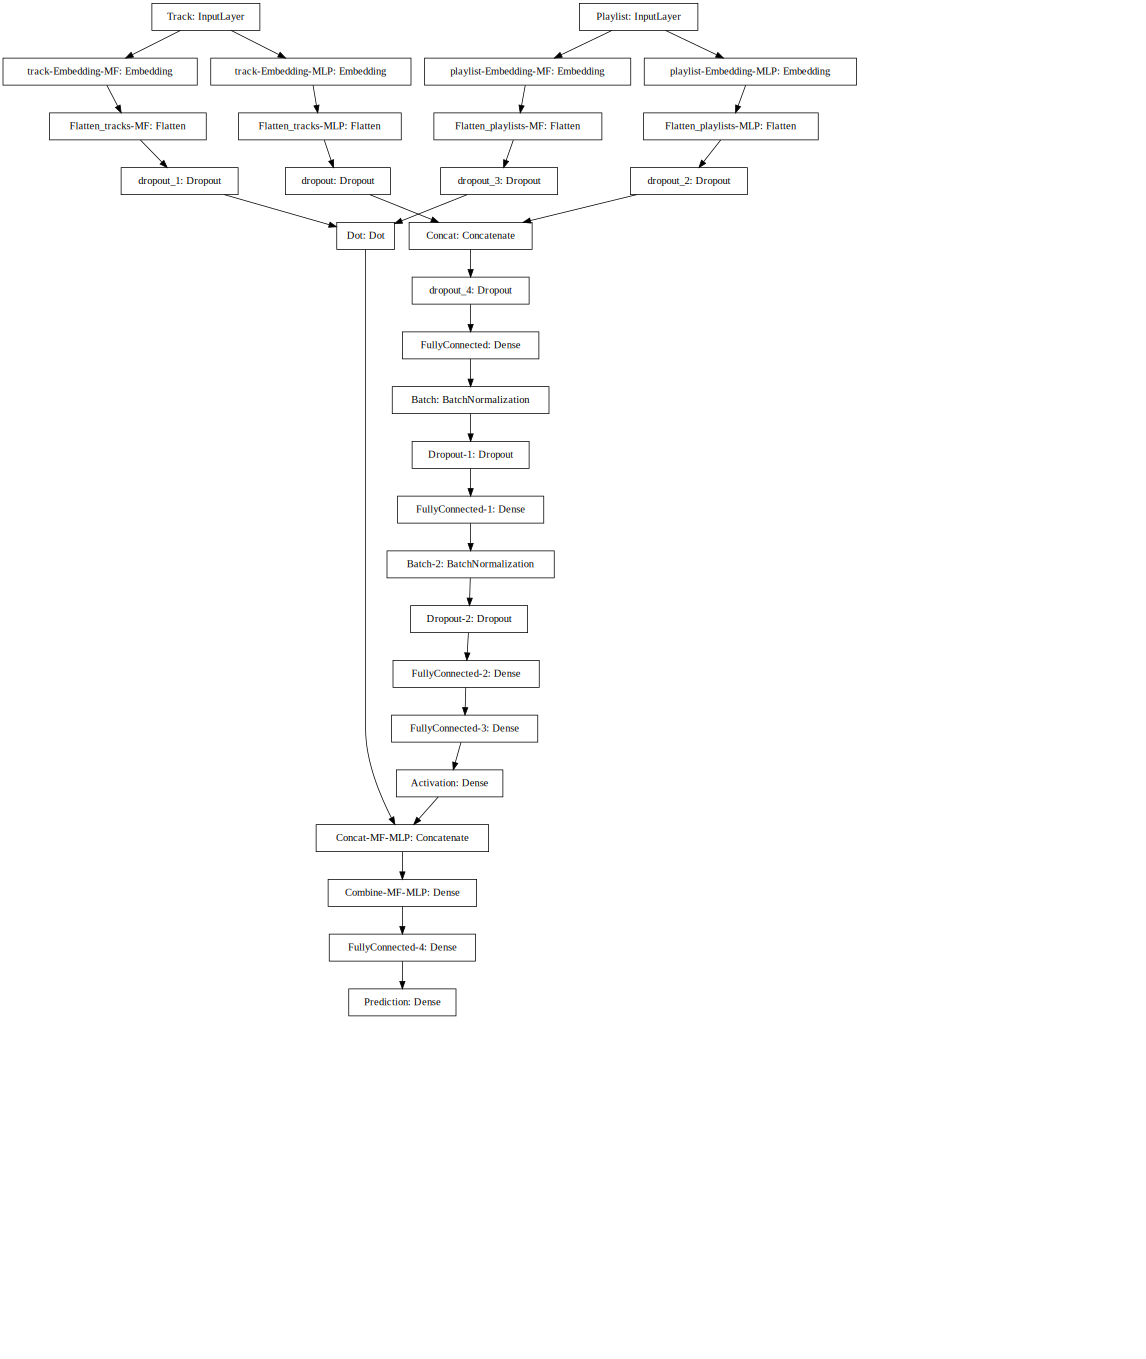

[codecarbon INFO @ 09:14:22] Energy consumed for RAM : 0.001132 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:14:22] Energy consumed for all CPUs : 0.004092 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:14:22] 0.005223 kWh of electricity used since the begining.


In [15]:
SVG(model_to_dot(model,  show_shapes=False, show_layer_names=True, rankdir='HB').
    create(prog='dot', format='svg'))

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Track (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
Playlist (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
track-Embedding-MLP (Embedding) (None, 1, 10)        152470      Track[0][0]                      
__________________________________________________________________________________________________
playlist-Embedding-MLP (Embeddi (None, 1, 10)        466710      Playlist[0][0]                   
______________________________________________________________________________________________

[codecarbon INFO @ 09:14:37] Energy consumed for RAM : 0.001181 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:14:37] Energy consumed for all CPUs : 0.004269 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:14:37] 0.005449 kWh of electricity used since the begining.


## Prediction performance of Neural Network based recommender system

In [17]:
# split data for training vs. validation/testing
data_size = n_playlists*n_tracks

# split a portion of pairs for validation and test
split_ratio = 0.05
split_num = int(data_size*split_ratio)

split_tracks = np.random.choice(n_tracks, split_num).reshape(-1,)
split_playlists = np.random.choice(n_playlists, split_num).reshape(-1,)
split_values = np.array(sparse_matrix_csv[split_tracks, split_playlists]).reshape(-1,)

split_pair = [(tr, pl) for tr,pl in zip(split_tracks,split_playlists)]

print('# of all sample =', data_size)
print('proportion of ones in all samples =', sparse_matrix_csv.count_nonzero()/data_size)
print('# of split samples =',int(np.sum(split_values)))
print('proportion of ones in split sample =', np.mean(split_values))

[codecarbon INFO @ 09:14:52] Energy consumed for RAM : 0.001230 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:14:52] Energy consumed for all CPUs : 0.004447 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:14:52] 0.005676 kWh of electricity used since the begining.


# of all sample = 711530820
proportion of ones in all samples = 0.00013639465399404625
# of split samples = 4985
proportion of ones in split sample = 0.00014012042373652908


In [18]:
# split the saved pairs into validation and test data
test_num = int(split_num/2)

test_tracks = split_tracks[:test_num]
test_playlists = split_playlists[:test_num]
test_values = split_values[:test_num]
test_target = tf.keras.utils.to_categorical(test_values, num_classes=2)

val_tracks = split_tracks[test_num+1:]
val_playlists = split_playlists[test_num+1:]
val_values = split_values[test_num+1:]
val_target = tf.keras.utils.to_categorical(val_values, num_classes=2)

In [19]:
# put split sample values to 2
sps_two = sparse_matrix_csv
sps_two[split_tracks,split_playlists] = 2

[codecarbon INFO @ 09:15:07] Energy consumed for RAM : 0.001278 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:15:07] Energy consumed for all CPUs : 0.004623 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:15:07] 0.005901 kWh of electricity used since the begining.
/usr/local/lib/python3.8/dist-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In order to train our neural network to make better predictions, we needed to adjust the balance of the data so that we had more examples of the less common class (class 1 in this case). We did this by creating more artificial examples of the less common class using data augmentation techniques. By doing this, we forced the network to pay more attention to the less common class and be less biased towards the more common class. This bias towards the less common class meant that our network had a higher chance of making "false positive" predictions, which was actually what we wanted in this case. These "false positive" predictions were actually candidates for recommendations to extend a playlist.

In [20]:
# define training sample generator (with balanced classes)

# build one-hot encoder
exampleCase = [0., 1.]
ohe = OneHotEncoder(categories='auto').fit(np.array(exampleCase).reshape((len(exampleCase), 1)))

def trainGenerator(sps_two, ohe, batch_size=10000, balance_ratio=0.5):
    """
    Generates training batches for a recommendation model.

    Parameters:
        sps_two (scipy.sparse.coo_matrix): The sparse playlist-track matrix.
        ohe (sklearn.preprocessing.OneHotEncoder): The OneHotEncoder used for encoding labels.
        batch_size (int, optional): The size of each training batch. Defaults to 10000.
        balance_ratio (float, optional): The ratio of positive (class 1) samples to negative (class 0) samples in each batch. Defaults to 0.5.

    Yields:
        tuple: A tuple containing input features and target labels for a training batch.

    """
    while True:
        n_tracks = sps_two.shape[0]
        n_playlists = sps_two.shape[1]

        # find indices for non-zero values
        index = sp.find(sps_two)

        # find number of ones and zeros in final yield
        num_ones = np.ceil(batch_size*balance_ratio).astype(int)
        num_zeros = batch_size - num_ones

        # extract tracks, playlists and labels
        tr = index[0] # track
        pl = index[1] # playlist
        la = index[2] # label

        # find where label == 1
        is_one = la == 1
        tr = tr[is_one]
        pl = pl[is_one]

        # select class one samples
        num = tr.shape[0]
        one_ind = np.random.choice(num, num_ones)
        one_tracks = tr[one_ind]
        one_playlists = pl[one_ind]
        one_values = np.ones((num_ones,1))

        # over-sample 2 times of target number for class zero randomly (and later exclude non-zero samples)
        rand_tracks = np.random.choice(n_tracks, num_zeros*2)
        rand_playlists = np.random.choice(n_playlists, num_zeros*2)
        rand_values = np.array(sps_two[rand_tracks, rand_playlists]).reshape(-1,)

        # check to find class zero samples
        is_zero = rand_values == 0
        zero_tracks = rand_tracks[is_zero]
        zero_playlists = rand_playlists[is_zero]
        
        # grab zero entries with the target number
        zero_tracks = zero_tracks[:num_zeros]
        zero_playlists = zero_playlists[:num_zeros]
        zero_values = np.zeros((num_zeros,1))

        # concatenate class one and zeros
        sub_tracks = np.concatenate((one_tracks, zero_tracks))
        sub_playlists = np.concatenate((one_playlists, zero_playlists))
        values = np.concatenate((one_values, zero_values),axis = 0)
        target = ohe.transform(values).toarray()
        
        yield [sub_playlists, sub_tracks], target

In [21]:
is_ones_val = np.array(val_values).reshape(-1,)==1
val_tracks_ones = val_tracks[is_ones_val]
val_playlists_ones = val_playlists[is_ones_val]

val_tracks_zeros = val_tracks[~is_ones_val]
val_playlists_zeros = val_playlists[~is_ones_val]

# define validation generator (with balanced classes)
def valGenerator_balance(val_tracks_ones, val_playlists_ones, val_tracks_zeros, val_playlists_zeros, 
                         ohe, val_batch_size=10000, balance_ratio = 0.5):
    """
    Generates balanced validation batches for a recommendation model.

    Parameters:
        val_tracks_ones (numpy.ndarray): An array containing the track indices for positive (class 1) validation samples.
        val_playlists_ones (numpy.ndarray): An array containing the playlist indices for positive (class 1) validation samples.
        val_tracks_zeros (numpy.ndarray): An array containing the track indices for negative (class 0) validation samples.
        val_playlists_zeros (numpy.ndarray): An array containing the playlist indices for negative (class 0) validation samples.
        ohe (sklearn.preprocessing.OneHotEncoder): The OneHotEncoder used for encoding labels.
        val_batch_size (int, optional): The size of each validation batch. Defaults to 10000.
        balance_ratio (float, optional): The ratio of positive (class 1) samples to negative (class 0) samples in each batch. Defaults to 0.5.

    Yields:
        tuple: A tuple containing input features and target labels for a validation batch.

    """
    while True:
        num_ones = int(val_batch_size*balance_ratio)
        num_zeros = val_batch_size - num_ones
        
        num_ones_total = val_tracks_ones.shape[0]
        num_zeros_total = val_tracks_zeros.shape[0]       
        
        ind_ones = np.random.choice(num_ones_total, num_ones)
        sub_val_tracks_ones = val_tracks_ones[ind_ones]
        sub_val_playlists_ones = val_playlists_ones[ind_ones]
        sub_val_values_ones = np.ones((num_ones,))
        
        ind_zeros = np.random.choice(num_zeros_total, num_zeros)
        sub_val_tracks_zeros = val_tracks_zeros[ind_zeros]
        sub_val_playlists_zeros = val_playlists_zeros[ind_zeros]
        sub_val_values_zeros = np.zeros((num_zeros,))
        
        sub_val_tracks = np.concatenate((sub_val_tracks_ones,sub_val_tracks_zeros))
        sub_val_playlists = np.concatenate((sub_val_playlists_ones,sub_val_playlists_zeros))
        sub_val_values = np.concatenate((sub_val_values_ones,sub_val_values_zeros))
        sub_val_target = ohe.transform(sub_val_values.reshape(-1,1)).toarray()
        
        yield [sub_val_playlists, sub_val_tracks], sub_val_target

[codecarbon INFO @ 09:15:22] Energy consumed for RAM : 0.001327 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:15:22] Energy consumed for all CPUs : 0.004800 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:15:22] 0.006127 kWh of electricity used since the begining.
[codecarbon INFO @ 09:15:37] Energy consumed for RAM : 0.001376 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:15:37] Energy consumed for all CPUs : 0.004977 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:15:37] 0.006353 kWh of electricity used since the begining.
[codecarbon INFO @ 09:15:52] Energy consumed for RAM : 0.001425 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:15:52] Energy consumed for all CPUs : 0.005154 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:15:52] 0.006579 kWh of electricity used since the begining.
[codecarbon INFO @ 09:16:07] Energy consumed for RAM : 0.001474 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:16:07] Energy consumed for all

## Model training

In [22]:
# set checkpoints
filepath = "models/NNFC/model.{epoch:02d}-{val_loss:.2f}-{val_accuracy:.2f}.h5"

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', 
                             verbose=2, save_best_only=True, mode='auto', save_freq='epoch')
callbacks_list = [checkpoint]

In [25]:
# Net training
start_time = time.time()

# fit model with validation data
history = model.fit(
    trainGenerator(sps_two, ohe, batch_size=20000, balance_ratio=0.5), 
    epochs=500, steps_per_epoch = 1, verbose=2, workers=1, use_multiprocessing=False,
    validation_data=valGenerator_balance(
        val_tracks_ones, val_playlists_ones, 
        val_tracks_zeros, val_playlists_zeros,
        ohe, val_batch_size=10000, balance_ratio = 0.5),
    validation_steps=1,
    callbacks=callbacks_list)

end_time = time.time()
print('Training time: ' + str(round((end_time-start_time)/60,2)) + " minutes")

[codecarbon INFO @ 09:17:07] Energy consumed for RAM : 0.001670 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:17:07] Energy consumed for all CPUs : 0.006039 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:17:07] 0.007709 kWh of electricity used since the begining.
COMET INFO: Ignoring automatic log_parameter('verbose') because 'keras:verbose' is in COMET_LOGGING_PARAMETERS_IGNORE
2023-05-01 09:17:12.298963: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/500


COMET INFO: ignoring tensorflow summary log of metrics because of keras; set `comet_ml.loggers.tensorboard_logger.LOG_METRICS = True` to override


1/1 - 2s - loss: 0.6985 - accuracy: 0.5003 - val_loss: 0.6932 - val_accuracy: 0.5000

Epoch 00001: val_loss improved from inf to 0.69319, saving model to models/NNFC/model.01-0.69-0.50.h5
Epoch 2/500


[codecarbon INFO @ 09:17:22] Energy consumed for RAM : 0.001719 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:17:22] Energy consumed for all CPUs : 0.006216 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:17:22] 0.007935 kWh of electricity used since the begining.


1/1 - 7s - loss: 0.6936 - accuracy: 0.4970 - val_loss: 0.6933 - val_accuracy: 0.5000

Epoch 00002: val_loss did not improve from 0.69319
Epoch 3/500
1/1 - 8s - loss: 0.6933 - accuracy: 0.5000 - val_loss: 0.6934 - val_accuracy: 0.5000

Epoch 00003: val_loss did not improve from 0.69319
Epoch 4/500


[codecarbon INFO @ 09:17:37] Energy consumed for RAM : 0.001768 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:17:37] Energy consumed for all CPUs : 0.006393 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:17:37] 0.008161 kWh of electricity used since the begining.


1/1 - 10s - loss: 0.6935 - accuracy: 0.5000 - val_loss: 0.6934 - val_accuracy: 0.5000

Epoch 00004: val_loss did not improve from 0.69319
Epoch 5/500
1/1 - 8s - loss: 0.6937 - accuracy: 0.5000 - val_loss: 0.6933 - val_accuracy: 0.5000

Epoch 00005: val_loss did not improve from 0.69319
Epoch 6/500


[codecarbon INFO @ 09:17:52] Energy consumed for RAM : 0.001817 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:17:52] Energy consumed for all CPUs : 0.006570 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:17:52] 0.008387 kWh of electricity used since the begining.


1/1 - 10s - loss: 0.6936 - accuracy: 0.5049 - val_loss: 0.6933 - val_accuracy: 0.5000

Epoch 00006: val_loss did not improve from 0.69319
Epoch 7/500
1/1 - 8s - loss: 0.6936 - accuracy: 0.5037 - val_loss: 0.6932 - val_accuracy: 0.5000

Epoch 00007: val_loss did not improve from 0.69319
Epoch 8/500


[codecarbon INFO @ 09:18:07] Energy consumed for RAM : 0.001866 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:18:07] Energy consumed for all CPUs : 0.006747 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:18:07] 0.008613 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.6936 - accuracy: 0.5010 - val_loss: 0.6932 - val_accuracy: 0.5000

Epoch 00008: val_loss improved from 0.69319 to 0.69318, saving model to models/NNFC/model.08-0.69-0.50.h5
Epoch 9/500


[codecarbon INFO @ 09:18:22] Energy consumed for RAM : 0.001915 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:18:22] Energy consumed for all CPUs : 0.006924 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:18:22] 0.008839 kWh of electricity used since the begining.


1/1 - 8s - loss: 0.6935 - accuracy: 0.4965 - val_loss: 0.6932 - val_accuracy: 0.5000

Epoch 00009: val_loss improved from 0.69318 to 0.69316, saving model to models/NNFC/model.09-0.69-0.50.h5
Epoch 10/500
1/1 - 8s - loss: 0.6933 - accuracy: 0.5012 - val_loss: 0.6932 - val_accuracy: 0.5000

Epoch 00010: val_loss improved from 0.69316 to 0.69316, saving model to models/NNFC/model.10-0.69-0.50.h5
Epoch 11/500


[codecarbon INFO @ 09:18:37] Energy consumed for RAM : 0.001964 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:18:37] Energy consumed for all CPUs : 0.007101 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:18:37] 0.009065 kWh of electricity used since the begining.


1/1 - 8s - loss: 0.6933 - accuracy: 0.5016 - val_loss: 0.6932 - val_accuracy: 0.5000

Epoch 00011: val_loss did not improve from 0.69316
Epoch 12/500
1/1 - 8s - loss: 0.6933 - accuracy: 0.4988 - val_loss: 0.6932 - val_accuracy: 0.5000

Epoch 00012: val_loss did not improve from 0.69316
Epoch 13/500


[codecarbon INFO @ 09:18:52] Energy consumed for RAM : 0.002013 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:18:52] Energy consumed for all CPUs : 0.007278 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:18:52] 0.009292 kWh of electricity used since the begining.


1/1 - 8s - loss: 0.6933 - accuracy: 0.5002 - val_loss: 0.6932 - val_accuracy: 0.5000

Epoch 00013: val_loss did not improve from 0.69316
Epoch 14/500
1/1 - 8s - loss: 0.6933 - accuracy: 0.5020 - val_loss: 0.6932 - val_accuracy: 0.5000

Epoch 00014: val_loss did not improve from 0.69316
Epoch 15/500


[codecarbon INFO @ 09:19:07] Energy consumed for RAM : 0.002062 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:19:07] Energy consumed for all CPUs : 0.007456 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:19:07] 0.009518 kWh of electricity used since the begining.


1/1 - 8s - loss: 0.6933 - accuracy: 0.5009 - val_loss: 0.6933 - val_accuracy: 0.5000

Epoch 00015: val_loss did not improve from 0.69316
Epoch 16/500
1/1 - 8s - loss: 0.6933 - accuracy: 0.5009 - val_loss: 0.6933 - val_accuracy: 0.5000

Epoch 00016: val_loss did not improve from 0.69316
Epoch 17/500


[codecarbon INFO @ 09:19:22] Energy consumed for RAM : 0.002111 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:19:22] Energy consumed for all CPUs : 0.007633 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:19:22] 0.009744 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.6933 - accuracy: 0.5000 - val_loss: 0.6933 - val_accuracy: 0.5000

Epoch 00017: val_loss did not improve from 0.69316
Epoch 18/500
1/1 - 8s - loss: 0.6933 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000

Epoch 00018: val_loss did not improve from 0.69316
Epoch 19/500


[codecarbon INFO @ 09:19:37] Energy consumed for RAM : 0.002160 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:19:37] Energy consumed for all CPUs : 0.007810 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:19:37] 0.009970 kWh of electricity used since the begining.


1/1 - 8s - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000

Epoch 00019: val_loss did not improve from 0.69316
Epoch 20/500


[codecarbon INFO @ 09:19:52] Energy consumed for RAM : 0.002209 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:19:52] Energy consumed for all CPUs : 0.007987 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:19:52] 0.010196 kWh of electricity used since the begining.


1/1 - 8s - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000

Epoch 00020: val_loss did not improve from 0.69316
Epoch 21/500
1/1 - 8s - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000

Epoch 00021: val_loss did not improve from 0.69316
Epoch 22/500


[codecarbon INFO @ 09:20:07] Energy consumed for RAM : 0.002258 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:20:07] Energy consumed for all CPUs : 0.008164 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:20:07] 0.010422 kWh of electricity used since the begining.


1/1 - 8s - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000

Epoch 00022: val_loss did not improve from 0.69316
Epoch 23/500
1/1 - 9s - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000

Epoch 00023: val_loss improved from 0.69316 to 0.69315, saving model to models/NNFC/model.23-0.69-0.50.h5
Epoch 24/500


[codecarbon INFO @ 09:20:22] Energy consumed for RAM : 0.002307 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:20:22] Energy consumed for all CPUs : 0.008341 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:20:22] 0.010648 kWh of electricity used since the begining.


1/1 - 8s - loss: 0.6932 - accuracy: 0.4999 - val_loss: 0.6931 - val_accuracy: 0.5079

Epoch 00024: val_loss improved from 0.69315 to 0.69315, saving model to models/NNFC/model.24-0.69-0.51.h5
Epoch 25/500
1/1 - 8s - loss: 0.6932 - accuracy: 0.5049 - val_loss: 0.6932 - val_accuracy: 0.5001

Epoch 00025: val_loss did not improve from 0.69315
Epoch 26/500


[codecarbon INFO @ 09:20:37] Energy consumed for RAM : 0.002356 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:20:37] Energy consumed for all CPUs : 0.008518 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:20:37] 0.010874 kWh of electricity used since the begining.


1/1 - 8s - loss: 0.6932 - accuracy: 0.5016 - val_loss: 0.6932 - val_accuracy: 0.5000

Epoch 00026: val_loss did not improve from 0.69315
Epoch 27/500
1/1 - 8s - loss: 0.6932 - accuracy: 0.5002 - val_loss: 0.6932 - val_accuracy: 0.5000

Epoch 00027: val_loss did not improve from 0.69315
Epoch 28/500


[codecarbon INFO @ 09:20:52] Energy consumed for RAM : 0.002405 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:20:52] Energy consumed for all CPUs : 0.008695 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:20:52] 0.011100 kWh of electricity used since the begining.


1/1 - 8s - loss: 0.6932 - accuracy: 0.5001 - val_loss: 0.6932 - val_accuracy: 0.5000

Epoch 00028: val_loss did not improve from 0.69315
Epoch 29/500
1/1 - 8s - loss: 0.6932 - accuracy: 0.4995 - val_loss: 0.6932 - val_accuracy: 0.5000

Epoch 00029: val_loss did not improve from 0.69315
Epoch 30/500


[codecarbon INFO @ 09:21:07] Energy consumed for RAM : 0.002454 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:21:07] Energy consumed for all CPUs : 0.008872 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:21:07] 0.011326 kWh of electricity used since the begining.


1/1 - 8s - loss: 0.6932 - accuracy: 0.5013 - val_loss: 0.6932 - val_accuracy: 0.5000

Epoch 00030: val_loss did not improve from 0.69315
Epoch 31/500
1/1 - 8s - loss: 0.6932 - accuracy: 0.5005 - val_loss: 0.6932 - val_accuracy: 0.4996


[codecarbon INFO @ 09:21:22] Energy consumed for RAM : 0.002503 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:21:22] Energy consumed for all CPUs : 0.009049 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:21:22] 0.011552 kWh of electricity used since the begining.



Epoch 00031: val_loss did not improve from 0.69315
Epoch 32/500
1/1 - 8s - loss: 0.6932 - accuracy: 0.5008 - val_loss: 0.6932 - val_accuracy: 0.4990

Epoch 00032: val_loss did not improve from 0.69315
Epoch 33/500


[codecarbon INFO @ 09:21:37] Energy consumed for RAM : 0.002552 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:21:37] Energy consumed for all CPUs : 0.009226 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:21:37] 0.011778 kWh of electricity used since the begining.


1/1 - 8s - loss: 0.6932 - accuracy: 0.5021 - val_loss: 0.6932 - val_accuracy: 0.4967

Epoch 00033: val_loss did not improve from 0.69315
Epoch 34/500
1/1 - 8s - loss: 0.6932 - accuracy: 0.5063 - val_loss: 0.6932 - val_accuracy: 0.5042

Epoch 00034: val_loss did not improve from 0.69315
Epoch 35/500


[codecarbon INFO @ 09:21:52] Energy consumed for RAM : 0.002601 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:21:52] Energy consumed for all CPUs : 0.009403 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:21:52] 0.012004 kWh of electricity used since the begining.


1/1 - 8s - loss: 0.6931 - accuracy: 0.5095 - val_loss: 0.6931 - val_accuracy: 0.5003

Epoch 00035: val_loss improved from 0.69315 to 0.69314, saving model to models/NNFC/model.35-0.69-0.50.h5
Epoch 36/500
1/1 - 9s - loss: 0.6931 - accuracy: 0.4994 - val_loss: 0.6932 - val_accuracy: 0.4976

Epoch 00036: val_loss did not improve from 0.69314
Epoch 37/500


[codecarbon INFO @ 09:22:07] Energy consumed for RAM : 0.002650 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:22:07] Energy consumed for all CPUs : 0.009580 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:22:07] 0.012230 kWh of electricity used since the begining.


1/1 - 8s - loss: 0.6931 - accuracy: 0.4999 - val_loss: 0.6931 - val_accuracy: 0.4993

Epoch 00037: val_loss did not improve from 0.69314
Epoch 38/500
1/1 - 10s - loss: 0.6931 - accuracy: 0.5021 - val_loss: 0.6931 - val_accuracy: 0.5026

Epoch 00038: val_loss improved from 0.69314 to 0.69314, saving model to models/NNFC/model.38-0.69-0.50.h5
Epoch 39/500


[codecarbon INFO @ 09:22:22] Energy consumed for RAM : 0.002699 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:22:22] Energy consumed for all CPUs : 0.009757 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:22:22] 0.012456 kWh of electricity used since the begining.


1/1 - 8s - loss: 0.6931 - accuracy: 0.5053 - val_loss: 0.6932 - val_accuracy: 0.5002

Epoch 00039: val_loss did not improve from 0.69314
Epoch 40/500


[codecarbon INFO @ 09:22:37] Energy consumed for RAM : 0.002748 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:22:37] Energy consumed for all CPUs : 0.009934 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:22:37] 0.012682 kWh of electricity used since the begining.


1/1 - 8s - loss: 0.6931 - accuracy: 0.5094 - val_loss: 0.6931 - val_accuracy: 0.5120

Epoch 00040: val_loss did not improve from 0.69314
Epoch 41/500
1/1 - 8s - loss: 0.6931 - accuracy: 0.5122 - val_loss: 0.6932 - val_accuracy: 0.5027

Epoch 00041: val_loss did not improve from 0.69314
Epoch 42/500


[codecarbon INFO @ 09:22:52] Energy consumed for RAM : 0.002797 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:22:52] Energy consumed for all CPUs : 0.010112 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:22:52] 0.012908 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.6931 - accuracy: 0.5067 - val_loss: 0.6932 - val_accuracy: 0.4911

Epoch 00042: val_loss did not improve from 0.69314
Epoch 43/500
1/1 - 8s - loss: 0.6931 - accuracy: 0.5121 - val_loss: 0.6932 - val_accuracy: 0.4994

Epoch 00043: val_loss did not improve from 0.69314
Epoch 44/500


[codecarbon INFO @ 09:23:07] Energy consumed for RAM : 0.002846 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:23:07] Energy consumed for all CPUs : 0.010289 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:23:07] 0.013134 kWh of electricity used since the begining.


1/1 - 8s - loss: 0.6931 - accuracy: 0.5108 - val_loss: 0.6932 - val_accuracy: 0.4952

Epoch 00044: val_loss did not improve from 0.69314
Epoch 45/500
1/1 - 9s - loss: 0.6931 - accuracy: 0.5153 - val_loss: 0.6932 - val_accuracy: 0.4942

Epoch 00045: val_loss did not improve from 0.69314
Epoch 46/500


[codecarbon INFO @ 09:23:22] Energy consumed for RAM : 0.002895 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:23:22] Energy consumed for all CPUs : 0.010466 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:23:22] 0.013360 kWh of electricity used since the begining.


1/1 - 8s - loss: 0.6931 - accuracy: 0.5195 - val_loss: 0.6931 - val_accuracy: 0.5095

Epoch 00046: val_loss improved from 0.69314 to 0.69314, saving model to models/NNFC/model.46-0.69-0.51.h5
Epoch 47/500


[codecarbon INFO @ 09:23:37] Energy consumed for RAM : 0.002944 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:23:37] Energy consumed for all CPUs : 0.010643 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:23:37] 0.013586 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.6931 - accuracy: 0.5073 - val_loss: 0.6932 - val_accuracy: 0.4968

Epoch 00047: val_loss did not improve from 0.69314
Epoch 48/500
1/1 - 9s - loss: 0.6931 - accuracy: 0.5139 - val_loss: 0.6932 - val_accuracy: 0.4901

Epoch 00048: val_loss did not improve from 0.69314
Epoch 49/500


[codecarbon INFO @ 09:23:52] Energy consumed for RAM : 0.002993 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:23:52] Energy consumed for all CPUs : 0.010820 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:23:52] 0.013812 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.6931 - accuracy: 0.5167 - val_loss: 0.6931 - val_accuracy: 0.5064

Epoch 00049: val_loss improved from 0.69314 to 0.69314, saving model to models/NNFC/model.49-0.69-0.51.h5
Epoch 50/500
1/1 - 8s - loss: 0.6931 - accuracy: 0.5229 - val_loss: 0.6931 - val_accuracy: 0.4978

Epoch 00050: val_loss did not improve from 0.69314
Epoch 51/500


[codecarbon INFO @ 09:24:07] Energy consumed for RAM : 0.003042 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:24:07] Energy consumed for all CPUs : 0.010997 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:24:07] 0.014038 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.6931 - accuracy: 0.5261 - val_loss: 0.6932 - val_accuracy: 0.4963

Epoch 00051: val_loss did not improve from 0.69314
Epoch 52/500
1/1 - 8s - loss: 0.6931 - accuracy: 0.5300 - val_loss: 0.6932 - val_accuracy: 0.4994

Epoch 00052: val_loss did not improve from 0.69314
Epoch 53/500


[codecarbon INFO @ 09:24:22] Energy consumed for RAM : 0.003091 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:24:22] Energy consumed for all CPUs : 0.011174 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:24:22] 0.014264 kWh of electricity used since the begining.


1/1 - 8s - loss: 0.6931 - accuracy: 0.5265 - val_loss: 0.6931 - val_accuracy: 0.4995

Epoch 00053: val_loss did not improve from 0.69314
Epoch 54/500


[codecarbon INFO @ 09:24:37] Energy consumed for RAM : 0.003140 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:24:37] Energy consumed for all CPUs : 0.011351 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:24:37] 0.014490 kWh of electricity used since the begining.


1/1 - 8s - loss: 0.6931 - accuracy: 0.5261 - val_loss: 0.6932 - val_accuracy: 0.4905

Epoch 00054: val_loss did not improve from 0.69314
Epoch 55/500
1/1 - 8s - loss: 0.6930 - accuracy: 0.5340 - val_loss: 0.6931 - val_accuracy: 0.5057

Epoch 00055: val_loss did not improve from 0.69314
Epoch 56/500


[codecarbon INFO @ 09:24:52] Energy consumed for RAM : 0.003189 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:24:52] Energy consumed for all CPUs : 0.011528 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:24:52] 0.014717 kWh of electricity used since the begining.


1/1 - 10s - loss: 0.6931 - accuracy: 0.5242 - val_loss: 0.6931 - val_accuracy: 0.5054

Epoch 00056: val_loss did not improve from 0.69314
Epoch 57/500
1/1 - 10s - loss: 0.6930 - accuracy: 0.5327 - val_loss: 0.6931 - val_accuracy: 0.5045

Epoch 00057: val_loss did not improve from 0.69314
Epoch 58/500


[codecarbon INFO @ 09:25:07] Energy consumed for RAM : 0.003238 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:25:07] Energy consumed for all CPUs : 0.011705 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:25:07] 0.014942 kWh of electricity used since the begining.


1/1 - 8s - loss: 0.6930 - accuracy: 0.5315 - val_loss: 0.6932 - val_accuracy: 0.4999

Epoch 00058: val_loss did not improve from 0.69314
Epoch 59/500


[codecarbon INFO @ 09:25:22] Energy consumed for RAM : 0.003287 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:25:22] Energy consumed for all CPUs : 0.011882 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:25:22] 0.015169 kWh of electricity used since the begining.


1/1 - 8s - loss: 0.6930 - accuracy: 0.5347 - val_loss: 0.6932 - val_accuracy: 0.4949

Epoch 00059: val_loss did not improve from 0.69314
Epoch 60/500
1/1 - 9s - loss: 0.6930 - accuracy: 0.5393 - val_loss: 0.6931 - val_accuracy: 0.5030

Epoch 00060: val_loss improved from 0.69314 to 0.69314, saving model to models/NNFC/model.60-0.69-0.50.h5
Epoch 61/500


[codecarbon INFO @ 09:25:37] Energy consumed for RAM : 0.003336 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:25:37] Energy consumed for all CPUs : 0.012059 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:25:37] 0.015395 kWh of electricity used since the begining.


1/1 - 8s - loss: 0.6929 - accuracy: 0.5398 - val_loss: 0.6931 - val_accuracy: 0.5008

Epoch 00061: val_loss improved from 0.69314 to 0.69314, saving model to models/NNFC/model.61-0.69-0.50.h5
Epoch 62/500
1/1 - 9s - loss: 0.6929 - accuracy: 0.5454 - val_loss: 0.6932 - val_accuracy: 0.4998

Epoch 00062: val_loss did not improve from 0.69314
Epoch 63/500


[codecarbon INFO @ 09:25:52] Energy consumed for RAM : 0.003385 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:25:52] Energy consumed for all CPUs : 0.012236 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:25:52] 0.015621 kWh of electricity used since the begining.


1/1 - 8s - loss: 0.6928 - accuracy: 0.5519 - val_loss: 0.6931 - val_accuracy: 0.5137

Epoch 00063: val_loss did not improve from 0.69314
Epoch 64/500
1/1 - 8s - loss: 0.6928 - accuracy: 0.5517 - val_loss: 0.6931 - val_accuracy: 0.5082

Epoch 00064: val_loss did not improve from 0.69314
Epoch 65/500


[codecarbon INFO @ 09:26:07] Energy consumed for RAM : 0.003433 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:26:07] Energy consumed for all CPUs : 0.012413 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:26:07] 0.015847 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.6928 - accuracy: 0.5623 - val_loss: 0.6932 - val_accuracy: 0.5044

Epoch 00065: val_loss did not improve from 0.69314
Epoch 66/500


[codecarbon INFO @ 09:26:22] Energy consumed for RAM : 0.003482 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:26:22] Energy consumed for all CPUs : 0.012590 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:26:22] 0.016073 kWh of electricity used since the begining.


1/1 - 10s - loss: 0.6927 - accuracy: 0.5630 - val_loss: 0.6931 - val_accuracy: 0.5021

Epoch 00066: val_loss did not improve from 0.69314
Epoch 67/500
1/1 - 10s - loss: 0.6927 - accuracy: 0.5587 - val_loss: 0.6931 - val_accuracy: 0.4983

Epoch 00067: val_loss did not improve from 0.69314
Epoch 68/500


[codecarbon INFO @ 09:26:37] Energy consumed for RAM : 0.003531 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:26:37] Energy consumed for all CPUs : 0.012767 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:26:37] 0.016299 kWh of electricity used since the begining.


1/1 - 10s - loss: 0.6926 - accuracy: 0.5701 - val_loss: 0.6932 - val_accuracy: 0.4949

Epoch 00068: val_loss did not improve from 0.69314
Epoch 69/500
1/1 - 9s - loss: 0.6925 - accuracy: 0.5810 - val_loss: 0.6932 - val_accuracy: 0.4982

Epoch 00069: val_loss did not improve from 0.69314
Epoch 70/500


[codecarbon INFO @ 09:26:52] Energy consumed for RAM : 0.003580 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:26:52] Energy consumed for all CPUs : 0.012944 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:26:52] 0.016525 kWh of electricity used since the begining.


1/1 - 8s - loss: 0.6925 - accuracy: 0.5746 - val_loss: 0.6931 - val_accuracy: 0.5087

Epoch 00070: val_loss improved from 0.69314 to 0.69310, saving model to models/NNFC/model.70-0.69-0.51.h5
Epoch 71/500


[codecarbon INFO @ 09:27:07] Energy consumed for RAM : 0.003629 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:27:07] Energy consumed for all CPUs : 0.013121 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:27:07] 0.016751 kWh of electricity used since the begining.


1/1 - 8s - loss: 0.6924 - accuracy: 0.5781 - val_loss: 0.6932 - val_accuracy: 0.5030

Epoch 00071: val_loss did not improve from 0.69310
Epoch 72/500
1/1 - 8s - loss: 0.6923 - accuracy: 0.5854 - val_loss: 0.6932 - val_accuracy: 0.4954

Epoch 00072: val_loss did not improve from 0.69310
Epoch 73/500


[codecarbon INFO @ 09:27:22] Energy consumed for RAM : 0.003678 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:27:22] Energy consumed for all CPUs : 0.013298 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:27:22] 0.016977 kWh of electricity used since the begining.


1/1 - 8s - loss: 0.6923 - accuracy: 0.5856 - val_loss: 0.6931 - val_accuracy: 0.5069

Epoch 00073: val_loss did not improve from 0.69310
Epoch 74/500
1/1 - 8s - loss: 0.6921 - accuracy: 0.5961 - val_loss: 0.6932 - val_accuracy: 0.5029

Epoch 00074: val_loss did not improve from 0.69310
Epoch 75/500


[codecarbon INFO @ 09:27:37] Energy consumed for RAM : 0.003727 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:27:37] Energy consumed for all CPUs : 0.013475 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:27:37] 0.017203 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.6921 - accuracy: 0.5917 - val_loss: 0.6931 - val_accuracy: 0.5119

Epoch 00075: val_loss improved from 0.69310 to 0.69310, saving model to models/NNFC/model.75-0.69-0.51.h5
Epoch 76/500
1/1 - 8s - loss: 0.6919 - accuracy: 0.5994 - val_loss: 0.6932 - val_accuracy: 0.4981

Epoch 00076: val_loss did not improve from 0.69310
Epoch 77/500


[codecarbon INFO @ 09:27:52] Energy consumed for RAM : 0.003776 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:27:52] Energy consumed for all CPUs : 0.013653 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:27:52] 0.017429 kWh of electricity used since the begining.


1/1 - 8s - loss: 0.6917 - accuracy: 0.6095 - val_loss: 0.6932 - val_accuracy: 0.4989

Epoch 00077: val_loss did not improve from 0.69310
Epoch 78/500
1/1 - 8s - loss: 0.6916 - accuracy: 0.6113 - val_loss: 0.6931 - val_accuracy: 0.5034

Epoch 00078: val_loss did not improve from 0.69310
Epoch 79/500


[codecarbon INFO @ 09:28:07] Energy consumed for RAM : 0.003825 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:28:07] Energy consumed for all CPUs : 0.013830 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:28:07] 0.017655 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.6914 - accuracy: 0.6169 - val_loss: 0.6932 - val_accuracy: 0.5021

Epoch 00079: val_loss did not improve from 0.69310
Epoch 80/500


[codecarbon INFO @ 09:28:22] Energy consumed for RAM : 0.003874 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:28:22] Energy consumed for all CPUs : 0.014007 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:28:22] 0.017881 kWh of electricity used since the begining.


1/1 - 8s - loss: 0.6913 - accuracy: 0.6145 - val_loss: 0.6932 - val_accuracy: 0.4989

Epoch 00080: val_loss did not improve from 0.69310
Epoch 81/500
1/1 - 9s - loss: 0.6910 - accuracy: 0.6224 - val_loss: 0.6932 - val_accuracy: 0.5036

Epoch 00081: val_loss did not improve from 0.69310
Epoch 82/500


[codecarbon INFO @ 09:28:37] Energy consumed for RAM : 0.003923 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:28:37] Energy consumed for all CPUs : 0.014184 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:28:37] 0.018107 kWh of electricity used since the begining.


1/1 - 8s - loss: 0.6908 - accuracy: 0.6291 - val_loss: 0.6933 - val_accuracy: 0.4981

Epoch 00082: val_loss did not improve from 0.69310
Epoch 83/500
1/1 - 9s - loss: 0.6905 - accuracy: 0.6323 - val_loss: 0.6931 - val_accuracy: 0.5129

Epoch 00083: val_loss did not improve from 0.69310
Epoch 84/500


[codecarbon INFO @ 09:28:52] Energy consumed for RAM : 0.003972 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:28:52] Energy consumed for all CPUs : 0.014361 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:28:52] 0.018333 kWh of electricity used since the begining.


1/1 - 8s - loss: 0.6902 - accuracy: 0.6416 - val_loss: 0.6932 - val_accuracy: 0.5066

Epoch 00084: val_loss did not improve from 0.69310
Epoch 85/500
1/1 - 8s - loss: 0.6900 - accuracy: 0.6390 - val_loss: 0.6933 - val_accuracy: 0.5028

Epoch 00085: val_loss did not improve from 0.69310
Epoch 86/500


[codecarbon INFO @ 09:29:07] Energy consumed for RAM : 0.004021 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:29:07] Energy consumed for all CPUs : 0.014538 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:29:07] 0.018559 kWh of electricity used since the begining.


1/1 - 8s - loss: 0.6896 - accuracy: 0.6512 - val_loss: 0.6933 - val_accuracy: 0.4994

Epoch 00086: val_loss did not improve from 0.69310
Epoch 87/500
1/1 - 8s - loss: 0.6892 - accuracy: 0.6561 - val_loss: 0.6933 - val_accuracy: 0.4987

Epoch 00087: val_loss did not improve from 0.69310
Epoch 88/500


[codecarbon INFO @ 09:29:22] Energy consumed for RAM : 0.004070 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:29:22] Energy consumed for all CPUs : 0.014715 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:29:22] 0.018785 kWh of electricity used since the begining.


1/1 - 8s - loss: 0.6889 - accuracy: 0.6608 - val_loss: 0.6933 - val_accuracy: 0.5035

Epoch 00088: val_loss did not improve from 0.69310
Epoch 89/500


[codecarbon INFO @ 09:29:37] Energy consumed for RAM : 0.004119 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:29:37] Energy consumed for all CPUs : 0.014892 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:29:37] 0.019011 kWh of electricity used since the begining.


1/1 - 8s - loss: 0.6884 - accuracy: 0.6635 - val_loss: 0.6933 - val_accuracy: 0.5074

Epoch 00089: val_loss did not improve from 0.69310
Epoch 90/500
1/1 - 8s - loss: 0.6878 - accuracy: 0.6712 - val_loss: 0.6932 - val_accuracy: 0.5128

Epoch 00090: val_loss did not improve from 0.69310
Epoch 91/500


[codecarbon INFO @ 09:29:52] Energy consumed for RAM : 0.004168 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:29:52] Energy consumed for all CPUs : 0.015069 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:29:52] 0.019237 kWh of electricity used since the begining.


1/1 - 10s - loss: 0.6874 - accuracy: 0.6710 - val_loss: 0.6932 - val_accuracy: 0.5115

Epoch 00091: val_loss did not improve from 0.69310
Epoch 92/500
1/1 - 8s - loss: 0.6868 - accuracy: 0.6823 - val_loss: 0.6933 - val_accuracy: 0.5098

Epoch 00092: val_loss did not improve from 0.69310
Epoch 93/500


[codecarbon INFO @ 09:30:07] Energy consumed for RAM : 0.004217 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:30:07] Energy consumed for all CPUs : 0.015246 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:30:07] 0.019463 kWh of electricity used since the begining.


1/1 - 8s - loss: 0.6861 - accuracy: 0.6887 - val_loss: 0.6934 - val_accuracy: 0.5042

Epoch 00093: val_loss did not improve from 0.69310
Epoch 94/500
1/1 - 8s - loss: 0.6856 - accuracy: 0.6902 - val_loss: 0.6934 - val_accuracy: 0.5100

Epoch 00094: val_loss did not improve from 0.69310
Epoch 95/500


[codecarbon INFO @ 09:30:22] Energy consumed for RAM : 0.004266 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:30:22] Energy consumed for all CPUs : 0.015423 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:30:22] 0.019689 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.6846 - accuracy: 0.6964 - val_loss: 0.6934 - val_accuracy: 0.5073

Epoch 00095: val_loss did not improve from 0.69310
Epoch 96/500
1/1 - 8s - loss: 0.6839 - accuracy: 0.6988 - val_loss: 0.6934 - val_accuracy: 0.5020


[codecarbon INFO @ 09:30:37] Energy consumed for RAM : 0.004315 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:30:37] Energy consumed for all CPUs : 0.015600 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:30:37] 0.019915 kWh of electricity used since the begining.



Epoch 00096: val_loss did not improve from 0.69310
Epoch 97/500
1/1 - 8s - loss: 0.6833 - accuracy: 0.7009 - val_loss: 0.6935 - val_accuracy: 0.5032

Epoch 00097: val_loss did not improve from 0.69310
Epoch 98/500


[codecarbon INFO @ 09:30:52] Energy consumed for RAM : 0.004364 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:30:52] Energy consumed for all CPUs : 0.015777 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:30:52] 0.020141 kWh of electricity used since the begining.


1/1 - 8s - loss: 0.6820 - accuracy: 0.7111 - val_loss: 0.6934 - val_accuracy: 0.5081

Epoch 00098: val_loss did not improve from 0.69310
Epoch 99/500
1/1 - 8s - loss: 0.6810 - accuracy: 0.7159 - val_loss: 0.6936 - val_accuracy: 0.5147

Epoch 00099: val_loss did not improve from 0.69310
Epoch 100/500


[codecarbon INFO @ 09:31:07] Energy consumed for RAM : 0.004413 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:31:07] Energy consumed for all CPUs : 0.015954 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:31:07] 0.020367 kWh of electricity used since the begining.


1/1 - 10s - loss: 0.6800 - accuracy: 0.7153 - val_loss: 0.6940 - val_accuracy: 0.5000

Epoch 00100: val_loss did not improve from 0.69310
Epoch 101/500
1/1 - 9s - loss: 0.6787 - accuracy: 0.7235 - val_loss: 0.6936 - val_accuracy: 0.5087

Epoch 00101: val_loss did not improve from 0.69310
Epoch 102/500


[codecarbon INFO @ 09:31:22] Energy consumed for RAM : 0.004462 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:31:22] Energy consumed for all CPUs : 0.016131 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:31:22] 0.020593 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.6770 - accuracy: 0.7324 - val_loss: 0.6937 - val_accuracy: 0.5086

Epoch 00102: val_loss did not improve from 0.69310
Epoch 103/500


[codecarbon INFO @ 09:31:37] Energy consumed for RAM : 0.004511 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:31:37] Energy consumed for all CPUs : 0.016308 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:31:37] 0.020819 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.6757 - accuracy: 0.7393 - val_loss: 0.6937 - val_accuracy: 0.5085

Epoch 00103: val_loss did not improve from 0.69310
Epoch 104/500
1/1 - 8s - loss: 0.6742 - accuracy: 0.7308 - val_loss: 0.6944 - val_accuracy: 0.5070

Epoch 00104: val_loss did not improve from 0.69310
Epoch 105/500


[codecarbon INFO @ 09:31:52] Energy consumed for RAM : 0.004560 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:31:52] Energy consumed for all CPUs : 0.016485 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:31:52] 0.021045 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.6726 - accuracy: 0.7415 - val_loss: 0.6942 - val_accuracy: 0.5116

Epoch 00105: val_loss did not improve from 0.69310
Epoch 106/500
1/1 - 8s - loss: 0.6705 - accuracy: 0.7484 - val_loss: 0.6940 - val_accuracy: 0.5125

Epoch 00106: val_loss did not improve from 0.69310
Epoch 107/500


[codecarbon INFO @ 09:32:07] Energy consumed for RAM : 0.004609 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:32:07] Energy consumed for all CPUs : 0.016663 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:32:07] 0.021272 kWh of electricity used since the begining.


1/1 - 8s - loss: 0.6686 - accuracy: 0.7515 - val_loss: 0.6944 - val_accuracy: 0.5090

Epoch 00107: val_loss did not improve from 0.69310
Epoch 108/500
1/1 - 8s - loss: 0.6660 - accuracy: 0.7576 - val_loss: 0.6943 - val_accuracy: 0.5180

Epoch 00108: val_loss did not improve from 0.69310
Epoch 109/500


[codecarbon INFO @ 09:32:22] Energy consumed for RAM : 0.004658 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:32:22] Energy consumed for all CPUs : 0.016840 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:32:22] 0.021498 kWh of electricity used since the begining.


1/1 - 8s - loss: 0.6643 - accuracy: 0.7573 - val_loss: 0.6946 - val_accuracy: 0.5104

Epoch 00109: val_loss did not improve from 0.69310
Epoch 110/500
1/1 - 8s - loss: 0.6615 - accuracy: 0.7616 - val_loss: 0.6946 - val_accuracy: 0.5130

Epoch 00110: val_loss did not improve from 0.69310
Epoch 111/500


[codecarbon INFO @ 09:32:37] Energy consumed for RAM : 0.004707 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:32:37] Energy consumed for all CPUs : 0.017017 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:32:37] 0.021724 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.6583 - accuracy: 0.7680 - val_loss: 0.6953 - val_accuracy: 0.5116

Epoch 00111: val_loss did not improve from 0.69310
Epoch 112/500


[codecarbon INFO @ 09:32:52] Energy consumed for RAM : 0.004756 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:32:52] Energy consumed for all CPUs : 0.017194 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:32:52] 0.021950 kWh of electricity used since the begining.


1/1 - 8s - loss: 0.6554 - accuracy: 0.7732 - val_loss: 0.6952 - val_accuracy: 0.5125

Epoch 00112: val_loss did not improve from 0.69310
Epoch 113/500
1/1 - 9s - loss: 0.6517 - accuracy: 0.7775 - val_loss: 0.6954 - val_accuracy: 0.5108

Epoch 00113: val_loss did not improve from 0.69310
Epoch 114/500


[codecarbon INFO @ 09:33:07] Energy consumed for RAM : 0.004805 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:33:07] Energy consumed for all CPUs : 0.017371 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:33:07] 0.022176 kWh of electricity used since the begining.


1/1 - 8s - loss: 0.6491 - accuracy: 0.7833 - val_loss: 0.6965 - val_accuracy: 0.5067

Epoch 00114: val_loss did not improve from 0.69310
Epoch 115/500
1/1 - 9s - loss: 0.6451 - accuracy: 0.7822 - val_loss: 0.6957 - val_accuracy: 0.5162

Epoch 00115: val_loss did not improve from 0.69310
Epoch 116/500


[codecarbon INFO @ 09:33:22] Energy consumed for RAM : 0.004854 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:33:22] Energy consumed for all CPUs : 0.017548 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:33:22] 0.022402 kWh of electricity used since the begining.


1/1 - 8s - loss: 0.6417 - accuracy: 0.7875 - val_loss: 0.6972 - val_accuracy: 0.5090

Epoch 00116: val_loss did not improve from 0.69310
Epoch 117/500
1/1 - 10s - loss: 0.6368 - accuracy: 0.7895 - val_loss: 0.6990 - val_accuracy: 0.5065

Epoch 00117: val_loss did not improve from 0.69310
Epoch 118/500


[codecarbon INFO @ 09:33:37] Energy consumed for RAM : 0.004903 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:33:37] Energy consumed for all CPUs : 0.017725 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:33:37] 0.022628 kWh of electricity used since the begining.


1/1 - 8s - loss: 0.6325 - accuracy: 0.7940 - val_loss: 0.6982 - val_accuracy: 0.5059

Epoch 00118: val_loss did not improve from 0.69310
Epoch 119/500


[codecarbon INFO @ 09:33:52] Energy consumed for RAM : 0.004952 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:33:52] Energy consumed for all CPUs : 0.017902 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:33:52] 0.022854 kWh of electricity used since the begining.


1/1 - 10s - loss: 0.6278 - accuracy: 0.7959 - val_loss: 0.7003 - val_accuracy: 0.5083

Epoch 00119: val_loss did not improve from 0.69310
Epoch 120/500
1/1 - 8s - loss: 0.6233 - accuracy: 0.8000 - val_loss: 0.7004 - val_accuracy: 0.5118

Epoch 00120: val_loss did not improve from 0.69310
Epoch 121/500


[codecarbon INFO @ 09:34:07] Energy consumed for RAM : 0.005001 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:34:07] Energy consumed for all CPUs : 0.018079 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:34:07] 0.023080 kWh of electricity used since the begining.


1/1 - 10s - loss: 0.6187 - accuracy: 0.8015 - val_loss: 0.6992 - val_accuracy: 0.5161

Epoch 00121: val_loss did not improve from 0.69310
Epoch 122/500
1/1 - 8s - loss: 0.6121 - accuracy: 0.8059 - val_loss: 0.7016 - val_accuracy: 0.5137

Epoch 00122: val_loss did not improve from 0.69310
Epoch 123/500


[codecarbon INFO @ 09:34:22] Energy consumed for RAM : 0.005050 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:34:22] Energy consumed for all CPUs : 0.018256 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:34:22] 0.023306 kWh of electricity used since the begining.


1/1 - 10s - loss: 0.6060 - accuracy: 0.8150 - val_loss: 0.7043 - val_accuracy: 0.5144

Epoch 00123: val_loss did not improve from 0.69310
Epoch 124/500


[codecarbon INFO @ 09:34:37] Energy consumed for RAM : 0.005099 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:34:37] Energy consumed for all CPUs : 0.018433 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:34:37] 0.023532 kWh of electricity used since the begining.


1/1 - 8s - loss: 0.6002 - accuracy: 0.8082 - val_loss: 0.7041 - val_accuracy: 0.5139

Epoch 00124: val_loss did not improve from 0.69310
Epoch 125/500
1/1 - 8s - loss: 0.5937 - accuracy: 0.8124 - val_loss: 0.7049 - val_accuracy: 0.5136

Epoch 00125: val_loss did not improve from 0.69310
Epoch 126/500


[codecarbon INFO @ 09:34:52] Energy consumed for RAM : 0.005148 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:34:52] Energy consumed for all CPUs : 0.018610 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:34:52] 0.023758 kWh of electricity used since the begining.


1/1 - 8s - loss: 0.5874 - accuracy: 0.8160 - val_loss: 0.7094 - val_accuracy: 0.5133

Epoch 00126: val_loss did not improve from 0.69310
Epoch 127/500
1/1 - 8s - loss: 0.5788 - accuracy: 0.8221 - val_loss: 0.7103 - val_accuracy: 0.5168

Epoch 00127: val_loss did not improve from 0.69310
Epoch 128/500


[codecarbon INFO @ 09:35:07] Energy consumed for RAM : 0.005197 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:35:07] Energy consumed for all CPUs : 0.018787 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:35:07] 0.023984 kWh of electricity used since the begining.


1/1 - 8s - loss: 0.5717 - accuracy: 0.8262 - val_loss: 0.7122 - val_accuracy: 0.5136

Epoch 00128: val_loss did not improve from 0.69310
Epoch 129/500
1/1 - 9s - loss: 0.5635 - accuracy: 0.8292 - val_loss: 0.7144 - val_accuracy: 0.5168

Epoch 00129: val_loss did not improve from 0.69310
Epoch 130/500


[codecarbon INFO @ 09:35:22] Energy consumed for RAM : 0.005246 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:35:22] Energy consumed for all CPUs : 0.018964 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:35:22] 0.024210 kWh of electricity used since the begining.


1/1 - 8s - loss: 0.5570 - accuracy: 0.8309 - val_loss: 0.7221 - val_accuracy: 0.5117

Epoch 00130: val_loss did not improve from 0.69310
Epoch 131/500


[codecarbon INFO @ 09:35:37] Energy consumed for RAM : 0.005295 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:35:37] Energy consumed for all CPUs : 0.019141 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:35:37] 0.024436 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.5496 - accuracy: 0.8303 - val_loss: 0.7196 - val_accuracy: 0.5186

Epoch 00131: val_loss did not improve from 0.69310
Epoch 132/500
1/1 - 8s - loss: 0.5398 - accuracy: 0.8357 - val_loss: 0.7221 - val_accuracy: 0.5116

Epoch 00132: val_loss did not improve from 0.69310
Epoch 133/500


[codecarbon INFO @ 09:35:52] Energy consumed for RAM : 0.005344 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:35:52] Energy consumed for all CPUs : 0.019318 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:35:52] 0.024662 kWh of electricity used since the begining.


1/1 - 8s - loss: 0.5297 - accuracy: 0.8377 - val_loss: 0.7344 - val_accuracy: 0.5135

Epoch 00133: val_loss did not improve from 0.69310
Epoch 134/500
1/1 - 8s - loss: 0.5204 - accuracy: 0.8408 - val_loss: 0.7382 - val_accuracy: 0.5167

Epoch 00134: val_loss did not improve from 0.69310
Epoch 135/500


[codecarbon INFO @ 09:36:07] Energy consumed for RAM : 0.005393 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:36:07] Energy consumed for all CPUs : 0.019495 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:36:07] 0.024888 kWh of electricity used since the begining.


1/1 - 8s - loss: 0.5124 - accuracy: 0.8413 - val_loss: 0.7341 - val_accuracy: 0.5144

Epoch 00135: val_loss did not improve from 0.69310
Epoch 136/500
1/1 - 8s - loss: 0.5018 - accuracy: 0.8482 - val_loss: 0.7470 - val_accuracy: 0.5109

Epoch 00136: val_loss did not improve from 0.69310
Epoch 137/500


[codecarbon INFO @ 09:36:22] Energy consumed for RAM : 0.005442 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:36:22] Energy consumed for all CPUs : 0.019672 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:36:22] 0.025114 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.4906 - accuracy: 0.8554 - val_loss: 0.7573 - val_accuracy: 0.5149

Epoch 00137: val_loss did not improve from 0.69310
Epoch 138/500
1/1 - 8s - loss: 0.4832 - accuracy: 0.8511 - val_loss: 0.7574 - val_accuracy: 0.5114

Epoch 00138: val_loss did not improve from 0.69310
Epoch 139/500


[codecarbon INFO @ 09:36:37] Energy consumed for RAM : 0.005491 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:36:37] Energy consumed for all CPUs : 0.019849 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:36:37] 0.025340 kWh of electricity used since the begining.


1/1 - 10s - loss: 0.4731 - accuracy: 0.8511 - val_loss: 0.7652 - val_accuracy: 0.5154

Epoch 00139: val_loss did not improve from 0.69310
Epoch 140/500


[codecarbon INFO @ 09:36:52] Energy consumed for RAM : 0.005540 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:36:52] Energy consumed for all CPUs : 0.020027 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:36:52] 0.025567 kWh of electricity used since the begining.


1/1 - 8s - loss: 0.4640 - accuracy: 0.8562 - val_loss: 0.7798 - val_accuracy: 0.5086

Epoch 00140: val_loss did not improve from 0.69310
Epoch 141/500
1/1 - 8s - loss: 0.4539 - accuracy: 0.8519 - val_loss: 0.7920 - val_accuracy: 0.5117

Epoch 00141: val_loss did not improve from 0.69310
Epoch 142/500


[codecarbon INFO @ 09:37:07] Energy consumed for RAM : 0.005589 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:37:07] Energy consumed for all CPUs : 0.020204 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:37:07] 0.025793 kWh of electricity used since the begining.


1/1 - 10s - loss: 0.4438 - accuracy: 0.8577 - val_loss: 0.7917 - val_accuracy: 0.5103

Epoch 00142: val_loss did not improve from 0.69310
Epoch 143/500
1/1 - 10s - loss: 0.4343 - accuracy: 0.8654 - val_loss: 0.8079 - val_accuracy: 0.5128

Epoch 00143: val_loss did not improve from 0.69310
Epoch 144/500


[codecarbon INFO @ 09:37:22] Energy consumed for RAM : 0.005638 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:37:22] Energy consumed for all CPUs : 0.020381 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:37:22] 0.026019 kWh of electricity used since the begining.


1/1 - 10s - loss: 0.4262 - accuracy: 0.8604 - val_loss: 0.8290 - val_accuracy: 0.5168

Epoch 00144: val_loss did not improve from 0.69310
Epoch 145/500


[codecarbon INFO @ 09:37:37] Energy consumed for RAM : 0.005687 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:37:37] Energy consumed for all CPUs : 0.020558 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:37:37] 0.026245 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.4170 - accuracy: 0.8633 - val_loss: 0.8390 - val_accuracy: 0.5140

Epoch 00145: val_loss did not improve from 0.69310
Epoch 146/500
1/1 - 8s - loss: 0.4039 - accuracy: 0.8707 - val_loss: 0.8415 - val_accuracy: 0.5119

Epoch 00146: val_loss did not improve from 0.69310
Epoch 147/500


[codecarbon INFO @ 09:37:52] Energy consumed for RAM : 0.005736 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:37:52] Energy consumed for all CPUs : 0.020735 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:37:52] 0.026471 kWh of electricity used since the begining.


1/1 - 8s - loss: 0.3972 - accuracy: 0.8705 - val_loss: 0.8575 - val_accuracy: 0.5185

Epoch 00147: val_loss did not improve from 0.69310
Epoch 148/500
1/1 - 8s - loss: 0.3801 - accuracy: 0.8771 - val_loss: 0.8799 - val_accuracy: 0.5151

Epoch 00148: val_loss did not improve from 0.69310
Epoch 149/500


[codecarbon INFO @ 09:38:07] Energy consumed for RAM : 0.005785 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:38:07] Energy consumed for all CPUs : 0.020912 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:38:07] 0.026697 kWh of electricity used since the begining.


1/1 - 10s - loss: 0.3783 - accuracy: 0.8742 - val_loss: 0.8846 - val_accuracy: 0.5139

Epoch 00149: val_loss did not improve from 0.69310
Epoch 150/500


[codecarbon INFO @ 09:38:22] Energy consumed for RAM : 0.005834 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:38:22] Energy consumed for all CPUs : 0.021089 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:38:22] 0.026923 kWh of electricity used since the begining.


1/1 - 10s - loss: 0.3700 - accuracy: 0.8755 - val_loss: 0.9007 - val_accuracy: 0.5157

Epoch 00150: val_loss did not improve from 0.69310
Epoch 151/500
1/1 - 10s - loss: 0.3570 - accuracy: 0.8797 - val_loss: 0.9169 - val_accuracy: 0.5162

Epoch 00151: val_loss did not improve from 0.69310
Epoch 152/500


[codecarbon INFO @ 09:38:37] Energy consumed for RAM : 0.005883 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:38:37] Energy consumed for all CPUs : 0.021266 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:38:37] 0.027149 kWh of electricity used since the begining.


1/1 - 10s - loss: 0.3506 - accuracy: 0.8836 - val_loss: 0.9407 - val_accuracy: 0.5171

Epoch 00152: val_loss did not improve from 0.69310
Epoch 153/500


[codecarbon INFO @ 09:38:52] Energy consumed for RAM : 0.005932 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:38:52] Energy consumed for all CPUs : 0.021443 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:38:52] 0.027375 kWh of electricity used since the begining.


1/1 - 10s - loss: 0.3482 - accuracy: 0.8796 - val_loss: 0.9603 - val_accuracy: 0.5139

Epoch 00153: val_loss did not improve from 0.69310
Epoch 154/500
1/1 - 10s - loss: 0.3326 - accuracy: 0.8864 - val_loss: 0.9726 - val_accuracy: 0.5140

Epoch 00154: val_loss did not improve from 0.69310
Epoch 155/500


[codecarbon INFO @ 09:39:07] Energy consumed for RAM : 0.005981 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:39:07] Energy consumed for all CPUs : 0.021620 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:39:07] 0.027601 kWh of electricity used since the begining.


1/1 - 10s - loss: 0.3241 - accuracy: 0.8883 - val_loss: 1.0219 - val_accuracy: 0.5107

Epoch 00155: val_loss did not improve from 0.69310
Epoch 156/500


[codecarbon INFO @ 09:39:22] Energy consumed for RAM : 0.006030 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:39:22] Energy consumed for all CPUs : 0.021798 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:39:22] 0.027827 kWh of electricity used since the begining.


1/1 - 10s - loss: 0.3198 - accuracy: 0.8888 - val_loss: 1.0084 - val_accuracy: 0.5187

Epoch 00156: val_loss did not improve from 0.69310
Epoch 157/500
1/1 - 10s - loss: 0.3067 - accuracy: 0.8941 - val_loss: 1.0278 - val_accuracy: 0.5133


[codecarbon INFO @ 09:39:37] Energy consumed for RAM : 0.006078 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:39:37] Energy consumed for all CPUs : 0.021975 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:39:37] 0.028053 kWh of electricity used since the begining.



Epoch 00157: val_loss did not improve from 0.69310
Epoch 158/500
1/1 - 10s - loss: 0.3095 - accuracy: 0.8917 - val_loss: 1.0822 - val_accuracy: 0.5140

Epoch 00158: val_loss did not improve from 0.69310
Epoch 159/500


[codecarbon INFO @ 09:39:52] Energy consumed for RAM : 0.006127 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:39:52] Energy consumed for all CPUs : 0.022152 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:39:52] 0.028279 kWh of electricity used since the begining.


1/1 - 10s - loss: 0.3044 - accuracy: 0.8909 - val_loss: 1.0964 - val_accuracy: 0.5181

Epoch 00159: val_loss did not improve from 0.69310
Epoch 160/500


[codecarbon INFO @ 09:40:07] Energy consumed for RAM : 0.006176 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:40:07] Energy consumed for all CPUs : 0.022329 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:40:07] 0.028505 kWh of electricity used since the begining.


1/1 - 10s - loss: 0.2969 - accuracy: 0.8927 - val_loss: 1.1045 - val_accuracy: 0.5160

Epoch 00160: val_loss did not improve from 0.69310
Epoch 161/500
1/1 - 10s - loss: 0.2868 - accuracy: 0.8971 - val_loss: 1.1218 - val_accuracy: 0.5124

Epoch 00161: val_loss did not improve from 0.69310
Epoch 162/500


[codecarbon INFO @ 09:40:22] Energy consumed for RAM : 0.006225 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:40:22] Energy consumed for all CPUs : 0.022506 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:40:22] 0.028731 kWh of electricity used since the begining.


1/1 - 10s - loss: 0.2814 - accuracy: 0.8979 - val_loss: 1.1787 - val_accuracy: 0.5154

Epoch 00162: val_loss did not improve from 0.69310
Epoch 163/500


[codecarbon INFO @ 09:40:37] Energy consumed for RAM : 0.006274 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:40:37] Energy consumed for all CPUs : 0.022683 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:40:37] 0.028957 kWh of electricity used since the begining.


1/1 - 10s - loss: 0.2769 - accuracy: 0.8984 - val_loss: 1.2067 - val_accuracy: 0.5101

Epoch 00163: val_loss did not improve from 0.69310
Epoch 164/500
1/1 - 10s - loss: 0.2756 - accuracy: 0.8979 - val_loss: 1.2140 - val_accuracy: 0.5136

Epoch 00164: val_loss did not improve from 0.69310
Epoch 165/500


[codecarbon INFO @ 09:40:52] Energy consumed for RAM : 0.006323 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:40:52] Energy consumed for all CPUs : 0.022860 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:40:52] 0.029183 kWh of electricity used since the begining.


1/1 - 10s - loss: 0.2676 - accuracy: 0.9007 - val_loss: 1.2085 - val_accuracy: 0.5170

Epoch 00165: val_loss did not improve from 0.69310
Epoch 166/500


[codecarbon INFO @ 09:41:07] Energy consumed for RAM : 0.006372 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:41:07] Energy consumed for all CPUs : 0.023037 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:41:07] 0.029409 kWh of electricity used since the begining.


1/1 - 10s - loss: 0.2595 - accuracy: 0.9073 - val_loss: 1.2453 - val_accuracy: 0.5162

Epoch 00166: val_loss did not improve from 0.69310
Epoch 167/500
1/1 - 10s - loss: 0.2575 - accuracy: 0.9078 - val_loss: 1.3065 - val_accuracy: 0.5142

Epoch 00167: val_loss did not improve from 0.69310
Epoch 168/500


[codecarbon INFO @ 09:41:22] Energy consumed for RAM : 0.006421 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:41:22] Energy consumed for all CPUs : 0.023214 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:41:22] 0.029635 kWh of electricity used since the begining.


1/1 - 10s - loss: 0.2510 - accuracy: 0.9076 - val_loss: 1.3488 - val_accuracy: 0.5174

Epoch 00168: val_loss did not improve from 0.69310
Epoch 169/500
1/1 - 8s - loss: 0.2479 - accuracy: 0.9062 - val_loss: 1.3402 - val_accuracy: 0.5174

Epoch 00169: val_loss did not improve from 0.69310
Epoch 170/500


[codecarbon INFO @ 09:41:37] Energy consumed for RAM : 0.006470 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:41:37] Energy consumed for all CPUs : 0.023391 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:41:37] 0.029861 kWh of electricity used since the begining.


1/1 - 10s - loss: 0.2520 - accuracy: 0.9050 - val_loss: 1.3320 - val_accuracy: 0.5165

Epoch 00170: val_loss did not improve from 0.69310
Epoch 171/500


[codecarbon INFO @ 09:41:52] Energy consumed for RAM : 0.006519 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:41:52] Energy consumed for all CPUs : 0.023568 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:41:52] 0.030087 kWh of electricity used since the begining.


1/1 - 8s - loss: 0.2450 - accuracy: 0.9096 - val_loss: 1.3478 - val_accuracy: 0.5115

Epoch 00171: val_loss did not improve from 0.69310
Epoch 172/500
1/1 - 10s - loss: 0.2349 - accuracy: 0.9136 - val_loss: 1.4185 - val_accuracy: 0.5194

Epoch 00172: val_loss did not improve from 0.69310
Epoch 173/500


[codecarbon INFO @ 09:42:07] Energy consumed for RAM : 0.006568 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:42:07] Energy consumed for all CPUs : 0.023745 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:42:07] 0.030313 kWh of electricity used since the begining.


1/1 - 8s - loss: 0.2351 - accuracy: 0.9135 - val_loss: 1.4926 - val_accuracy: 0.5135

Epoch 00173: val_loss did not improve from 0.69310
Epoch 174/500


[codecarbon INFO @ 09:42:22] Energy consumed for RAM : 0.006617 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:42:22] Energy consumed for all CPUs : 0.023922 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:42:22] 0.030540 kWh of electricity used since the begining.


1/1 - 10s - loss: 0.2309 - accuracy: 0.9116 - val_loss: 1.4710 - val_accuracy: 0.5194

Epoch 00174: val_loss did not improve from 0.69310
Epoch 175/500
1/1 - 8s - loss: 0.2299 - accuracy: 0.9153 - val_loss: 1.4527 - val_accuracy: 0.5169

Epoch 00175: val_loss did not improve from 0.69310
Epoch 176/500


[codecarbon INFO @ 09:42:37] Energy consumed for RAM : 0.006666 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:42:37] Energy consumed for all CPUs : 0.024099 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:42:37] 0.030765 kWh of electricity used since the begining.


1/1 - 10s - loss: 0.2325 - accuracy: 0.9115 - val_loss: 1.4466 - val_accuracy: 0.5156

Epoch 00176: val_loss did not improve from 0.69310
Epoch 177/500
1/1 - 8s - loss: 0.2198 - accuracy: 0.9197 - val_loss: 1.4894 - val_accuracy: 0.5166

Epoch 00177: val_loss did not improve from 0.69310
Epoch 178/500


[codecarbon INFO @ 09:42:52] Energy consumed for RAM : 0.006715 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:42:52] Energy consumed for all CPUs : 0.024276 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:42:52] 0.030992 kWh of electricity used since the begining.


1/1 - 10s - loss: 0.2218 - accuracy: 0.9168 - val_loss: 1.5744 - val_accuracy: 0.5152

Epoch 00178: val_loss did not improve from 0.69310
Epoch 179/500


[codecarbon INFO @ 09:43:07] Energy consumed for RAM : 0.006764 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:43:07] Energy consumed for all CPUs : 0.024453 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:43:07] 0.031218 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.2203 - accuracy: 0.9176 - val_loss: 1.6256 - val_accuracy: 0.5151

Epoch 00179: val_loss did not improve from 0.69310
Epoch 180/500
1/1 - 9s - loss: 0.2184 - accuracy: 0.9165 - val_loss: 1.6156 - val_accuracy: 0.5158

Epoch 00180: val_loss did not improve from 0.69310
Epoch 181/500


[codecarbon INFO @ 09:43:22] Energy consumed for RAM : 0.006813 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:43:22] Energy consumed for all CPUs : 0.024630 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:43:22] 0.031444 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.2087 - accuracy: 0.9205 - val_loss: 1.5908 - val_accuracy: 0.5129

Epoch 00181: val_loss did not improve from 0.69310
Epoch 182/500
1/1 - 8s - loss: 0.2048 - accuracy: 0.9234 - val_loss: 1.5965 - val_accuracy: 0.5176

Epoch 00182: val_loss did not improve from 0.69310
Epoch 183/500


[codecarbon INFO @ 09:43:37] Energy consumed for RAM : 0.006862 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:43:37] Energy consumed for all CPUs : 0.024807 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:43:37] 0.031670 kWh of electricity used since the begining.


1/1 - 8s - loss: 0.1993 - accuracy: 0.9276 - val_loss: 1.6442 - val_accuracy: 0.5164

Epoch 00183: val_loss did not improve from 0.69310
Epoch 184/500
1/1 - 8s - loss: 0.2033 - accuracy: 0.9253 - val_loss: 1.6777 - val_accuracy: 0.5163

Epoch 00184: val_loss did not improve from 0.69310
Epoch 185/500


[codecarbon INFO @ 09:43:52] Energy consumed for RAM : 0.006911 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:43:52] Energy consumed for all CPUs : 0.024985 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:43:52] 0.031896 kWh of electricity used since the begining.
[codecarbon INFO @ 09:44:07] Energy consumed for RAM : 0.006960 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:44:07] Energy consumed for all CPUs : 0.025162 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:44:07] 0.032122 kWh of electricity used since the begining.


1/1 - 8s - loss: 0.2021 - accuracy: 0.9233 - val_loss: 1.7573 - val_accuracy: 0.5153

Epoch 00186: val_loss did not improve from 0.69310
Epoch 187/500
1/1 - 10s - loss: 0.1975 - accuracy: 0.9246 - val_loss: 1.7278 - val_accuracy: 0.5121

Epoch 00187: val_loss did not improve from 0.69310
Epoch 188/500


[codecarbon INFO @ 09:44:22] Energy consumed for RAM : 0.007009 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:44:22] Energy consumed for all CPUs : 0.025339 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:44:22] 0.032348 kWh of electricity used since the begining.


1/1 - 8s - loss: 0.1984 - accuracy: 0.9255 - val_loss: 1.7047 - val_accuracy: 0.5205

Epoch 00188: val_loss did not improve from 0.69310
Epoch 189/500
1/1 - 10s - loss: 0.1947 - accuracy: 0.9255 - val_loss: 1.7506 - val_accuracy: 0.5145

Epoch 00189: val_loss did not improve from 0.69310
Epoch 190/500


[codecarbon INFO @ 09:44:37] Energy consumed for RAM : 0.007058 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:44:37] Energy consumed for all CPUs : 0.025516 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:44:37] 0.032574 kWh of electricity used since the begining.


1/1 - 8s - loss: 0.1927 - accuracy: 0.9292 - val_loss: 1.7820 - val_accuracy: 0.5187

Epoch 00190: val_loss did not improve from 0.69310
Epoch 191/500


[codecarbon INFO @ 09:44:52] Energy consumed for RAM : 0.007107 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:44:52] Energy consumed for all CPUs : 0.025693 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:44:52] 0.032800 kWh of electricity used since the begining.


1/1 - 10s - loss: 0.1877 - accuracy: 0.9306 - val_loss: 1.8528 - val_accuracy: 0.5116

Epoch 00191: val_loss did not improve from 0.69310
Epoch 192/500
1/1 - 10s - loss: 0.1833 - accuracy: 0.9313 - val_loss: 1.8416 - val_accuracy: 0.5189

Epoch 00192: val_loss did not improve from 0.69310
Epoch 193/500


[codecarbon INFO @ 09:45:07] Energy consumed for RAM : 0.007156 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:45:07] Energy consumed for all CPUs : 0.025870 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:45:07] 0.033026 kWh of electricity used since the begining.


1/1 - 10s - loss: 0.1870 - accuracy: 0.9309 - val_loss: 1.8973 - val_accuracy: 0.5123

Epoch 00193: val_loss did not improve from 0.69310
Epoch 194/500


[codecarbon INFO @ 09:45:22] Energy consumed for RAM : 0.007205 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:45:22] Energy consumed for all CPUs : 0.026047 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:45:22] 0.033252 kWh of electricity used since the begining.


1/1 - 10s - loss: 0.1842 - accuracy: 0.9308 - val_loss: 1.8820 - val_accuracy: 0.5152

Epoch 00194: val_loss did not improve from 0.69310
Epoch 195/500
1/1 - 10s - loss: 0.1806 - accuracy: 0.9337 - val_loss: 1.8569 - val_accuracy: 0.5144

Epoch 00195: val_loss did not improve from 0.69310
Epoch 196/500


[codecarbon INFO @ 09:45:37] Energy consumed for RAM : 0.007254 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:45:37] Energy consumed for all CPUs : 0.026224 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:45:37] 0.033478 kWh of electricity used since the begining.


1/1 - 10s - loss: 0.1851 - accuracy: 0.9301 - val_loss: 1.8543 - val_accuracy: 0.5163

Epoch 00196: val_loss did not improve from 0.69310
Epoch 197/500


[codecarbon INFO @ 09:45:52] Energy consumed for RAM : 0.007303 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:45:52] Energy consumed for all CPUs : 0.026401 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:45:52] 0.033704 kWh of electricity used since the begining.


1/1 - 10s - loss: 0.1835 - accuracy: 0.9334 - val_loss: 1.9050 - val_accuracy: 0.5159

Epoch 00197: val_loss did not improve from 0.69310
Epoch 198/500
1/1 - 9s - loss: 0.1810 - accuracy: 0.9324 - val_loss: 2.0019 - val_accuracy: 0.5152

Epoch 00198: val_loss did not improve from 0.69310
Epoch 199/500


[codecarbon INFO @ 09:46:07] Energy consumed for RAM : 0.007352 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:46:07] Energy consumed for all CPUs : 0.026578 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:46:07] 0.033930 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1778 - accuracy: 0.9330 - val_loss: 1.9550 - val_accuracy: 0.5172

Epoch 00199: val_loss did not improve from 0.69310
Epoch 200/500
1/1 - 8s - loss: 0.1790 - accuracy: 0.9319 - val_loss: 1.9817 - val_accuracy: 0.5142

Epoch 00200: val_loss did not improve from 0.69310
Epoch 201/500


[codecarbon INFO @ 09:46:22] Energy consumed for RAM : 0.007401 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:46:22] Energy consumed for all CPUs : 0.026755 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:46:22] 0.034156 kWh of electricity used since the begining.


1/1 - 10s - loss: 0.1743 - accuracy: 0.9374 - val_loss: 1.9356 - val_accuracy: 0.5173

Epoch 00201: val_loss did not improve from 0.69310
Epoch 202/500


[codecarbon INFO @ 09:46:37] Energy consumed for RAM : 0.007450 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:46:37] Energy consumed for all CPUs : 0.026932 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:46:37] 0.034382 kWh of electricity used since the begining.


1/1 - 8s - loss: 0.1699 - accuracy: 0.9380 - val_loss: 1.9358 - val_accuracy: 0.5150

Epoch 00202: val_loss did not improve from 0.69310
Epoch 203/500
1/1 - 10s - loss: 0.1768 - accuracy: 0.9326 - val_loss: 1.9714 - val_accuracy: 0.5152

Epoch 00203: val_loss did not improve from 0.69310
Epoch 204/500


[codecarbon INFO @ 09:46:52] Energy consumed for RAM : 0.007499 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:46:52] Energy consumed for all CPUs : 0.027109 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:46:52] 0.034608 kWh of electricity used since the begining.


1/1 - 8s - loss: 0.1769 - accuracy: 0.9349 - val_loss: 2.0054 - val_accuracy: 0.5176

Epoch 00204: val_loss did not improve from 0.69310
Epoch 205/500
1/1 - 10s - loss: 0.1750 - accuracy: 0.9366 - val_loss: 2.0435 - val_accuracy: 0.5114

Epoch 00205: val_loss did not improve from 0.69310
Epoch 206/500


[codecarbon INFO @ 09:47:07] Energy consumed for RAM : 0.007548 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:47:07] Energy consumed for all CPUs : 0.027286 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:47:07] 0.034834 kWh of electricity used since the begining.


1/1 - 10s - loss: 0.1613 - accuracy: 0.9418 - val_loss: 2.0833 - val_accuracy: 0.5161

Epoch 00206: val_loss did not improve from 0.69310
Epoch 207/500


[codecarbon INFO @ 09:47:22] Energy consumed for RAM : 0.007597 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:47:22] Energy consumed for all CPUs : 0.027463 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:47:22] 0.035060 kWh of electricity used since the begining.


1/1 - 10s - loss: 0.1678 - accuracy: 0.9388 - val_loss: 2.0798 - val_accuracy: 0.5161

Epoch 00207: val_loss did not improve from 0.69310
Epoch 208/500
1/1 - 10s - loss: 0.1688 - accuracy: 0.9374 - val_loss: 2.0889 - val_accuracy: 0.5139

Epoch 00208: val_loss did not improve from 0.69310
Epoch 209/500


[codecarbon INFO @ 09:47:37] Energy consumed for RAM : 0.007646 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:47:37] Energy consumed for all CPUs : 0.027640 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:47:37] 0.035286 kWh of electricity used since the begining.


1/1 - 10s - loss: 0.1635 - accuracy: 0.9399 - val_loss: 2.0580 - val_accuracy: 0.5152

Epoch 00209: val_loss did not improve from 0.69310
Epoch 210/500


[codecarbon INFO @ 09:47:52] Energy consumed for RAM : 0.007695 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:47:52] Energy consumed for all CPUs : 0.027817 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:47:52] 0.035512 kWh of electricity used since the begining.


1/1 - 8s - loss: 0.1658 - accuracy: 0.9395 - val_loss: 2.0602 - val_accuracy: 0.5161

Epoch 00210: val_loss did not improve from 0.69310
Epoch 211/500
1/1 - 9s - loss: 0.1635 - accuracy: 0.9409 - val_loss: 2.0979 - val_accuracy: 0.5145

Epoch 00211: val_loss did not improve from 0.69310
Epoch 212/500


[codecarbon INFO @ 09:48:07] Energy consumed for RAM : 0.007744 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:48:07] Energy consumed for all CPUs : 0.027995 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:48:07] 0.035738 kWh of electricity used since the begining.


1/1 - 8s - loss: 0.1544 - accuracy: 0.9427 - val_loss: 2.1421 - val_accuracy: 0.5136

Epoch 00212: val_loss did not improve from 0.69310
Epoch 213/500
1/1 - 8s - loss: 0.1572 - accuracy: 0.9416 - val_loss: 2.2037 - val_accuracy: 0.5139

Epoch 00213: val_loss did not improve from 0.69310
Epoch 214/500


[codecarbon INFO @ 09:48:22] Energy consumed for RAM : 0.007793 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:48:22] Energy consumed for all CPUs : 0.028172 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:48:22] 0.035964 kWh of electricity used since the begining.


1/1 - 8s - loss: 0.1626 - accuracy: 0.9407 - val_loss: 2.1847 - val_accuracy: 0.5130

Epoch 00214: val_loss did not improve from 0.69310
Epoch 215/500
1/1 - 8s - loss: 0.1533 - accuracy: 0.9470 - val_loss: 2.1527 - val_accuracy: 0.5128

Epoch 00215: val_loss did not improve from 0.69310
Epoch 216/500


[codecarbon INFO @ 09:48:37] Energy consumed for RAM : 0.007842 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:48:37] Energy consumed for all CPUs : 0.028349 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:48:37] 0.036190 kWh of electricity used since the begining.


1/1 - 8s - loss: 0.1508 - accuracy: 0.9449 - val_loss: 2.1116 - val_accuracy: 0.5170

Epoch 00216: val_loss did not improve from 0.69310
Epoch 217/500


[codecarbon INFO @ 09:48:52] Energy consumed for RAM : 0.007891 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:48:52] Energy consumed for all CPUs : 0.028526 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:48:52] 0.036417 kWh of electricity used since the begining.


1/1 - 8s - loss: 0.1543 - accuracy: 0.9452 - val_loss: 2.1454 - val_accuracy: 0.5145

Epoch 00217: val_loss did not improve from 0.69310
Epoch 218/500
1/1 - 9s - loss: 0.1639 - accuracy: 0.9391 - val_loss: 2.1534 - val_accuracy: 0.5157

Epoch 00218: val_loss did not improve from 0.69310
Epoch 219/500


[codecarbon INFO @ 09:49:07] Energy consumed for RAM : 0.007940 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:49:07] Energy consumed for all CPUs : 0.028703 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:49:07] 0.036643 kWh of electricity used since the begining.


1/1 - 8s - loss: 0.1639 - accuracy: 0.9412 - val_loss: 2.2386 - val_accuracy: 0.5142

Epoch 00219: val_loss did not improve from 0.69310
Epoch 220/500
1/1 - 8s - loss: 0.1541 - accuracy: 0.9419 - val_loss: 2.2684 - val_accuracy: 0.5136

Epoch 00220: val_loss did not improve from 0.69310
Epoch 221/500


[codecarbon INFO @ 09:49:22] Energy consumed for RAM : 0.007989 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:49:22] Energy consumed for all CPUs : 0.028880 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:49:22] 0.036869 kWh of electricity used since the begining.


1/1 - 8s - loss: 0.1557 - accuracy: 0.9457 - val_loss: 2.2262 - val_accuracy: 0.5130

Epoch 00221: val_loss did not improve from 0.69310
Epoch 222/500
1/1 - 10s - loss: 0.1567 - accuracy: 0.9444 - val_loss: 2.2160 - val_accuracy: 0.5148

Epoch 00222: val_loss did not improve from 0.69310
Epoch 223/500


[codecarbon INFO @ 09:49:37] Energy consumed for RAM : 0.008038 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:49:37] Energy consumed for all CPUs : 0.029057 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:49:37] 0.037095 kWh of electricity used since the begining.


1/1 - 10s - loss: 0.1483 - accuracy: 0.9477 - val_loss: 2.2139 - val_accuracy: 0.5162

Epoch 00223: val_loss did not improve from 0.69310
Epoch 224/500


[codecarbon INFO @ 09:49:52] Energy consumed for RAM : 0.008087 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:49:52] Energy consumed for all CPUs : 0.029234 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:49:52] 0.037321 kWh of electricity used since the begining.


1/1 - 10s - loss: 0.1514 - accuracy: 0.9456 - val_loss: 2.2221 - val_accuracy: 0.5140

Epoch 00224: val_loss did not improve from 0.69310
Epoch 225/500
1/1 - 10s - loss: 0.1517 - accuracy: 0.9456 - val_loss: 2.2082 - val_accuracy: 0.5139

Epoch 00225: val_loss did not improve from 0.69310
Epoch 226/500


[codecarbon INFO @ 09:50:07] Energy consumed for RAM : 0.008136 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:50:07] Energy consumed for all CPUs : 0.029411 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:50:07] 0.037547 kWh of electricity used since the begining.


1/1 - 10s - loss: 0.1592 - accuracy: 0.9420 - val_loss: 2.2674 - val_accuracy: 0.5168

Epoch 00226: val_loss did not improve from 0.69310
Epoch 227/500


[codecarbon INFO @ 09:50:22] Energy consumed for RAM : 0.008185 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:50:22] Energy consumed for all CPUs : 0.029588 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:50:22] 0.037773 kWh of electricity used since the begining.


1/1 - 10s - loss: 0.1528 - accuracy: 0.9460 - val_loss: 2.3066 - val_accuracy: 0.5142

Epoch 00227: val_loss did not improve from 0.69310
Epoch 228/500
1/1 - 9s - loss: 0.1531 - accuracy: 0.9438 - val_loss: 2.3147 - val_accuracy: 0.5111

Epoch 00228: val_loss did not improve from 0.69310
Epoch 229/500


[codecarbon INFO @ 09:50:37] Energy consumed for RAM : 0.008234 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:50:37] Energy consumed for all CPUs : 0.029765 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:50:37] 0.037999 kWh of electricity used since the begining.


1/1 - 10s - loss: 0.1550 - accuracy: 0.9438 - val_loss: 2.2679 - val_accuracy: 0.5145

Epoch 00229: val_loss did not improve from 0.69310
Epoch 230/500


[codecarbon INFO @ 09:50:52] Energy consumed for RAM : 0.008283 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:50:52] Energy consumed for all CPUs : 0.029942 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:50:52] 0.038225 kWh of electricity used since the begining.


1/1 - 10s - loss: 0.1478 - accuracy: 0.9461 - val_loss: 2.2897 - val_accuracy: 0.5129

Epoch 00230: val_loss did not improve from 0.69310
Epoch 231/500
1/1 - 10s - loss: 0.1467 - accuracy: 0.9467 - val_loss: 2.2721 - val_accuracy: 0.5142

Epoch 00231: val_loss did not improve from 0.69310
Epoch 232/500


[codecarbon INFO @ 09:51:07] Energy consumed for RAM : 0.008332 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:51:07] Energy consumed for all CPUs : 0.030119 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:51:07] 0.038451 kWh of electricity used since the begining.


1/1 - 10s - loss: 0.1417 - accuracy: 0.9481 - val_loss: 2.3029 - val_accuracy: 0.5163

Epoch 00232: val_loss did not improve from 0.69310
Epoch 233/500


[codecarbon INFO @ 09:51:22] Energy consumed for RAM : 0.008381 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:51:22] Energy consumed for all CPUs : 0.030296 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:51:22] 0.038677 kWh of electricity used since the begining.


1/1 - 10s - loss: 0.1501 - accuracy: 0.9471 - val_loss: 2.3306 - val_accuracy: 0.5137

Epoch 00233: val_loss did not improve from 0.69310
Epoch 234/500
1/1 - 9s - loss: 0.1525 - accuracy: 0.9445 - val_loss: 2.3494 - val_accuracy: 0.5147

Epoch 00234: val_loss did not improve from 0.69310
Epoch 235/500


[codecarbon INFO @ 09:51:37] Energy consumed for RAM : 0.008430 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:51:37] Energy consumed for all CPUs : 0.030473 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:51:37] 0.038903 kWh of electricity used since the begining.


1/1 - 10s - loss: 0.1471 - accuracy: 0.9476 - val_loss: 2.3268 - val_accuracy: 0.5157

Epoch 00235: val_loss did not improve from 0.69310
Epoch 236/500
1/1 - 10s - loss: 0.1440 - accuracy: 0.9462 - val_loss: 2.3487 - val_accuracy: 0.5130

Epoch 00236: val_loss did not improve from 0.69310
Epoch 237/500


[codecarbon INFO @ 09:51:52] Energy consumed for RAM : 0.008479 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:51:52] Energy consumed for all CPUs : 0.030650 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:51:52] 0.039129 kWh of electricity used since the begining.


1/1 - 8s - loss: 0.1413 - accuracy: 0.9500 - val_loss: 2.3593 - val_accuracy: 0.5157

Epoch 00237: val_loss did not improve from 0.69310
Epoch 238/500


[codecarbon INFO @ 09:52:07] Energy consumed for RAM : 0.008528 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:52:07] Energy consumed for all CPUs : 0.030827 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:52:07] 0.039355 kWh of electricity used since the begining.


1/1 - 8s - loss: 0.1474 - accuracy: 0.9481 - val_loss: 2.2992 - val_accuracy: 0.5167

Epoch 00238: val_loss did not improve from 0.69310
Epoch 239/500
1/1 - 9s - loss: 0.1446 - accuracy: 0.9491 - val_loss: 2.3074 - val_accuracy: 0.5165

Epoch 00239: val_loss did not improve from 0.69310
Epoch 240/500


[codecarbon INFO @ 09:52:22] Energy consumed for RAM : 0.008576 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:52:22] Energy consumed for all CPUs : 0.031005 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:52:22] 0.039581 kWh of electricity used since the begining.


1/1 - 8s - loss: 0.1416 - accuracy: 0.9492 - val_loss: 2.3800 - val_accuracy: 0.5147

Epoch 00240: val_loss did not improve from 0.69310
Epoch 241/500
1/1 - 9s - loss: 0.1458 - accuracy: 0.9492 - val_loss: 2.3525 - val_accuracy: 0.5186

Epoch 00241: val_loss did not improve from 0.69310
Epoch 242/500


[codecarbon INFO @ 09:52:37] Energy consumed for RAM : 0.008625 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:52:37] Energy consumed for all CPUs : 0.031182 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:52:37] 0.039807 kWh of electricity used since the begining.


1/1 - 8s - loss: 0.1397 - accuracy: 0.9489 - val_loss: 2.3838 - val_accuracy: 0.5177

Epoch 00242: val_loss did not improve from 0.69310
Epoch 243/500
1/1 - 9s - loss: 0.1467 - accuracy: 0.9474 - val_loss: 2.4170 - val_accuracy: 0.5167

Epoch 00243: val_loss did not improve from 0.69310
Epoch 244/500


[codecarbon INFO @ 09:52:52] Energy consumed for RAM : 0.008674 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:52:52] Energy consumed for all CPUs : 0.031359 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:52:52] 0.040033 kWh of electricity used since the begining.


1/1 - 10s - loss: 0.1447 - accuracy: 0.9477 - val_loss: 2.3910 - val_accuracy: 0.5176

Epoch 00244: val_loss did not improve from 0.69310
Epoch 245/500


[codecarbon INFO @ 09:53:07] Energy consumed for RAM : 0.008723 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:53:07] Energy consumed for all CPUs : 0.031536 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:53:07] 0.040259 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1462 - accuracy: 0.9472 - val_loss: 2.4133 - val_accuracy: 0.5112

Epoch 00245: val_loss did not improve from 0.69310
Epoch 246/500
1/1 - 9s - loss: 0.1406 - accuracy: 0.9489 - val_loss: 2.3543 - val_accuracy: 0.5164

Epoch 00246: val_loss did not improve from 0.69310
Epoch 247/500


[codecarbon INFO @ 09:53:22] Energy consumed for RAM : 0.008772 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:53:22] Energy consumed for all CPUs : 0.031713 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:53:22] 0.040485 kWh of electricity used since the begining.


1/1 - 8s - loss: 0.1435 - accuracy: 0.9502 - val_loss: 2.3820 - val_accuracy: 0.5155

Epoch 00247: val_loss did not improve from 0.69310
Epoch 248/500


[codecarbon INFO @ 09:53:37] Energy consumed for RAM : 0.008821 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:53:37] Energy consumed for all CPUs : 0.031890 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:53:37] 0.040711 kWh of electricity used since the begining.


1/1 - 10s - loss: 0.1388 - accuracy: 0.9510 - val_loss: 2.4073 - val_accuracy: 0.5167

Epoch 00248: val_loss did not improve from 0.69310
Epoch 249/500
1/1 - 8s - loss: 0.1454 - accuracy: 0.9491 - val_loss: 2.4192 - val_accuracy: 0.5169

Epoch 00249: val_loss did not improve from 0.69310
Epoch 250/500


[codecarbon INFO @ 09:53:52] Energy consumed for RAM : 0.008870 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:53:52] Energy consumed for all CPUs : 0.032067 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:53:52] 0.040937 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1431 - accuracy: 0.9489 - val_loss: 2.4398 - val_accuracy: 0.5149

Epoch 00250: val_loss did not improve from 0.69310
Epoch 251/500
1/1 - 8s - loss: 0.1319 - accuracy: 0.9531 - val_loss: 2.4322 - val_accuracy: 0.5155

Epoch 00251: val_loss did not improve from 0.69310
Epoch 252/500


[codecarbon INFO @ 09:54:07] Energy consumed for RAM : 0.008919 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:54:07] Energy consumed for all CPUs : 0.032244 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:54:07] 0.041163 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1425 - accuracy: 0.9481 - val_loss: 2.4652 - val_accuracy: 0.5155

Epoch 00252: val_loss did not improve from 0.69310
Epoch 253/500
1/1 - 8s - loss: 0.1368 - accuracy: 0.9512 - val_loss: 2.4602 - val_accuracy: 0.5144

Epoch 00253: val_loss did not improve from 0.69310
Epoch 254/500


[codecarbon INFO @ 09:54:22] Energy consumed for RAM : 0.008968 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:54:22] Energy consumed for all CPUs : 0.032421 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:54:22] 0.041389 kWh of electricity used since the begining.


1/1 - 8s - loss: 0.1391 - accuracy: 0.9512 - val_loss: 2.4285 - val_accuracy: 0.5153

Epoch 00254: val_loss did not improve from 0.69310
Epoch 255/500


[codecarbon INFO @ 09:54:37] Energy consumed for RAM : 0.009017 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:54:37] Energy consumed for all CPUs : 0.032598 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:54:37] 0.041616 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1384 - accuracy: 0.9513 - val_loss: 2.3847 - val_accuracy: 0.5181

Epoch 00255: val_loss did not improve from 0.69310
Epoch 256/500
1/1 - 9s - loss: 0.1345 - accuracy: 0.9518 - val_loss: 2.4187 - val_accuracy: 0.5184

Epoch 00256: val_loss did not improve from 0.69310
Epoch 257/500


[codecarbon INFO @ 09:54:52] Energy consumed for RAM : 0.009066 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:54:52] Energy consumed for all CPUs : 0.032775 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:54:52] 0.041842 kWh of electricity used since the begining.


1/1 - 10s - loss: 0.1369 - accuracy: 0.9521 - val_loss: 2.4556 - val_accuracy: 0.5189

Epoch 00257: val_loss did not improve from 0.69310
Epoch 258/500
1/1 - 9s - loss: 0.1405 - accuracy: 0.9495 - val_loss: 2.5143 - val_accuracy: 0.5167

Epoch 00258: val_loss did not improve from 0.69310
Epoch 259/500


[codecarbon INFO @ 09:55:07] Energy consumed for RAM : 0.009115 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:55:07] Energy consumed for all CPUs : 0.032952 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:55:07] 0.042068 kWh of electricity used since the begining.


1/1 - 8s - loss: 0.1324 - accuracy: 0.9520 - val_loss: 2.4964 - val_accuracy: 0.5155

Epoch 00259: val_loss did not improve from 0.69310
Epoch 260/500


[codecarbon INFO @ 09:55:22] Energy consumed for RAM : 0.009164 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:55:22] Energy consumed for all CPUs : 0.033129 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:55:22] 0.042294 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1423 - accuracy: 0.9504 - val_loss: 2.5075 - val_accuracy: 0.5144

Epoch 00260: val_loss did not improve from 0.69310
Epoch 261/500
1/1 - 9s - loss: 0.1383 - accuracy: 0.9516 - val_loss: 2.4964 - val_accuracy: 0.5120

Epoch 00261: val_loss did not improve from 0.69310
Epoch 262/500


[codecarbon INFO @ 09:55:37] Energy consumed for RAM : 0.009213 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:55:37] Energy consumed for all CPUs : 0.033306 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:55:37] 0.042520 kWh of electricity used since the begining.


1/1 - 8s - loss: 0.1273 - accuracy: 0.9549 - val_loss: 2.4474 - val_accuracy: 0.5183

Epoch 00262: val_loss did not improve from 0.69310
Epoch 263/500
1/1 - 8s - loss: 0.1340 - accuracy: 0.9527 - val_loss: 2.4853 - val_accuracy: 0.5158

Epoch 00263: val_loss did not improve from 0.69310
Epoch 264/500


[codecarbon INFO @ 09:55:52] Energy consumed for RAM : 0.009262 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:55:52] Energy consumed for all CPUs : 0.033483 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:55:52] 0.042746 kWh of electricity used since the begining.


1/1 - 8s - loss: 0.1349 - accuracy: 0.9517 - val_loss: 2.4657 - val_accuracy: 0.5183

Epoch 00264: val_loss did not improve from 0.69310
Epoch 265/500
1/1 - 8s - loss: 0.1382 - accuracy: 0.9528 - val_loss: 2.5181 - val_accuracy: 0.5170

Epoch 00265: val_loss did not improve from 0.69310
Epoch 266/500


[codecarbon INFO @ 09:56:07] Energy consumed for RAM : 0.009311 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:56:07] Energy consumed for all CPUs : 0.033660 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:56:07] 0.042972 kWh of electricity used since the begining.


1/1 - 8s - loss: 0.1317 - accuracy: 0.9514 - val_loss: 2.5226 - val_accuracy: 0.5171

Epoch 00266: val_loss did not improve from 0.69310
Epoch 267/500
1/1 - 8s - loss: 0.1315 - accuracy: 0.9536 - val_loss: 2.4957 - val_accuracy: 0.5163


[codecarbon INFO @ 09:56:22] Energy consumed for RAM : 0.009360 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:56:22] Energy consumed for all CPUs : 0.033838 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:56:22] 0.043198 kWh of electricity used since the begining.



Epoch 00267: val_loss did not improve from 0.69310
Epoch 268/500
1/1 - 9s - loss: 0.1229 - accuracy: 0.9556 - val_loss: 2.5251 - val_accuracy: 0.5137

Epoch 00268: val_loss did not improve from 0.69310
Epoch 269/500


[codecarbon INFO @ 09:56:37] Energy consumed for RAM : 0.009409 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:56:37] Energy consumed for all CPUs : 0.034015 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:56:37] 0.043424 kWh of electricity used since the begining.


1/1 - 8s - loss: 0.1307 - accuracy: 0.9538 - val_loss: 2.4827 - val_accuracy: 0.5152

Epoch 00269: val_loss did not improve from 0.69310
Epoch 270/500
1/1 - 8s - loss: 0.1298 - accuracy: 0.9542 - val_loss: 2.4754 - val_accuracy: 0.5174

Epoch 00270: val_loss did not improve from 0.69310
Epoch 271/500


[codecarbon INFO @ 09:56:52] Energy consumed for RAM : 0.009458 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:56:52] Energy consumed for all CPUs : 0.034192 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:56:52] 0.043650 kWh of electricity used since the begining.


1/1 - 8s - loss: 0.1442 - accuracy: 0.9503 - val_loss: 2.5124 - val_accuracy: 0.5194

Epoch 00271: val_loss did not improve from 0.69310
Epoch 272/500
1/1 - 8s - loss: 0.1301 - accuracy: 0.9534 - val_loss: 2.5436 - val_accuracy: 0.5141

Epoch 00272: val_loss did not improve from 0.69310
Epoch 273/500


[codecarbon INFO @ 09:57:07] Energy consumed for RAM : 0.009507 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:57:07] Energy consumed for all CPUs : 0.034369 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:57:07] 0.043876 kWh of electricity used since the begining.


1/1 - 8s - loss: 0.1262 - accuracy: 0.9530 - val_loss: 2.5433 - val_accuracy: 0.5199

Epoch 00273: val_loss did not improve from 0.69310
Epoch 274/500


[codecarbon INFO @ 09:57:22] Energy consumed for RAM : 0.009556 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:57:22] Energy consumed for all CPUs : 0.034546 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:57:22] 0.044102 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1225 - accuracy: 0.9566 - val_loss: 2.5579 - val_accuracy: 0.5184

Epoch 00274: val_loss did not improve from 0.69310
Epoch 275/500
1/1 - 8s - loss: 0.1282 - accuracy: 0.9560 - val_loss: 2.5880 - val_accuracy: 0.5170

Epoch 00275: val_loss did not improve from 0.69310
Epoch 276/500


[codecarbon INFO @ 09:57:37] Energy consumed for RAM : 0.009605 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:57:37] Energy consumed for all CPUs : 0.034723 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:57:37] 0.044328 kWh of electricity used since the begining.


1/1 - 10s - loss: 0.1289 - accuracy: 0.9540 - val_loss: 2.5947 - val_accuracy: 0.5138

Epoch 00276: val_loss did not improve from 0.69310
Epoch 277/500
1/1 - 8s - loss: 0.1329 - accuracy: 0.9532 - val_loss: 2.5473 - val_accuracy: 0.5150

Epoch 00277: val_loss did not improve from 0.69310
Epoch 278/500


[codecarbon INFO @ 09:57:52] Energy consumed for RAM : 0.009654 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:57:52] Energy consumed for all CPUs : 0.034900 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:57:52] 0.044554 kWh of electricity used since the begining.


1/1 - 10s - loss: 0.1323 - accuracy: 0.9531 - val_loss: 2.5422 - val_accuracy: 0.5170

Epoch 00278: val_loss did not improve from 0.69310
Epoch 279/500
1/1 - 8s - loss: 0.1287 - accuracy: 0.9563 - val_loss: 2.5419 - val_accuracy: 0.5195

Epoch 00279: val_loss did not improve from 0.69310
Epoch 280/500


[codecarbon INFO @ 09:58:07] Energy consumed for RAM : 0.009703 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:58:07] Energy consumed for all CPUs : 0.035077 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:58:07] 0.044780 kWh of electricity used since the begining.


1/1 - 10s - loss: 0.1281 - accuracy: 0.9542 - val_loss: 2.5728 - val_accuracy: 0.5159

Epoch 00280: val_loss did not improve from 0.69310
Epoch 281/500


[codecarbon INFO @ 09:58:22] Energy consumed for RAM : 0.009752 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:58:22] Energy consumed for all CPUs : 0.035254 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:58:22] 0.045006 kWh of electricity used since the begining.


1/1 - 8s - loss: 0.1295 - accuracy: 0.9545 - val_loss: 2.5414 - val_accuracy: 0.5169

Epoch 00281: val_loss did not improve from 0.69310
Epoch 282/500
1/1 - 10s - loss: 0.1211 - accuracy: 0.9582 - val_loss: 2.5544 - val_accuracy: 0.5222

Epoch 00282: val_loss did not improve from 0.69310
Epoch 283/500


[codecarbon INFO @ 09:58:37] Energy consumed for RAM : 0.009801 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:58:37] Energy consumed for all CPUs : 0.035431 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:58:37] 0.045232 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1283 - accuracy: 0.9548 - val_loss: 2.6100 - val_accuracy: 0.5139

Epoch 00283: val_loss did not improve from 0.69310
Epoch 284/500


[codecarbon INFO @ 09:58:52] Energy consumed for RAM : 0.009850 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:58:52] Energy consumed for all CPUs : 0.035608 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:58:52] 0.045458 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1265 - accuracy: 0.9538 - val_loss: 2.6057 - val_accuracy: 0.5177

Epoch 00284: val_loss did not improve from 0.69310
Epoch 285/500
1/1 - 8s - loss: 0.1267 - accuracy: 0.9544 - val_loss: 2.6579 - val_accuracy: 0.5168

Epoch 00285: val_loss did not improve from 0.69310
Epoch 286/500


[codecarbon INFO @ 09:59:07] Energy consumed for RAM : 0.009899 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:59:07] Energy consumed for all CPUs : 0.035785 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:59:07] 0.045684 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1227 - accuracy: 0.9571 - val_loss: 2.5913 - val_accuracy: 0.5165

Epoch 00286: val_loss did not improve from 0.69310
Epoch 287/500
1/1 - 8s - loss: 0.1236 - accuracy: 0.9581 - val_loss: 2.6044 - val_accuracy: 0.5168

Epoch 00287: val_loss did not improve from 0.69310
Epoch 288/500


[codecarbon INFO @ 09:59:22] Energy consumed for RAM : 0.009948 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:59:22] Energy consumed for all CPUs : 0.035962 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:59:22] 0.045910 kWh of electricity used since the begining.


1/1 - 8s - loss: 0.1204 - accuracy: 0.9582 - val_loss: 2.6002 - val_accuracy: 0.5201

Epoch 00288: val_loss did not improve from 0.69310
Epoch 289/500
1/1 - 8s - loss: 0.1242 - accuracy: 0.9561 - val_loss: 2.5732 - val_accuracy: 0.5208

Epoch 00289: val_loss did not improve from 0.69310
Epoch 290/500


[codecarbon INFO @ 09:59:37] Energy consumed for RAM : 0.009997 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:59:37] Energy consumed for all CPUs : 0.036139 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:59:37] 0.046136 kWh of electricity used since the begining.


1/1 - 8s - loss: 0.1215 - accuracy: 0.9584 - val_loss: 2.6301 - val_accuracy: 0.5173

Epoch 00290: val_loss did not improve from 0.69310
Epoch 291/500


[codecarbon INFO @ 09:59:52] Energy consumed for RAM : 0.010046 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 09:59:52] Energy consumed for all CPUs : 0.036316 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 09:59:52] 0.046362 kWh of electricity used since the begining.


1/1 - 8s - loss: 0.1259 - accuracy: 0.9561 - val_loss: 2.5863 - val_accuracy: 0.5193

Epoch 00291: val_loss did not improve from 0.69310
Epoch 292/500
1/1 - 8s - loss: 0.1325 - accuracy: 0.9537 - val_loss: 2.5855 - val_accuracy: 0.5178

Epoch 00292: val_loss did not improve from 0.69310
Epoch 293/500


[codecarbon INFO @ 10:00:07] Energy consumed for RAM : 0.010095 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:00:07] Energy consumed for all CPUs : 0.036493 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:00:07] 0.046588 kWh of electricity used since the begining.


1/1 - 8s - loss: 0.1251 - accuracy: 0.9566 - val_loss: 2.6586 - val_accuracy: 0.5169

Epoch 00293: val_loss did not improve from 0.69310
Epoch 294/500
1/1 - 9s - loss: 0.1263 - accuracy: 0.9528 - val_loss: 2.6130 - val_accuracy: 0.5197

Epoch 00294: val_loss did not improve from 0.69310
Epoch 295/500


[codecarbon INFO @ 10:00:22] Energy consumed for RAM : 0.010144 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:00:22] Energy consumed for all CPUs : 0.036670 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:00:22] 0.046814 kWh of electricity used since the begining.


1/1 - 8s - loss: 0.1281 - accuracy: 0.9553 - val_loss: 2.6184 - val_accuracy: 0.5153

Epoch 00295: val_loss did not improve from 0.69310
Epoch 296/500
1/1 - 10s - loss: 0.1252 - accuracy: 0.9552 - val_loss: 2.6510 - val_accuracy: 0.5181

Epoch 00296: val_loss did not improve from 0.69310
Epoch 297/500


[codecarbon INFO @ 10:00:37] Energy consumed for RAM : 0.010193 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:00:37] Energy consumed for all CPUs : 0.036847 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:00:37] 0.047040 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1275 - accuracy: 0.9556 - val_loss: 2.6117 - val_accuracy: 0.5156

Epoch 00297: val_loss did not improve from 0.69310
Epoch 298/500


[codecarbon INFO @ 10:00:52] Energy consumed for RAM : 0.010242 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:00:52] Energy consumed for all CPUs : 0.037025 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:00:52] 0.047266 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1316 - accuracy: 0.9539 - val_loss: 2.6140 - val_accuracy: 0.5184

Epoch 00298: val_loss did not improve from 0.69310
Epoch 299/500
1/1 - 10s - loss: 0.1206 - accuracy: 0.9585 - val_loss: 2.6859 - val_accuracy: 0.5175

Epoch 00299: val_loss did not improve from 0.69310
Epoch 300/500


[codecarbon INFO @ 10:01:07] Energy consumed for RAM : 0.010291 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:01:07] Energy consumed for all CPUs : 0.037202 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:01:07] 0.047492 kWh of electricity used since the begining.


1/1 - 10s - loss: 0.1263 - accuracy: 0.9545 - val_loss: 2.6467 - val_accuracy: 0.5189

Epoch 00300: val_loss did not improve from 0.69310
Epoch 301/500


[codecarbon INFO @ 10:01:22] Energy consumed for RAM : 0.010340 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:01:22] Energy consumed for all CPUs : 0.037379 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:01:22] 0.047718 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1285 - accuracy: 0.9546 - val_loss: 2.6862 - val_accuracy: 0.5168

Epoch 00301: val_loss did not improve from 0.69310
Epoch 302/500
1/1 - 10s - loss: 0.1230 - accuracy: 0.9565 - val_loss: 2.6846 - val_accuracy: 0.5166

Epoch 00302: val_loss did not improve from 0.69310
Epoch 303/500


[codecarbon INFO @ 10:01:37] Energy consumed for RAM : 0.010389 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:01:37] Energy consumed for all CPUs : 0.037556 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:01:37] 0.047944 kWh of electricity used since the begining.


1/1 - 10s - loss: 0.1255 - accuracy: 0.9557 - val_loss: 2.6531 - val_accuracy: 0.5177

Epoch 00303: val_loss did not improve from 0.69310
Epoch 304/500


[codecarbon INFO @ 10:01:52] Energy consumed for RAM : 0.010438 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:01:52] Energy consumed for all CPUs : 0.037733 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:01:52] 0.048170 kWh of electricity used since the begining.


1/1 - 10s - loss: 0.1195 - accuracy: 0.9586 - val_loss: 2.6173 - val_accuracy: 0.5192

Epoch 00304: val_loss did not improve from 0.69310
Epoch 305/500
1/1 - 9s - loss: 0.1215 - accuracy: 0.9584 - val_loss: 2.5627 - val_accuracy: 0.5214

Epoch 00305: val_loss did not improve from 0.69310
Epoch 306/500


[codecarbon INFO @ 10:02:07] Energy consumed for RAM : 0.010487 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:02:07] Energy consumed for all CPUs : 0.037910 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:02:07] 0.048397 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1180 - accuracy: 0.9585 - val_loss: 2.6305 - val_accuracy: 0.5179

Epoch 00306: val_loss did not improve from 0.69310
Epoch 307/500
1/1 - 9s - loss: 0.1198 - accuracy: 0.9589 - val_loss: 2.6642 - val_accuracy: 0.5167

Epoch 00307: val_loss did not improve from 0.69310
Epoch 308/500


[codecarbon INFO @ 10:02:22] Energy consumed for RAM : 0.010536 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:02:22] Energy consumed for all CPUs : 0.038087 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:02:22] 0.048623 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1241 - accuracy: 0.9568 - val_loss: 2.6861 - val_accuracy: 0.5162

Epoch 00308: val_loss did not improve from 0.69310
Epoch 309/500


[codecarbon INFO @ 10:02:37] Energy consumed for RAM : 0.010585 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:02:37] Energy consumed for all CPUs : 0.038264 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:02:37] 0.048849 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1224 - accuracy: 0.9570 - val_loss: 2.7051 - val_accuracy: 0.5168

Epoch 00309: val_loss did not improve from 0.69310
Epoch 310/500
1/1 - 9s - loss: 0.1197 - accuracy: 0.9569 - val_loss: 2.6522 - val_accuracy: 0.5170

Epoch 00310: val_loss did not improve from 0.69310
Epoch 311/500


[codecarbon INFO @ 10:02:52] Energy consumed for RAM : 0.010634 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:02:52] Energy consumed for all CPUs : 0.038441 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:02:52] 0.049075 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1224 - accuracy: 0.9573 - val_loss: 2.6150 - val_accuracy: 0.5190

Epoch 00311: val_loss did not improve from 0.69310
Epoch 312/500
1/1 - 9s - loss: 0.1240 - accuracy: 0.9567 - val_loss: 2.6148 - val_accuracy: 0.5213

Epoch 00312: val_loss did not improve from 0.69310
Epoch 313/500


[codecarbon INFO @ 10:03:07] Energy consumed for RAM : 0.010683 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:03:07] Energy consumed for all CPUs : 0.038618 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:03:07] 0.049301 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1220 - accuracy: 0.9588 - val_loss: 2.6606 - val_accuracy: 0.5188

Epoch 00313: val_loss did not improve from 0.69310
Epoch 314/500


[codecarbon INFO @ 10:03:22] Energy consumed for RAM : 0.010732 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:03:22] Energy consumed for all CPUs : 0.038795 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:03:22] 0.049527 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1177 - accuracy: 0.9585 - val_loss: 2.6985 - val_accuracy: 0.5181

Epoch 00314: val_loss did not improve from 0.69310
Epoch 315/500
1/1 - 9s - loss: 0.1215 - accuracy: 0.9582 - val_loss: 2.7092 - val_accuracy: 0.5150

Epoch 00315: val_loss did not improve from 0.69310
Epoch 316/500


[codecarbon INFO @ 10:03:37] Energy consumed for RAM : 0.010781 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:03:37] Energy consumed for all CPUs : 0.038972 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:03:37] 0.049753 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1174 - accuracy: 0.9586 - val_loss: 2.7352 - val_accuracy: 0.5177

Epoch 00316: val_loss did not improve from 0.69310
Epoch 317/500


[codecarbon INFO @ 10:03:52] Energy consumed for RAM : 0.010830 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:03:52] Energy consumed for all CPUs : 0.039149 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:03:52] 0.049979 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1225 - accuracy: 0.9560 - val_loss: 2.7582 - val_accuracy: 0.5186

Epoch 00317: val_loss did not improve from 0.69310
Epoch 318/500
1/1 - 9s - loss: 0.1207 - accuracy: 0.9597 - val_loss: 2.7329 - val_accuracy: 0.5148

Epoch 00318: val_loss did not improve from 0.69310
Epoch 319/500


[codecarbon INFO @ 10:04:07] Energy consumed for RAM : 0.010879 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:04:07] Energy consumed for all CPUs : 0.039326 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:04:07] 0.050205 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1208 - accuracy: 0.9572 - val_loss: 2.6753 - val_accuracy: 0.5174

Epoch 00319: val_loss did not improve from 0.69310
Epoch 320/500
1/1 - 9s - loss: 0.1178 - accuracy: 0.9586 - val_loss: 2.6913 - val_accuracy: 0.5143

Epoch 00320: val_loss did not improve from 0.69310
Epoch 321/500


[codecarbon INFO @ 10:04:22] Energy consumed for RAM : 0.010927 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:04:22] Energy consumed for all CPUs : 0.039503 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:04:22] 0.050431 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1186 - accuracy: 0.9578 - val_loss: 2.6462 - val_accuracy: 0.5188

Epoch 00321: val_loss did not improve from 0.69310
Epoch 322/500


[codecarbon INFO @ 10:04:37] Energy consumed for RAM : 0.010976 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:04:37] Energy consumed for all CPUs : 0.039680 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:04:37] 0.050657 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1207 - accuracy: 0.9574 - val_loss: 2.6330 - val_accuracy: 0.5165

Epoch 00322: val_loss did not improve from 0.69310
Epoch 323/500
1/1 - 9s - loss: 0.1194 - accuracy: 0.9585 - val_loss: 2.6913 - val_accuracy: 0.5152

Epoch 00323: val_loss did not improve from 0.69310
Epoch 324/500


[codecarbon INFO @ 10:04:52] Energy consumed for RAM : 0.011025 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:04:52] Energy consumed for all CPUs : 0.039857 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:04:52] 0.050883 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1189 - accuracy: 0.9590 - val_loss: 2.7057 - val_accuracy: 0.5175

Epoch 00324: val_loss did not improve from 0.69310
Epoch 325/500
1/1 - 9s - loss: 0.1160 - accuracy: 0.9585 - val_loss: 2.7334 - val_accuracy: 0.5210

Epoch 00325: val_loss did not improve from 0.69310
Epoch 326/500


[codecarbon INFO @ 10:05:07] Energy consumed for RAM : 0.011074 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:05:07] Energy consumed for all CPUs : 0.040035 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:05:07] 0.051109 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1172 - accuracy: 0.9577 - val_loss: 2.7691 - val_accuracy: 0.5143

Epoch 00326: val_loss did not improve from 0.69310
Epoch 327/500


[codecarbon INFO @ 10:05:22] Energy consumed for RAM : 0.011123 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:05:22] Energy consumed for all CPUs : 0.040212 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:05:22] 0.051335 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1205 - accuracy: 0.9577 - val_loss: 2.7654 - val_accuracy: 0.5189

Epoch 00327: val_loss did not improve from 0.69310
Epoch 328/500
1/1 - 9s - loss: 0.1137 - accuracy: 0.9604 - val_loss: 2.7554 - val_accuracy: 0.5165

Epoch 00328: val_loss did not improve from 0.69310
Epoch 329/500


[codecarbon INFO @ 10:05:37] Energy consumed for RAM : 0.011172 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:05:37] Energy consumed for all CPUs : 0.040389 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:05:37] 0.051561 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1186 - accuracy: 0.9589 - val_loss: 2.7211 - val_accuracy: 0.5186

Epoch 00329: val_loss did not improve from 0.69310
Epoch 330/500
1/1 - 9s - loss: 0.1125 - accuracy: 0.9613 - val_loss: 2.7300 - val_accuracy: 0.5160

Epoch 00330: val_loss did not improve from 0.69310
Epoch 331/500


[codecarbon INFO @ 10:05:52] Energy consumed for RAM : 0.011221 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:05:52] Energy consumed for all CPUs : 0.040566 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:05:52] 0.051787 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1182 - accuracy: 0.9594 - val_loss: 2.7622 - val_accuracy: 0.5172

Epoch 00331: val_loss did not improve from 0.69310
Epoch 332/500


[codecarbon INFO @ 10:06:07] Energy consumed for RAM : 0.011270 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:06:07] Energy consumed for all CPUs : 0.040743 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:06:07] 0.052013 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1126 - accuracy: 0.9617 - val_loss: 2.7160 - val_accuracy: 0.5191

Epoch 00332: val_loss did not improve from 0.69310
Epoch 333/500
1/1 - 9s - loss: 0.1130 - accuracy: 0.9607 - val_loss: 2.7226 - val_accuracy: 0.5152

Epoch 00333: val_loss did not improve from 0.69310
Epoch 334/500


[codecarbon INFO @ 10:06:22] Energy consumed for RAM : 0.011319 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:06:22] Energy consumed for all CPUs : 0.040920 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:06:22] 0.052239 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1203 - accuracy: 0.9585 - val_loss: 2.6843 - val_accuracy: 0.5188

Epoch 00334: val_loss did not improve from 0.69310
Epoch 335/500


[codecarbon INFO @ 10:06:37] Energy consumed for RAM : 0.011368 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:06:37] Energy consumed for all CPUs : 0.041097 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:06:37] 0.052465 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1182 - accuracy: 0.9600 - val_loss: 2.7171 - val_accuracy: 0.5182

Epoch 00335: val_loss did not improve from 0.69310
Epoch 336/500
1/1 - 9s - loss: 0.1149 - accuracy: 0.9621 - val_loss: 2.7242 - val_accuracy: 0.5197

Epoch 00336: val_loss did not improve from 0.69310
Epoch 337/500


[codecarbon INFO @ 10:06:52] Energy consumed for RAM : 0.011417 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:06:52] Energy consumed for all CPUs : 0.041274 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:06:52] 0.052691 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1182 - accuracy: 0.9596 - val_loss: 2.7631 - val_accuracy: 0.5187

Epoch 00337: val_loss did not improve from 0.69310
Epoch 338/500
1/1 - 9s - loss: 0.1214 - accuracy: 0.9582 - val_loss: 2.7336 - val_accuracy: 0.5209

Epoch 00338: val_loss did not improve from 0.69310
Epoch 339/500


[codecarbon INFO @ 10:07:07] Energy consumed for RAM : 0.011466 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:07:07] Energy consumed for all CPUs : 0.041451 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:07:07] 0.052917 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1141 - accuracy: 0.9599 - val_loss: 2.7232 - val_accuracy: 0.5186

Epoch 00339: val_loss did not improve from 0.69310
Epoch 340/500
1/1 - 9s - loss: 0.1165 - accuracy: 0.9585 - val_loss: 2.7371 - val_accuracy: 0.5196


[codecarbon INFO @ 10:07:22] Energy consumed for RAM : 0.011515 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:07:22] Energy consumed for all CPUs : 0.041628 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:07:22] 0.053143 kWh of electricity used since the begining.



Epoch 00340: val_loss did not improve from 0.69310
Epoch 341/500
1/1 - 9s - loss: 0.1122 - accuracy: 0.9612 - val_loss: 2.7225 - val_accuracy: 0.5172

Epoch 00341: val_loss did not improve from 0.69310
Epoch 342/500


[codecarbon INFO @ 10:07:37] Energy consumed for RAM : 0.011564 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:07:37] Energy consumed for all CPUs : 0.041805 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:07:37] 0.053369 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1128 - accuracy: 0.9616 - val_loss: 2.7222 - val_accuracy: 0.5203

Epoch 00342: val_loss did not improve from 0.69310
Epoch 343/500
1/1 - 9s - loss: 0.1150 - accuracy: 0.9614 - val_loss: 2.7641 - val_accuracy: 0.5158

Epoch 00343: val_loss did not improve from 0.69310
Epoch 344/500


[codecarbon INFO @ 10:07:52] Energy consumed for RAM : 0.011613 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:07:52] Energy consumed for all CPUs : 0.041982 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:07:52] 0.053595 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1187 - accuracy: 0.9592 - val_loss: 2.7395 - val_accuracy: 0.5190

Epoch 00344: val_loss did not improve from 0.69310
Epoch 345/500
1/1 - 9s - loss: 0.1145 - accuracy: 0.9596 - val_loss: 2.7513 - val_accuracy: 0.5177

Epoch 00345: val_loss did not improve from 0.69310
Epoch 346/500


[codecarbon INFO @ 10:08:07] Energy consumed for RAM : 0.011662 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:08:07] Energy consumed for all CPUs : 0.042159 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:08:07] 0.053821 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1182 - accuracy: 0.9587 - val_loss: 2.7903 - val_accuracy: 0.5188

Epoch 00346: val_loss did not improve from 0.69310
Epoch 347/500


[codecarbon INFO @ 10:08:22] Energy consumed for RAM : 0.011711 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:08:22] Energy consumed for all CPUs : 0.042336 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:08:22] 0.054047 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1130 - accuracy: 0.9597 - val_loss: 2.7443 - val_accuracy: 0.5192

Epoch 00347: val_loss did not improve from 0.69310
Epoch 348/500
1/1 - 9s - loss: 0.1131 - accuracy: 0.9607 - val_loss: 2.7246 - val_accuracy: 0.5195

Epoch 00348: val_loss did not improve from 0.69310
Epoch 349/500


[codecarbon INFO @ 10:08:37] Energy consumed for RAM : 0.011760 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:08:37] Energy consumed for all CPUs : 0.042513 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:08:37] 0.054273 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1139 - accuracy: 0.9579 - val_loss: 2.7187 - val_accuracy: 0.5204

Epoch 00349: val_loss did not improve from 0.69310
Epoch 350/500
1/1 - 9s - loss: 0.1148 - accuracy: 0.9603 - val_loss: 2.6852 - val_accuracy: 0.5207

Epoch 00350: val_loss did not improve from 0.69310
Epoch 351/500


[codecarbon INFO @ 10:08:52] Energy consumed for RAM : 0.011809 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:08:52] Energy consumed for all CPUs : 0.042690 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:08:52] 0.054499 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1114 - accuracy: 0.9612 - val_loss: 2.7660 - val_accuracy: 0.5176

Epoch 00351: val_loss did not improve from 0.69310
Epoch 352/500


[codecarbon INFO @ 10:09:07] Energy consumed for RAM : 0.011858 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:09:07] Energy consumed for all CPUs : 0.042868 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:09:07] 0.054726 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1127 - accuracy: 0.9596 - val_loss: 2.7846 - val_accuracy: 0.5190

Epoch 00352: val_loss did not improve from 0.69310
Epoch 353/500
1/1 - 9s - loss: 0.1159 - accuracy: 0.9588 - val_loss: 2.8458 - val_accuracy: 0.5181

Epoch 00353: val_loss did not improve from 0.69310
Epoch 354/500


[codecarbon INFO @ 10:09:22] Energy consumed for RAM : 0.011907 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:09:22] Energy consumed for all CPUs : 0.043045 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:09:22] 0.054952 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1089 - accuracy: 0.9617 - val_loss: 2.8316 - val_accuracy: 0.5173

Epoch 00354: val_loss did not improve from 0.69310
Epoch 355/500
1/1 - 9s - loss: 0.1103 - accuracy: 0.9630 - val_loss: 2.7957 - val_accuracy: 0.5191

Epoch 00355: val_loss did not improve from 0.69310
Epoch 356/500
1/1 - 9s - loss: 0.1099 - accuracy: 0.9625 - val_loss: 2.7614 - val_accuracy: 0.5152

Epoch 00356: val_loss did not improve from 0.69310
Epoch 357/500
1/1 - 9s - loss: 0.1056 - accuracy: 0.9637 - val_loss: 2.7812 - val_accuracy: 0.5172

Epoch 00357: val_loss did not improve from 0.69310
Epoch 358/500


[codecarbon INFO @ 10:09:52] Energy consumed for RAM : 0.012005 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:09:52] Energy consumed for all CPUs : 0.043399 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:09:52] 0.055404 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1125 - accuracy: 0.9587 - val_loss: 2.7231 - val_accuracy: 0.5159

Epoch 00358: val_loss did not improve from 0.69310
Epoch 359/500


[codecarbon INFO @ 10:10:07] Energy consumed for RAM : 0.012054 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:10:07] Energy consumed for all CPUs : 0.043576 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:10:07] 0.055630 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1156 - accuracy: 0.9596 - val_loss: 2.7201 - val_accuracy: 0.5221

Epoch 00359: val_loss did not improve from 0.69310
Epoch 360/500
1/1 - 9s - loss: 0.1163 - accuracy: 0.9592 - val_loss: 2.7955 - val_accuracy: 0.5160

Epoch 00360: val_loss did not improve from 0.69310
Epoch 361/500


[codecarbon INFO @ 10:10:22] Energy consumed for RAM : 0.012103 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:10:22] Energy consumed for all CPUs : 0.043753 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:10:22] 0.055856 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1068 - accuracy: 0.9625 - val_loss: 2.8103 - val_accuracy: 0.5205

Epoch 00361: val_loss did not improve from 0.69310
Epoch 362/500
1/1 - 9s - loss: 0.1142 - accuracy: 0.9608 - val_loss: 2.8056 - val_accuracy: 0.5169

Epoch 00362: val_loss did not improve from 0.69310
Epoch 363/500


[codecarbon INFO @ 10:10:37] Energy consumed for RAM : 0.012152 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:10:37] Energy consumed for all CPUs : 0.043930 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:10:37] 0.056082 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1082 - accuracy: 0.9635 - val_loss: 2.7912 - val_accuracy: 0.5166

Epoch 00363: val_loss did not improve from 0.69310
Epoch 364/500


[codecarbon INFO @ 10:10:52] Energy consumed for RAM : 0.012201 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:10:52] Energy consumed for all CPUs : 0.044107 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:10:52] 0.056308 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1088 - accuracy: 0.9635 - val_loss: 2.7930 - val_accuracy: 0.5178

Epoch 00364: val_loss did not improve from 0.69310
Epoch 365/500
1/1 - 9s - loss: 0.1138 - accuracy: 0.9612 - val_loss: 2.7578 - val_accuracy: 0.5221

Epoch 00365: val_loss did not improve from 0.69310
Epoch 366/500


[codecarbon INFO @ 10:11:07] Energy consumed for RAM : 0.012250 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:11:07] Energy consumed for all CPUs : 0.044284 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:11:07] 0.056534 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1134 - accuracy: 0.9615 - val_loss: 2.7826 - val_accuracy: 0.5168

Epoch 00366: val_loss did not improve from 0.69310
Epoch 367/500
1/1 - 9s - loss: 0.1095 - accuracy: 0.9627 - val_loss: 2.7332 - val_accuracy: 0.5179

Epoch 00367: val_loss did not improve from 0.69310
Epoch 368/500


[codecarbon INFO @ 10:11:22] Energy consumed for RAM : 0.012299 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:11:22] Energy consumed for all CPUs : 0.044461 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:11:22] 0.056760 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1123 - accuracy: 0.9612 - val_loss: 2.7839 - val_accuracy: 0.5201

Epoch 00368: val_loss did not improve from 0.69310
Epoch 369/500


[codecarbon INFO @ 10:11:37] Energy consumed for RAM : 0.012348 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:11:37] Energy consumed for all CPUs : 0.044638 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:11:37] 0.056986 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1149 - accuracy: 0.9593 - val_loss: 2.7668 - val_accuracy: 0.5182

Epoch 00369: val_loss did not improve from 0.69310
Epoch 370/500
1/1 - 9s - loss: 0.1109 - accuracy: 0.9625 - val_loss: 2.7841 - val_accuracy: 0.5163

Epoch 00370: val_loss did not improve from 0.69310
Epoch 371/500


[codecarbon INFO @ 10:11:52] Energy consumed for RAM : 0.012397 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:11:52] Energy consumed for all CPUs : 0.044815 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:11:52] 0.057212 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1105 - accuracy: 0.9628 - val_loss: 2.8164 - val_accuracy: 0.5204

Epoch 00371: val_loss did not improve from 0.69310
Epoch 372/500
1/1 - 9s - loss: 0.1154 - accuracy: 0.9602 - val_loss: 2.8439 - val_accuracy: 0.5196

Epoch 00372: val_loss did not improve from 0.69310
Epoch 373/500


[codecarbon INFO @ 10:12:07] Energy consumed for RAM : 0.012446 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:12:07] Energy consumed for all CPUs : 0.044992 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:12:07] 0.057438 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1071 - accuracy: 0.9632 - val_loss: 2.7824 - val_accuracy: 0.5204

Epoch 00373: val_loss did not improve from 0.69310
Epoch 374/500


[codecarbon INFO @ 10:12:22] Energy consumed for RAM : 0.012495 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:12:22] Energy consumed for all CPUs : 0.045169 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:12:22] 0.057664 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1094 - accuracy: 0.9613 - val_loss: 2.7823 - val_accuracy: 0.5212

Epoch 00374: val_loss did not improve from 0.69310
Epoch 375/500
1/1 - 9s - loss: 0.1080 - accuracy: 0.9632 - val_loss: 2.8084 - val_accuracy: 0.5157

Epoch 00375: val_loss did not improve from 0.69310
Epoch 376/500


[codecarbon INFO @ 10:12:37] Energy consumed for RAM : 0.012544 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:12:37] Energy consumed for all CPUs : 0.045346 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:12:37] 0.057890 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1086 - accuracy: 0.9619 - val_loss: 2.8411 - val_accuracy: 0.5200

Epoch 00376: val_loss did not improve from 0.69310
Epoch 377/500
1/1 - 9s - loss: 0.1046 - accuracy: 0.9631 - val_loss: 2.8684 - val_accuracy: 0.5168

Epoch 00377: val_loss did not improve from 0.69310
Epoch 378/500


[codecarbon INFO @ 10:12:52] Energy consumed for RAM : 0.012593 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:12:52] Energy consumed for all CPUs : 0.045523 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:12:52] 0.058116 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1124 - accuracy: 0.9607 - val_loss: 2.8602 - val_accuracy: 0.5235

Epoch 00378: val_loss did not improve from 0.69310
Epoch 379/500


[codecarbon INFO @ 10:13:07] Energy consumed for RAM : 0.012642 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:13:07] Energy consumed for all CPUs : 0.045701 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:13:07] 0.058342 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1151 - accuracy: 0.9592 - val_loss: 2.8275 - val_accuracy: 0.5199

Epoch 00379: val_loss did not improve from 0.69310
Epoch 380/500
1/1 - 9s - loss: 0.1108 - accuracy: 0.9626 - val_loss: 2.8368 - val_accuracy: 0.5193

Epoch 00380: val_loss did not improve from 0.69310
Epoch 381/500


[codecarbon INFO @ 10:13:22] Energy consumed for RAM : 0.012691 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:13:22] Energy consumed for all CPUs : 0.045878 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:13:22] 0.058568 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1075 - accuracy: 0.9625 - val_loss: 2.8085 - val_accuracy: 0.5184

Epoch 00381: val_loss did not improve from 0.69310
Epoch 382/500
1/1 - 9s - loss: 0.1111 - accuracy: 0.9619 - val_loss: 2.7951 - val_accuracy: 0.5196

Epoch 00382: val_loss did not improve from 0.69310
Epoch 383/500


[codecarbon INFO @ 10:13:37] Energy consumed for RAM : 0.012740 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:13:37] Energy consumed for all CPUs : 0.046055 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:13:37] 0.058794 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1154 - accuracy: 0.9608 - val_loss: 2.8525 - val_accuracy: 0.5187

Epoch 00383: val_loss did not improve from 0.69310
Epoch 384/500


[codecarbon INFO @ 10:13:52] Energy consumed for RAM : 0.012789 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:13:52] Energy consumed for all CPUs : 0.046232 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:13:52] 0.059021 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1111 - accuracy: 0.9621 - val_loss: 2.8068 - val_accuracy: 0.5214

Epoch 00384: val_loss did not improve from 0.69310
Epoch 385/500
1/1 - 9s - loss: 0.1114 - accuracy: 0.9617 - val_loss: 2.8669 - val_accuracy: 0.5222

Epoch 00385: val_loss did not improve from 0.69310
Epoch 386/500


[codecarbon INFO @ 10:14:07] Energy consumed for RAM : 0.012838 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:14:07] Energy consumed for all CPUs : 0.046409 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:14:07] 0.059247 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1115 - accuracy: 0.9616 - val_loss: 2.8603 - val_accuracy: 0.5206

Epoch 00386: val_loss did not improve from 0.69310
Epoch 387/500
1/1 - 9s - loss: 0.1120 - accuracy: 0.9617 - val_loss: 2.8165 - val_accuracy: 0.5175

Epoch 00387: val_loss did not improve from 0.69310
Epoch 388/500


[codecarbon INFO @ 10:14:22] Energy consumed for RAM : 0.012887 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:14:22] Energy consumed for all CPUs : 0.046586 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:14:22] 0.059473 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1088 - accuracy: 0.9620 - val_loss: 2.8157 - val_accuracy: 0.5178

Epoch 00388: val_loss did not improve from 0.69310
Epoch 389/500
1/1 - 9s - loss: 0.1097 - accuracy: 0.9641 - val_loss: 2.8054 - val_accuracy: 0.5189


[codecarbon INFO @ 10:14:37] Energy consumed for RAM : 0.012936 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:14:37] Energy consumed for all CPUs : 0.046763 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:14:37] 0.059699 kWh of electricity used since the begining.



Epoch 00389: val_loss did not improve from 0.69310
Epoch 390/500
1/1 - 9s - loss: 0.1075 - accuracy: 0.9620 - val_loss: 2.8784 - val_accuracy: 0.5167

Epoch 00390: val_loss did not improve from 0.69310
Epoch 391/500


[codecarbon INFO @ 10:14:52] Energy consumed for RAM : 0.012985 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:14:52] Energy consumed for all CPUs : 0.046940 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:14:52] 0.059925 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1102 - accuracy: 0.9645 - val_loss: 2.8488 - val_accuracy: 0.5184

Epoch 00391: val_loss did not improve from 0.69310
Epoch 392/500
1/1 - 9s - loss: 0.1101 - accuracy: 0.9620 - val_loss: 2.8998 - val_accuracy: 0.5204

Epoch 00392: val_loss did not improve from 0.69310
Epoch 393/500


[codecarbon INFO @ 10:15:07] Energy consumed for RAM : 0.013034 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:15:07] Energy consumed for all CPUs : 0.047117 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:15:07] 0.060151 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1060 - accuracy: 0.9625 - val_loss: 2.8783 - val_accuracy: 0.5209

Epoch 00393: val_loss did not improve from 0.69310
Epoch 394/500
1/1 - 9s - loss: 0.1102 - accuracy: 0.9617 - val_loss: 2.8785 - val_accuracy: 0.5184

Epoch 00394: val_loss did not improve from 0.69310
Epoch 395/500


[codecarbon INFO @ 10:15:22] Energy consumed for RAM : 0.013083 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:15:22] Energy consumed for all CPUs : 0.047294 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:15:22] 0.060377 kWh of electricity used since the begining.


1/1 - 10s - loss: 0.1054 - accuracy: 0.9641 - val_loss: 2.8254 - val_accuracy: 0.5179

Epoch 00395: val_loss did not improve from 0.69310
Epoch 396/500


[codecarbon INFO @ 10:15:37] Energy consumed for RAM : 0.013132 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:15:37] Energy consumed for all CPUs : 0.047471 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:15:37] 0.060603 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1050 - accuracy: 0.9644 - val_loss: 2.7666 - val_accuracy: 0.5193

Epoch 00396: val_loss did not improve from 0.69310
Epoch 397/500
1/1 - 9s - loss: 0.1052 - accuracy: 0.9639 - val_loss: 2.7600 - val_accuracy: 0.5147

Epoch 00397: val_loss did not improve from 0.69310
Epoch 398/500


[codecarbon INFO @ 10:15:52] Energy consumed for RAM : 0.013181 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:15:52] Energy consumed for all CPUs : 0.047648 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:15:52] 0.060829 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1074 - accuracy: 0.9628 - val_loss: 2.8020 - val_accuracy: 0.5206

Epoch 00398: val_loss did not improve from 0.69310
Epoch 399/500


[codecarbon INFO @ 10:16:07] Energy consumed for RAM : 0.013230 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:16:07] Energy consumed for all CPUs : 0.047825 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:16:07] 0.061055 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1101 - accuracy: 0.9635 - val_loss: 2.8866 - val_accuracy: 0.5185

Epoch 00399: val_loss did not improve from 0.69310
Epoch 400/500
1/1 - 9s - loss: 0.1033 - accuracy: 0.9637 - val_loss: 2.9400 - val_accuracy: 0.5186

Epoch 00400: val_loss did not improve from 0.69310
Epoch 401/500


[codecarbon INFO @ 10:16:22] Energy consumed for RAM : 0.013279 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:16:22] Energy consumed for all CPUs : 0.048002 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:16:22] 0.061281 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1056 - accuracy: 0.9637 - val_loss: 2.9015 - val_accuracy: 0.5215

Epoch 00401: val_loss did not improve from 0.69310
Epoch 402/500
1/1 - 9s - loss: 0.1035 - accuracy: 0.9641 - val_loss: 2.9039 - val_accuracy: 0.5222

Epoch 00402: val_loss did not improve from 0.69310
Epoch 403/500


[codecarbon INFO @ 10:16:37] Energy consumed for RAM : 0.013328 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:16:37] Energy consumed for all CPUs : 0.048179 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:16:37] 0.061507 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1005 - accuracy: 0.9655 - val_loss: 2.8621 - val_accuracy: 0.5167

Epoch 00403: val_loss did not improve from 0.69310
Epoch 404/500


[codecarbon INFO @ 10:16:52] Energy consumed for RAM : 0.013376 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:16:52] Energy consumed for all CPUs : 0.048356 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:16:52] 0.061733 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1076 - accuracy: 0.9629 - val_loss: 2.8670 - val_accuracy: 0.5164

Epoch 00404: val_loss did not improve from 0.69310
Epoch 405/500
1/1 - 9s - loss: 0.1042 - accuracy: 0.9635 - val_loss: 2.8412 - val_accuracy: 0.5173

Epoch 00405: val_loss did not improve from 0.69310
Epoch 406/500


[codecarbon INFO @ 10:17:07] Energy consumed for RAM : 0.013425 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:17:07] Energy consumed for all CPUs : 0.048534 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:17:07] 0.061959 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1089 - accuracy: 0.9618 - val_loss: 2.7971 - val_accuracy: 0.5238

Epoch 00406: val_loss did not improve from 0.69310
Epoch 407/500
1/1 - 9s - loss: 0.1064 - accuracy: 0.9646 - val_loss: 2.8451 - val_accuracy: 0.5177

Epoch 00407: val_loss did not improve from 0.69310
Epoch 408/500


[codecarbon INFO @ 10:17:22] Energy consumed for RAM : 0.013474 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:17:22] Energy consumed for all CPUs : 0.048711 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:17:22] 0.062185 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1056 - accuracy: 0.9628 - val_loss: 2.8939 - val_accuracy: 0.5179

Epoch 00408: val_loss did not improve from 0.69310
Epoch 409/500


[codecarbon INFO @ 10:17:37] Energy consumed for RAM : 0.013523 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:17:37] Energy consumed for all CPUs : 0.048888 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:17:37] 0.062411 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1094 - accuracy: 0.9624 - val_loss: 2.8936 - val_accuracy: 0.5171

Epoch 00409: val_loss did not improve from 0.69310
Epoch 410/500
1/1 - 9s - loss: 0.1116 - accuracy: 0.9610 - val_loss: 2.8486 - val_accuracy: 0.5181

Epoch 00410: val_loss did not improve from 0.69310
Epoch 411/500


[codecarbon INFO @ 10:17:52] Energy consumed for RAM : 0.013572 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:17:52] Energy consumed for all CPUs : 0.049065 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:17:52] 0.062637 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1046 - accuracy: 0.9643 - val_loss: 2.9334 - val_accuracy: 0.5156

Epoch 00411: val_loss did not improve from 0.69310
Epoch 412/500
1/1 - 9s - loss: 0.1094 - accuracy: 0.9625 - val_loss: 2.8787 - val_accuracy: 0.5210

Epoch 00412: val_loss did not improve from 0.69310
Epoch 413/500


[codecarbon INFO @ 10:18:07] Energy consumed for RAM : 0.013621 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:18:07] Energy consumed for all CPUs : 0.049242 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:18:07] 0.062863 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1077 - accuracy: 0.9638 - val_loss: 2.8686 - val_accuracy: 0.5189

Epoch 00413: val_loss did not improve from 0.69310
Epoch 414/500
1/1 - 9s - loss: 0.1059 - accuracy: 0.9632 - val_loss: 2.8476 - val_accuracy: 0.5187

Epoch 00414: val_loss did not improve from 0.69310
Epoch 415/500


[codecarbon INFO @ 10:18:22] Energy consumed for RAM : 0.013670 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:18:22] Energy consumed for all CPUs : 0.049419 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:18:22] 0.063089 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1003 - accuracy: 0.9666 - val_loss: 2.8679 - val_accuracy: 0.5181

Epoch 00415: val_loss did not improve from 0.69310
Epoch 416/500


[codecarbon INFO @ 10:18:37] Energy consumed for RAM : 0.013719 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:18:37] Energy consumed for all CPUs : 0.049596 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:18:37] 0.063315 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1035 - accuracy: 0.9644 - val_loss: 2.8525 - val_accuracy: 0.5201

Epoch 00416: val_loss did not improve from 0.69310
Epoch 417/500
1/1 - 9s - loss: 0.1063 - accuracy: 0.9636 - val_loss: 2.8873 - val_accuracy: 0.5196

Epoch 00417: val_loss did not improve from 0.69310
Epoch 418/500


[codecarbon INFO @ 10:18:52] Energy consumed for RAM : 0.013768 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:18:52] Energy consumed for all CPUs : 0.049773 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:18:52] 0.063541 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1064 - accuracy: 0.9632 - val_loss: 2.8722 - val_accuracy: 0.5208

Epoch 00418: val_loss did not improve from 0.69310
Epoch 419/500
1/1 - 9s - loss: 0.1039 - accuracy: 0.9639 - val_loss: 2.9216 - val_accuracy: 0.5198

Epoch 00419: val_loss did not improve from 0.69310
Epoch 420/500


[codecarbon INFO @ 10:19:07] Energy consumed for RAM : 0.013817 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:19:07] Energy consumed for all CPUs : 0.049950 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:19:07] 0.063767 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1047 - accuracy: 0.9639 - val_loss: 2.9491 - val_accuracy: 0.5175

Epoch 00420: val_loss did not improve from 0.69310
Epoch 421/500


[codecarbon INFO @ 10:19:22] Energy consumed for RAM : 0.013866 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:19:22] Energy consumed for all CPUs : 0.050127 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:19:22] 0.063993 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1123 - accuracy: 0.9619 - val_loss: 2.9098 - val_accuracy: 0.5172

Epoch 00421: val_loss did not improve from 0.69310
Epoch 422/500
1/1 - 9s - loss: 0.0977 - accuracy: 0.9665 - val_loss: 2.9084 - val_accuracy: 0.5219

Epoch 00422: val_loss did not improve from 0.69310
Epoch 423/500


[codecarbon INFO @ 10:19:37] Energy consumed for RAM : 0.013915 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:19:37] Energy consumed for all CPUs : 0.050304 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:19:37] 0.064219 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1054 - accuracy: 0.9661 - val_loss: 2.8864 - val_accuracy: 0.5207

Epoch 00423: val_loss did not improve from 0.69310
Epoch 424/500
1/1 - 9s - loss: 0.1015 - accuracy: 0.9665 - val_loss: 2.8532 - val_accuracy: 0.5229

Epoch 00424: val_loss did not improve from 0.69310
Epoch 425/500


[codecarbon INFO @ 10:19:52] Energy consumed for RAM : 0.013964 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:19:52] Energy consumed for all CPUs : 0.050481 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:19:52] 0.064445 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1028 - accuracy: 0.9647 - val_loss: 2.8778 - val_accuracy: 0.5176

Epoch 00425: val_loss did not improve from 0.69310
Epoch 426/500


[codecarbon INFO @ 10:20:07] Energy consumed for RAM : 0.014013 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:20:07] Energy consumed for all CPUs : 0.050658 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:20:07] 0.064671 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1003 - accuracy: 0.9651 - val_loss: 2.8525 - val_accuracy: 0.5185

Epoch 00426: val_loss did not improve from 0.69310
Epoch 427/500
1/1 - 9s - loss: 0.1026 - accuracy: 0.9639 - val_loss: 2.9632 - val_accuracy: 0.5167

Epoch 00427: val_loss did not improve from 0.69310
Epoch 428/500


[codecarbon INFO @ 10:20:22] Energy consumed for RAM : 0.014062 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:20:22] Energy consumed for all CPUs : 0.050835 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:20:22] 0.064898 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1032 - accuracy: 0.9661 - val_loss: 2.9062 - val_accuracy: 0.5225

Epoch 00428: val_loss did not improve from 0.69310
Epoch 429/500
1/1 - 9s - loss: 0.1082 - accuracy: 0.9627 - val_loss: 2.9694 - val_accuracy: 0.5182

Epoch 00429: val_loss did not improve from 0.69310
Epoch 430/500


[codecarbon INFO @ 10:20:37] Energy consumed for RAM : 0.014111 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:20:37] Energy consumed for all CPUs : 0.051012 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:20:37] 0.065124 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1039 - accuracy: 0.9637 - val_loss: 2.8864 - val_accuracy: 0.5213

Epoch 00430: val_loss did not improve from 0.69310
Epoch 431/500
1/1 - 9s - loss: 0.1046 - accuracy: 0.9636 - val_loss: 2.8478 - val_accuracy: 0.5210

Epoch 00431: val_loss did not improve from 0.69310
Epoch 432/500


[codecarbon INFO @ 10:20:52] Energy consumed for RAM : 0.014160 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:20:52] Energy consumed for all CPUs : 0.051189 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:20:52] 0.065350 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1022 - accuracy: 0.9648 - val_loss: 2.7979 - val_accuracy: 0.5230

Epoch 00432: val_loss did not improve from 0.69310
Epoch 433/500


[codecarbon INFO @ 10:21:07] Energy consumed for RAM : 0.014209 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:21:07] Energy consumed for all CPUs : 0.051366 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:21:07] 0.065576 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1017 - accuracy: 0.9664 - val_loss: 2.8780 - val_accuracy: 0.5174

Epoch 00433: val_loss did not improve from 0.69310
Epoch 434/500
1/1 - 9s - loss: 0.1072 - accuracy: 0.9630 - val_loss: 2.8474 - val_accuracy: 0.5217

Epoch 00434: val_loss did not improve from 0.69310
Epoch 435/500


[codecarbon INFO @ 10:21:22] Energy consumed for RAM : 0.014258 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:21:22] Energy consumed for all CPUs : 0.051544 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:21:22] 0.065802 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1080 - accuracy: 0.9641 - val_loss: 2.9209 - val_accuracy: 0.5168

Epoch 00435: val_loss did not improve from 0.69310
Epoch 436/500
1/1 - 9s - loss: 0.1024 - accuracy: 0.9658 - val_loss: 2.9621 - val_accuracy: 0.5211

Epoch 00436: val_loss did not improve from 0.69310
Epoch 437/500


[codecarbon INFO @ 10:21:37] Energy consumed for RAM : 0.014307 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:21:37] Energy consumed for all CPUs : 0.051721 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:21:37] 0.066028 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.0986 - accuracy: 0.9653 - val_loss: 3.0313 - val_accuracy: 0.5162

Epoch 00437: val_loss did not improve from 0.69310
Epoch 438/500


[codecarbon INFO @ 10:21:52] Energy consumed for RAM : 0.014356 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:21:52] Energy consumed for all CPUs : 0.051898 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:21:52] 0.066254 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1013 - accuracy: 0.9658 - val_loss: 2.9495 - val_accuracy: 0.5213

Epoch 00438: val_loss did not improve from 0.69310
Epoch 439/500
1/1 - 9s - loss: 0.1015 - accuracy: 0.9642 - val_loss: 2.8858 - val_accuracy: 0.5227

Epoch 00439: val_loss did not improve from 0.69310
Epoch 440/500


[codecarbon INFO @ 10:22:07] Energy consumed for RAM : 0.014405 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:22:07] Energy consumed for all CPUs : 0.052075 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:22:07] 0.066480 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1034 - accuracy: 0.9655 - val_loss: 2.8731 - val_accuracy: 0.5208

Epoch 00440: val_loss did not improve from 0.69310
Epoch 441/500
1/1 - 9s - loss: 0.1045 - accuracy: 0.9639 - val_loss: 2.8417 - val_accuracy: 0.5198

Epoch 00441: val_loss did not improve from 0.69310
Epoch 442/500


[codecarbon INFO @ 10:22:22] Energy consumed for RAM : 0.014454 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:22:22] Energy consumed for all CPUs : 0.052252 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:22:22] 0.066706 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1081 - accuracy: 0.9631 - val_loss: 2.8787 - val_accuracy: 0.5202

Epoch 00442: val_loss did not improve from 0.69310
Epoch 443/500


[codecarbon INFO @ 10:22:37] Energy consumed for RAM : 0.014503 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:22:37] Energy consumed for all CPUs : 0.052429 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:22:37] 0.066932 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1057 - accuracy: 0.9632 - val_loss: 2.9155 - val_accuracy: 0.5227

Epoch 00443: val_loss did not improve from 0.69310
Epoch 444/500
1/1 - 9s - loss: 0.1078 - accuracy: 0.9625 - val_loss: 2.8955 - val_accuracy: 0.5203

Epoch 00444: val_loss did not improve from 0.69310
Epoch 445/500


[codecarbon INFO @ 10:22:52] Energy consumed for RAM : 0.014552 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:22:52] Energy consumed for all CPUs : 0.052606 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:22:52] 0.067158 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.0985 - accuracy: 0.9667 - val_loss: 2.9433 - val_accuracy: 0.5189

Epoch 00445: val_loss did not improve from 0.69310
Epoch 446/500
1/1 - 9s - loss: 0.1062 - accuracy: 0.9621 - val_loss: 2.9372 - val_accuracy: 0.5190

Epoch 00446: val_loss did not improve from 0.69310
Epoch 447/500


[codecarbon INFO @ 10:23:07] Energy consumed for RAM : 0.014601 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:23:07] Energy consumed for all CPUs : 0.052783 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:23:07] 0.067384 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1066 - accuracy: 0.9651 - val_loss: 2.9659 - val_accuracy: 0.5181

Epoch 00447: val_loss did not improve from 0.69310
Epoch 448/500


[codecarbon INFO @ 10:23:22] Energy consumed for RAM : 0.014650 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:23:22] Energy consumed for all CPUs : 0.052960 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:23:22] 0.067610 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1040 - accuracy: 0.9633 - val_loss: 2.9517 - val_accuracy: 0.5202

Epoch 00448: val_loss did not improve from 0.69310
Epoch 449/500
1/1 - 9s - loss: 0.1025 - accuracy: 0.9659 - val_loss: 2.9055 - val_accuracy: 0.5230

Epoch 00449: val_loss did not improve from 0.69310
Epoch 450/500


[codecarbon INFO @ 10:23:37] Energy consumed for RAM : 0.014699 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:23:37] Energy consumed for all CPUs : 0.053137 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:23:37] 0.067836 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1044 - accuracy: 0.9642 - val_loss: 2.8779 - val_accuracy: 0.5237

Epoch 00450: val_loss did not improve from 0.69310
Epoch 451/500
1/1 - 9s - loss: 0.1006 - accuracy: 0.9661 - val_loss: 2.8794 - val_accuracy: 0.5227

Epoch 00451: val_loss did not improve from 0.69310
Epoch 452/500


[codecarbon INFO @ 10:23:52] Energy consumed for RAM : 0.014748 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:23:52] Energy consumed for all CPUs : 0.053314 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:23:52] 0.068062 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1063 - accuracy: 0.9636 - val_loss: 2.9086 - val_accuracy: 0.5224

Epoch 00452: val_loss did not improve from 0.69310
Epoch 453/500


[codecarbon INFO @ 10:24:07] Energy consumed for RAM : 0.014797 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:24:07] Energy consumed for all CPUs : 0.053491 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:24:07] 0.068288 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1073 - accuracy: 0.9650 - val_loss: 2.8858 - val_accuracy: 0.5243

Epoch 00453: val_loss did not improve from 0.69310
Epoch 454/500
1/1 - 9s - loss: 0.0948 - accuracy: 0.9672 - val_loss: 2.9403 - val_accuracy: 0.5184

Epoch 00454: val_loss did not improve from 0.69310
Epoch 455/500


[codecarbon INFO @ 10:24:22] Energy consumed for RAM : 0.014846 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:24:22] Energy consumed for all CPUs : 0.053668 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:24:22] 0.068514 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1062 - accuracy: 0.9653 - val_loss: 2.9469 - val_accuracy: 0.5196

Epoch 00455: val_loss did not improve from 0.69310
Epoch 456/500
1/1 - 9s - loss: 0.1054 - accuracy: 0.9625 - val_loss: 2.9403 - val_accuracy: 0.5200

Epoch 00456: val_loss did not improve from 0.69310
Epoch 457/500


[codecarbon INFO @ 10:24:37] Energy consumed for RAM : 0.014895 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:24:37] Energy consumed for all CPUs : 0.053845 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:24:37] 0.068740 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1008 - accuracy: 0.9657 - val_loss: 2.9378 - val_accuracy: 0.5150

Epoch 00457: val_loss did not improve from 0.69310
Epoch 458/500


[codecarbon INFO @ 10:24:52] Energy consumed for RAM : 0.014944 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:24:52] Energy consumed for all CPUs : 0.054022 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:24:52] 0.068966 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1042 - accuracy: 0.9635 - val_loss: 2.8916 - val_accuracy: 0.5220

Epoch 00458: val_loss did not improve from 0.69310
Epoch 459/500
1/1 - 9s - loss: 0.1029 - accuracy: 0.9651 - val_loss: 2.8575 - val_accuracy: 0.5208

Epoch 00459: val_loss did not improve from 0.69310
Epoch 460/500


[codecarbon INFO @ 10:25:07] Energy consumed for RAM : 0.014993 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:25:07] Energy consumed for all CPUs : 0.054199 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:25:07] 0.069192 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1051 - accuracy: 0.9644 - val_loss: 2.8552 - val_accuracy: 0.5221

Epoch 00460: val_loss did not improve from 0.69310
Epoch 461/500
1/1 - 9s - loss: 0.1021 - accuracy: 0.9643 - val_loss: 2.8704 - val_accuracy: 0.5221

Epoch 00461: val_loss did not improve from 0.69310
Epoch 462/500


[codecarbon INFO @ 10:25:22] Energy consumed for RAM : 0.015042 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:25:22] Energy consumed for all CPUs : 0.054377 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:25:22] 0.069418 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1057 - accuracy: 0.9650 - val_loss: 2.8777 - val_accuracy: 0.5197

Epoch 00462: val_loss did not improve from 0.69310
Epoch 463/500


[codecarbon INFO @ 10:25:37] Energy consumed for RAM : 0.015091 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:25:37] Energy consumed for all CPUs : 0.054554 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:25:37] 0.069644 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1000 - accuracy: 0.9647 - val_loss: 2.8899 - val_accuracy: 0.5227

Epoch 00463: val_loss did not improve from 0.69310
Epoch 464/500
1/1 - 9s - loss: 0.1091 - accuracy: 0.9639 - val_loss: 2.9191 - val_accuracy: 0.5198

Epoch 00464: val_loss did not improve from 0.69310
Epoch 465/500


[codecarbon INFO @ 10:25:52] Energy consumed for RAM : 0.015140 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:25:52] Energy consumed for all CPUs : 0.054731 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:25:52] 0.069870 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.0997 - accuracy: 0.9649 - val_loss: 2.9204 - val_accuracy: 0.5204

Epoch 00465: val_loss did not improve from 0.69310
Epoch 466/500
1/1 - 9s - loss: 0.1004 - accuracy: 0.9653 - val_loss: 2.9557 - val_accuracy: 0.5188

Epoch 00466: val_loss did not improve from 0.69310
Epoch 467/500


[codecarbon INFO @ 10:26:07] Energy consumed for RAM : 0.015189 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:26:07] Energy consumed for all CPUs : 0.054908 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:26:07] 0.070097 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.0967 - accuracy: 0.9669 - val_loss: 2.9161 - val_accuracy: 0.5217

Epoch 00467: val_loss did not improve from 0.69310
Epoch 468/500


[codecarbon INFO @ 10:26:22] Energy consumed for RAM : 0.015238 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:26:22] Energy consumed for all CPUs : 0.055085 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:26:22] 0.070322 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.0996 - accuracy: 0.9669 - val_loss: 2.8515 - val_accuracy: 0.5224

Epoch 00468: val_loss did not improve from 0.69310
Epoch 469/500
1/1 - 9s - loss: 0.0956 - accuracy: 0.9679 - val_loss: 2.8604 - val_accuracy: 0.5216

Epoch 00469: val_loss did not improve from 0.69310
Epoch 470/500


[codecarbon INFO @ 10:26:37] Energy consumed for RAM : 0.015287 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:26:37] Energy consumed for all CPUs : 0.055262 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:26:37] 0.070548 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.0982 - accuracy: 0.9658 - val_loss: 2.8686 - val_accuracy: 0.5230

Epoch 00470: val_loss did not improve from 0.69310
Epoch 471/500
1/1 - 9s - loss: 0.0964 - accuracy: 0.9660 - val_loss: 2.9031 - val_accuracy: 0.5218

Epoch 00471: val_loss did not improve from 0.69310
Epoch 472/500


[codecarbon INFO @ 10:26:52] Energy consumed for RAM : 0.015336 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:26:52] Energy consumed for all CPUs : 0.055439 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:26:52] 0.070775 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1007 - accuracy: 0.9654 - val_loss: 2.9254 - val_accuracy: 0.5195

Epoch 00472: val_loss did not improve from 0.69310
Epoch 473/500


[codecarbon INFO @ 10:27:07] Energy consumed for RAM : 0.015385 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:27:07] Energy consumed for all CPUs : 0.055616 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:27:07] 0.071001 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1077 - accuracy: 0.9659 - val_loss: 2.9711 - val_accuracy: 0.5204

Epoch 00473: val_loss did not improve from 0.69310
Epoch 474/500
1/1 - 9s - loss: 0.1020 - accuracy: 0.9658 - val_loss: 2.9495 - val_accuracy: 0.5191

Epoch 00474: val_loss did not improve from 0.69310
Epoch 475/500


[codecarbon INFO @ 10:27:22] Energy consumed for RAM : 0.015434 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:27:22] Energy consumed for all CPUs : 0.055793 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:27:22] 0.071227 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1017 - accuracy: 0.9657 - val_loss: 2.9666 - val_accuracy: 0.5205

Epoch 00475: val_loss did not improve from 0.69310
Epoch 476/500
1/1 - 9s - loss: 0.1003 - accuracy: 0.9653 - val_loss: 2.9393 - val_accuracy: 0.5202

Epoch 00476: val_loss did not improve from 0.69310
Epoch 477/500


[codecarbon INFO @ 10:27:37] Energy consumed for RAM : 0.015483 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:27:37] Energy consumed for all CPUs : 0.055970 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:27:37] 0.071453 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1026 - accuracy: 0.9657 - val_loss: 2.8491 - val_accuracy: 0.5243

Epoch 00477: val_loss did not improve from 0.69310
Epoch 478/500


[codecarbon INFO @ 10:27:52] Energy consumed for RAM : 0.015532 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:27:52] Energy consumed for all CPUs : 0.056148 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:27:52] 0.071679 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1013 - accuracy: 0.9664 - val_loss: 2.9035 - val_accuracy: 0.5179

Epoch 00478: val_loss did not improve from 0.69310
Epoch 479/500
1/1 - 9s - loss: 0.1040 - accuracy: 0.9661 - val_loss: 2.9082 - val_accuracy: 0.5204

Epoch 00479: val_loss did not improve from 0.69310
Epoch 480/500


[codecarbon INFO @ 10:28:07] Energy consumed for RAM : 0.015581 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:28:07] Energy consumed for all CPUs : 0.056325 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:28:07] 0.071905 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.0945 - accuracy: 0.9664 - val_loss: 2.9273 - val_accuracy: 0.5204

Epoch 00480: val_loss did not improve from 0.69310
Epoch 481/500
1/1 - 9s - loss: 0.0990 - accuracy: 0.9660 - val_loss: 2.9227 - val_accuracy: 0.5224

Epoch 00481: val_loss did not improve from 0.69310
Epoch 482/500


[codecarbon INFO @ 10:28:22] Energy consumed for RAM : 0.015630 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:28:22] Energy consumed for all CPUs : 0.056502 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:28:22] 0.072131 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.0991 - accuracy: 0.9658 - val_loss: 2.9767 - val_accuracy: 0.5188

Epoch 00482: val_loss did not improve from 0.69310
Epoch 483/500


[codecarbon INFO @ 10:28:37] Energy consumed for RAM : 0.015679 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:28:37] Energy consumed for all CPUs : 0.056679 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:28:37] 0.072357 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1057 - accuracy: 0.9650 - val_loss: 2.9538 - val_accuracy: 0.5222

Epoch 00483: val_loss did not improve from 0.69310
Epoch 484/500
1/1 - 9s - loss: 0.1041 - accuracy: 0.9650 - val_loss: 2.9559 - val_accuracy: 0.5199

Epoch 00484: val_loss did not improve from 0.69310
Epoch 485/500


[codecarbon INFO @ 10:28:52] Energy consumed for RAM : 0.015728 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:28:52] Energy consumed for all CPUs : 0.056856 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:28:52] 0.072583 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.0990 - accuracy: 0.9665 - val_loss: 2.9469 - val_accuracy: 0.5208

Epoch 00485: val_loss did not improve from 0.69310
Epoch 486/500
1/1 - 9s - loss: 0.0986 - accuracy: 0.9662 - val_loss: 2.9085 - val_accuracy: 0.5234

Epoch 00486: val_loss did not improve from 0.69310
Epoch 487/500


[codecarbon INFO @ 10:29:07] Energy consumed for RAM : 0.015777 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:29:07] Energy consumed for all CPUs : 0.057033 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:29:07] 0.072809 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1008 - accuracy: 0.9650 - val_loss: 2.9150 - val_accuracy: 0.5225

Epoch 00487: val_loss did not improve from 0.69310
Epoch 488/500


[codecarbon INFO @ 10:29:22] Energy consumed for RAM : 0.015826 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:29:22] Energy consumed for all CPUs : 0.057210 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:29:22] 0.073035 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.0951 - accuracy: 0.9686 - val_loss: 2.9352 - val_accuracy: 0.5218

Epoch 00488: val_loss did not improve from 0.69310
Epoch 489/500
1/1 - 9s - loss: 0.0965 - accuracy: 0.9672 - val_loss: 2.9757 - val_accuracy: 0.5189

Epoch 00489: val_loss did not improve from 0.69310
Epoch 490/500


[codecarbon INFO @ 10:29:37] Energy consumed for RAM : 0.015875 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:29:37] Energy consumed for all CPUs : 0.057387 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:29:37] 0.073261 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.0943 - accuracy: 0.9675 - val_loss: 2.9149 - val_accuracy: 0.5181

Epoch 00490: val_loss did not improve from 0.69310
Epoch 491/500
1/1 - 9s - loss: 0.1026 - accuracy: 0.9664 - val_loss: 2.9305 - val_accuracy: 0.5223

Epoch 00491: val_loss did not improve from 0.69310
Epoch 492/500


[codecarbon INFO @ 10:29:52] Energy consumed for RAM : 0.015923 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:29:52] Energy consumed for all CPUs : 0.057564 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:29:52] 0.073487 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1044 - accuracy: 0.9665 - val_loss: 3.0018 - val_accuracy: 0.5193

Epoch 00492: val_loss did not improve from 0.69310
Epoch 493/500


[codecarbon INFO @ 10:30:07] Energy consumed for RAM : 0.015972 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:30:07] Energy consumed for all CPUs : 0.057741 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:30:07] 0.073714 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1016 - accuracy: 0.9650 - val_loss: 2.9471 - val_accuracy: 0.5183

Epoch 00493: val_loss did not improve from 0.69310
Epoch 494/500
1/1 - 9s - loss: 0.0941 - accuracy: 0.9668 - val_loss: 2.8973 - val_accuracy: 0.5234

Epoch 00494: val_loss did not improve from 0.69310
Epoch 495/500


[codecarbon INFO @ 10:30:22] Energy consumed for RAM : 0.016021 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:30:22] Energy consumed for all CPUs : 0.057918 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:30:22] 0.073940 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1006 - accuracy: 0.9674 - val_loss: 2.9036 - val_accuracy: 0.5206

Epoch 00495: val_loss did not improve from 0.69310
Epoch 496/500
1/1 - 9s - loss: 0.0971 - accuracy: 0.9682 - val_loss: 2.9296 - val_accuracy: 0.5210

Epoch 00496: val_loss did not improve from 0.69310
Epoch 497/500


[codecarbon INFO @ 10:30:37] Energy consumed for RAM : 0.016070 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:30:37] Energy consumed for all CPUs : 0.058095 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:30:37] 0.074166 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1020 - accuracy: 0.9657 - val_loss: 2.9154 - val_accuracy: 0.5227

Epoch 00497: val_loss did not improve from 0.69310
Epoch 498/500


[codecarbon INFO @ 10:30:52] Energy consumed for RAM : 0.016119 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:30:52] Energy consumed for all CPUs : 0.058272 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:30:52] 0.074392 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1004 - accuracy: 0.9662 - val_loss: 2.9335 - val_accuracy: 0.5223

Epoch 00498: val_loss did not improve from 0.69310
Epoch 499/500
1/1 - 9s - loss: 0.0968 - accuracy: 0.9661 - val_loss: 2.9863 - val_accuracy: 0.5230

Epoch 00499: val_loss did not improve from 0.69310
Epoch 500/500


[codecarbon INFO @ 10:31:07] Energy consumed for RAM : 0.016168 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:31:07] Energy consumed for all CPUs : 0.058449 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:31:07] 0.074618 kWh of electricity used since the begining.


1/1 - 9s - loss: 0.1014 - accuracy: 0.9643 - val_loss: 2.9733 - val_accuracy: 0.5207

Epoch 00500: val_loss did not improve from 0.69310


[codecarbon INFO @ 10:31:22] Energy consumed for RAM : 0.016217 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:31:22] Energy consumed for all CPUs : 0.058626 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:31:22] 0.074844 kWh of electricity used since the begining.


Training time: 74.61 minutes


In [26]:
def plot_training(mfit, hide_plot=None):
     """
    Plots the training loss and accuracy curves.

    Parameters:
        mfit (keras.callbacks.History): The History object obtained from model training.
        hide_plot (bool, optional): Specifies whether to hide the plot or display it. Defaults to None.

    """
    plt.style.use("ggplot")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))
    fig.suptitle('Training Loss and Accuracy')
    
    ax1.plot(mfit.history["loss"], label="train_loss")
    ax1.plot(mfit.history["val_loss"], label="val_loss")
    ax1.set_title("Loss")
    ax1.set_xlabel("epoch")
    ax1.set_ylabel("loss")
    ax1.legend(loc="lower left")

    ax2.plot(mfit.history["accuracy"], label="train_accuracy")
    ax2.plot(mfit.history["val_accuracy"], label="val_accuracy")
    ax2.set_title("Accuracy")
    ax2.set_xlabel("epoch")
    ax2.set_ylabel("accuracy")
    ax2.legend(loc="lower left")
    
    plt.show()

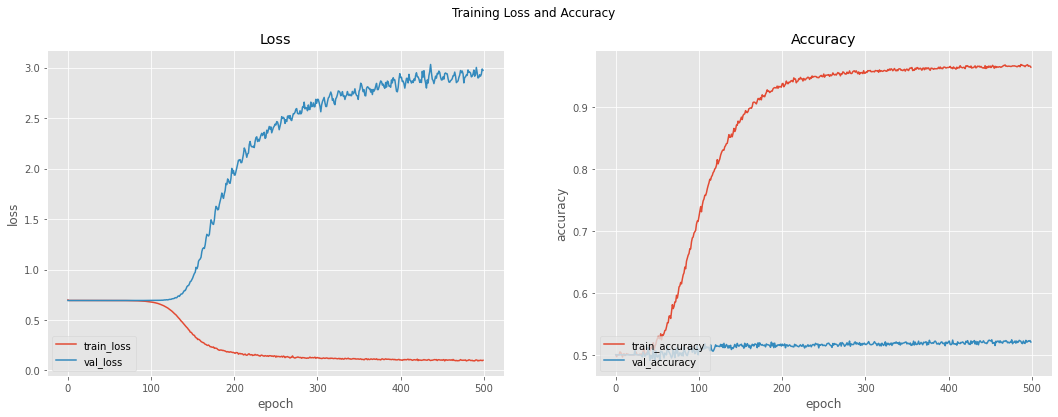

[codecarbon INFO @ 10:33:37] Energy consumed for RAM : 0.016658 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:33:37] Energy consumed for all CPUs : 0.060220 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:33:37] 0.076878 kWh of electricity used since the begining.


In [27]:
plot_training(history)

In [28]:
# evaluate test data
test_target = tf.keras.utils.to_categorical(test_values, num_classes=2)
test_result = model.evaluate([test_playlists, test_tracks],test_target)
print('Loss on test data =', test_result[0],
      '\nAccuracy on test data =', test_result[1])

  2504/555884 [..............................] - ETA: 16:41 - loss: 0.0482 - accuracy: 0.9856

[codecarbon INFO @ 10:33:52] Energy consumed for RAM : 0.016707 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:33:52] Energy consumed for all CPUs : 0.060397 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:33:52] 0.077104 kWh of electricity used since the begining.


 11055/555884 [..............................] - ETA: 16:02 - loss: 0.0487 - accuracy: 0.9857

[codecarbon INFO @ 10:34:07] Energy consumed for RAM : 0.016756 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:34:07] Energy consumed for all CPUs : 0.060574 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:34:07] 0.077330 kWh of electricity used since the begining.


 19581/555884 [>.............................] - ETA: 15:45 - loss: 0.0489 - accuracy: 0.9856

[codecarbon INFO @ 10:34:22] Energy consumed for RAM : 0.016805 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:34:22] Energy consumed for all CPUs : 0.060751 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:34:22] 0.077556 kWh of electricity used since the begining.


 28242/555884 [>.............................] - ETA: 15:25 - loss: 0.0492 - accuracy: 0.9855

[codecarbon INFO @ 10:34:37] Energy consumed for RAM : 0.016854 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:34:37] Energy consumed for all CPUs : 0.060928 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:34:37] 0.077782 kWh of electricity used since the begining.


 36884/555884 [>.............................] - ETA: 15:08 - loss: 0.0492 - accuracy: 0.9855

[codecarbon INFO @ 10:34:52] Energy consumed for RAM : 0.016903 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:34:52] Energy consumed for all CPUs : 0.061105 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:34:52] 0.078008 kWh of electricity used since the begining.


 45541/555884 [=>............................] - ETA: 14:51 - loss: 0.0492 - accuracy: 0.9855

[codecarbon INFO @ 10:35:07] Energy consumed for RAM : 0.016952 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:35:07] Energy consumed for all CPUs : 0.061282 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:35:07] 0.078234 kWh of electricity used since the begining.


 54195/555884 [=>............................] - ETA: 14:35 - loss: 0.0490 - accuracy: 0.9855

[codecarbon INFO @ 10:35:22] Energy consumed for RAM : 0.017001 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:35:22] Energy consumed for all CPUs : 0.061459 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:35:22] 0.078460 kWh of electricity used since the begining.


 62774/555884 [==>...........................] - ETA: 14:20 - loss: 0.0491 - accuracy: 0.9855

[codecarbon INFO @ 10:35:37] Energy consumed for RAM : 0.017050 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:35:37] Energy consumed for all CPUs : 0.061636 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:35:37] 0.078686 kWh of electricity used since the begining.


 71288/555884 [==>...........................] - ETA: 14:06 - loss: 0.0492 - accuracy: 0.9855

[codecarbon INFO @ 10:35:52] Energy consumed for RAM : 0.017099 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:35:52] Energy consumed for all CPUs : 0.061813 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:35:52] 0.078912 kWh of electricity used since the begining.


 79821/555884 [===>..........................] - ETA: 13:52 - loss: 0.0492 - accuracy: 0.9855

[codecarbon INFO @ 10:36:07] Energy consumed for RAM : 0.017148 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:36:07] Energy consumed for all CPUs : 0.061990 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:36:07] 0.079138 kWh of electricity used since the begining.


 88381/555884 [===>..........................] - ETA: 13:37 - loss: 0.0491 - accuracy: 0.9855- ETA: 13:4

[codecarbon INFO @ 10:36:22] Energy consumed for RAM : 0.017197 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:36:22] Energy consumed for all CPUs : 0.062167 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:36:22] 0.079364 kWh of electricity used since the begining.


 96938/555884 [====>.........................] - ETA: 13:22 - loss: 0.0491 - accuracy: 0.9855

[codecarbon INFO @ 10:36:37] Energy consumed for RAM : 0.017246 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:36:37] Energy consumed for all CPUs : 0.062344 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:36:37] 0.079590 kWh of electricity used since the begining.


105642/555884 [====>.........................] - ETA: 13:06 - loss: 0.0492 - accuracy: 0.9855

[codecarbon INFO @ 10:36:52] Energy consumed for RAM : 0.017295 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:36:52] Energy consumed for all CPUs : 0.062521 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:36:52] 0.079816 kWh of electricity used since the begining.


114342/555884 [=====>........................] - ETA: 12:50 - loss: 0.0492 - accuracy: 0.9855

[codecarbon INFO @ 10:37:07] Energy consumed for RAM : 0.017344 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:37:07] Energy consumed for all CPUs : 0.062699 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:37:07] 0.080042 kWh of electricity used since the begining.


123050/555884 [=====>........................] - ETA: 12:34 - loss: 0.0492 - accuracy: 0.9855

[codecarbon INFO @ 10:37:22] Energy consumed for RAM : 0.017393 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:37:22] Energy consumed for all CPUs : 0.062876 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:37:22] 0.080269 kWh of electricity used since the begining.


131547/555884 [======>.......................] - ETA: 12:20 - loss: 0.0493 - accuracy: 0.9855

[codecarbon INFO @ 10:37:37] Energy consumed for RAM : 0.017442 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:37:37] Energy consumed for all CPUs : 0.063053 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:37:37] 0.080495 kWh of electricity used since the begining.


140255/555884 [======>.......................] - ETA: 12:04 - loss: 0.0492 - accuracy: 0.9855

[codecarbon INFO @ 10:37:52] Energy consumed for RAM : 0.017491 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:37:52] Energy consumed for all CPUs : 0.063230 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:37:52] 0.080721 kWh of electricity used since the begining.


148753/555884 [=======>......................] - ETA: 11:50 - loss: 0.0493 - accuracy: 0.9854

[codecarbon INFO @ 10:38:07] Energy consumed for RAM : 0.017540 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:38:07] Energy consumed for all CPUs : 0.063407 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:38:07] 0.080947 kWh of electricity used since the begining.


157453/555884 [=======>......................] - ETA: 11:34 - loss: 0.0493 - accuracy: 0.9855

[codecarbon INFO @ 10:38:22] Energy consumed for RAM : 0.017589 kWh. RAM Power : 11.759872913360596 W


157481/555884 [=======>......................] - ETA: 11:34 - loss: 0.0493 - accuracy: 0.9855

[codecarbon INFO @ 10:38:22] Energy consumed for all CPUs : 0.063584 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:38:22] 0.081173 kWh of electricity used since the begining.


166161/555884 [=======>......................] - ETA: 11:19 - loss: 0.0493 - accuracy: 0.9854

[codecarbon INFO @ 10:38:37] Energy consumed for RAM : 0.017638 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:38:37] Energy consumed for all CPUs : 0.063761 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:38:37] 0.081399 kWh of electricity used since the begining.


174905/555884 [========>.....................] - ETA: 11:03 - loss: 0.0493 - accuracy: 0.9854- ETA: 11:05 -

[codecarbon INFO @ 10:38:52] Energy consumed for RAM : 0.017687 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:38:52] Energy consumed for all CPUs : 0.063938 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:38:52] 0.081625 kWh of electricity used since the begining.


183581/555884 [========>.....................] - ETA: 10:48 - loss: 0.0493 - accuracy: 0.9855

[codecarbon INFO @ 10:39:07] Energy consumed for RAM : 0.017736 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:39:07] Energy consumed for all CPUs : 0.064115 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:39:07] 0.081851 kWh of electricity used since the begining.


192216/555884 [=========>....................] - ETA: 10:32 - loss: 0.0493 - accuracy: 0.9855

[codecarbon INFO @ 10:39:22] Energy consumed for RAM : 0.017785 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:39:22] Energy consumed for all CPUs : 0.064292 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:39:22] 0.082077 kWh of electricity used since the begining.


200811/555884 [=========>....................] - ETA: 10:18 - loss: 0.0493 - accuracy: 0.9854

[codecarbon INFO @ 10:39:37] Energy consumed for RAM : 0.017834 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:39:37] Energy consumed for all CPUs : 0.064469 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:39:37] 0.082303 kWh of electricity used since the begining.


209388/555884 [==========>...................] - ETA: 10:03 - loss: 0.0493 - accuracy: 0.9855

[codecarbon INFO @ 10:39:52] Energy consumed for RAM : 0.017883 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:39:52] Energy consumed for all CPUs : 0.064646 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:39:52] 0.082529 kWh of electricity used since the begining.


218020/555884 [==========>...................] - ETA: 9:48 - loss: 0.0493 - accuracy: 0.9854

[codecarbon INFO @ 10:40:07] Energy consumed for RAM : 0.017932 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:40:07] Energy consumed for all CPUs : 0.064823 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:40:07] 0.082755 kWh of electricity used since the begining.


226627/555884 [===========>..................] - ETA: 9:33 - loss: 0.0493 - accuracy: 0.9854

[codecarbon INFO @ 10:40:22] Energy consumed for RAM : 0.017981 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:40:22] Energy consumed for all CPUs : 0.065000 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:40:22] 0.082981 kWh of electricity used since the begining.


235299/555884 [===========>..................] - ETA: 9:18 - loss: 0.0493 - accuracy: 0.9854

[codecarbon INFO @ 10:40:37] Energy consumed for RAM : 0.018030 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:40:37] Energy consumed for all CPUs : 0.065177 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:40:37] 0.083207 kWh of electricity used since the begining.


244002/555884 [============>.................] - ETA: 9:02 - loss: 0.0493 - accuracy: 0.9854

[codecarbon INFO @ 10:40:52] Energy consumed for RAM : 0.018079 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:40:52] Energy consumed for all CPUs : 0.065354 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:40:52] 0.083433 kWh of electricity used since the begining.


252765/555884 [============>.................] - ETA: 8:47 - loss: 0.0493 - accuracy: 0.9854

[codecarbon INFO @ 10:41:07] Energy consumed for RAM : 0.018128 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:41:07] Energy consumed for all CPUs : 0.065531 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:41:07] 0.083659 kWh of electricity used since the begining.


261326/555884 [=============>................] - ETA: 8:32 - loss: 0.0493 - accuracy: 0.9854

[codecarbon INFO @ 10:41:22] Energy consumed for RAM : 0.018177 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:41:22] Energy consumed for all CPUs : 0.065708 kWh. All CPUs Power : 42.5 W


261352/555884 [=============>................] - ETA: 8:32 - loss: 0.0493 - accuracy: 0.9854

[codecarbon INFO @ 10:41:22] 0.083885 kWh of electricity used since the begining.


269872/555884 [=============>................] - ETA: 8:17 - loss: 0.0493 - accuracy: 0.9854

[codecarbon INFO @ 10:41:37] Energy consumed for RAM : 0.018226 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:41:37] Energy consumed for all CPUs : 0.065886 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:41:37] 0.084111 kWh of electricity used since the begining.


278376/555884 [==============>...............] - ETA: 8:03 - loss: 0.0493 - accuracy: 0.9854

[codecarbon INFO @ 10:41:52] Energy consumed for RAM : 0.018275 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:41:52] Energy consumed for all CPUs : 0.066063 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:41:52] 0.084337 kWh of electricity used since the begining.


286967/555884 [==============>...............] - ETA: 7:48 - loss: 0.0493 - accuracy: 0.9854

[codecarbon INFO @ 10:42:07] Energy consumed for RAM : 0.018324 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:42:07] Energy consumed for all CPUs : 0.066240 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:42:07] 0.084563 kWh of electricity used since the begining.


295584/555884 [==============>...............] - ETA: 7:33 - loss: 0.0493 - accuracy: 0.9854

[codecarbon INFO @ 10:42:22] Energy consumed for RAM : 0.018373 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:42:22] Energy consumed for all CPUs : 0.066417 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:42:22] 0.084789 kWh of electricity used since the begining.


304124/555884 [===============>..............] - ETA: 7:18 - loss: 0.0493 - accuracy: 0.9854

[codecarbon INFO @ 10:42:37] Energy consumed for RAM : 0.018422 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:42:37] Energy consumed for all CPUs : 0.066594 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:42:37] 0.085015 kWh of electricity used since the begining.


312677/555884 [===============>..............] - ETA: 7:03 - loss: 0.0493 - accuracy: 0.9854

[codecarbon INFO @ 10:42:52] Energy consumed for RAM : 0.018471 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:42:52] Energy consumed for all CPUs : 0.066771 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:42:52] 0.085241 kWh of electricity used since the begining.


321187/555884 [================>.............] - ETA: 6:48 - loss: 0.0493 - accuracy: 0.9854

[codecarbon INFO @ 10:43:07] Energy consumed for RAM : 0.018520 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:43:07] Energy consumed for all CPUs : 0.066948 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:43:07] 0.085467 kWh of electricity used since the begining.


329711/555884 [================>.............] - ETA: 6:34 - loss: 0.0493 - accuracy: 0.9854

[codecarbon INFO @ 10:43:22] Energy consumed for RAM : 0.018568 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:43:22] Energy consumed for all CPUs : 0.067125 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:43:22] 0.085693 kWh of electricity used since the begining.


338475/555884 [=================>............] - ETA: 6:18 - loss: 0.0493 - accuracy: 0.9854

[codecarbon INFO @ 10:43:37] Energy consumed for RAM : 0.018617 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:43:37] Energy consumed for all CPUs : 0.067302 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:43:37] 0.085919 kWh of electricity used since the begining.


347166/555884 [=================>............] - ETA: 6:03 - loss: 0.0493 - accuracy: 0.9854

[codecarbon INFO @ 10:43:52] Energy consumed for RAM : 0.018666 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:43:52] Energy consumed for all CPUs : 0.067479 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:43:52] 0.086146 kWh of electricity used since the begining.


355485/555884 [==================>...........] - ETA: 5:49 - loss: 0.0493 - accuracy: 0.9854

[codecarbon INFO @ 10:44:07] Energy consumed for RAM : 0.018715 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:44:07] Energy consumed for all CPUs : 0.067656 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:44:07] 0.086372 kWh of electricity used since the begining.


364083/555884 [==================>...........] - ETA: 5:34 - loss: 0.0493 - accuracy: 0.9854

[codecarbon INFO @ 10:44:22] Energy consumed for RAM : 0.018764 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:44:22] Energy consumed for all CPUs : 0.067833 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:44:22] 0.086598 kWh of electricity used since the begining.


372696/555884 [===================>..........] - ETA: 5:19 - loss: 0.0493 - accuracy: 0.9854

[codecarbon INFO @ 10:44:37] Energy consumed for RAM : 0.018813 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:44:37] Energy consumed for all CPUs : 0.068010 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:44:37] 0.086824 kWh of electricity used since the begining.


381234/555884 [===================>..........] - ETA: 5:04 - loss: 0.0493 - accuracy: 0.9854

[codecarbon INFO @ 10:44:52] Energy consumed for RAM : 0.018862 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:44:52] Energy consumed for all CPUs : 0.068187 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:44:52] 0.087050 kWh of electricity used since the begining.


389807/555884 [====================>.........] - ETA: 4:49 - loss: 0.0493 - accuracy: 0.9854

[codecarbon INFO @ 10:45:07] Energy consumed for RAM : 0.018911 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:45:07] Energy consumed for all CPUs : 0.068364 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:45:07] 0.087276 kWh of electricity used since the begining.


398368/555884 [====================>.........] - ETA: 4:34 - loss: 0.0494 - accuracy: 0.9854

[codecarbon INFO @ 10:45:22] Energy consumed for RAM : 0.018960 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:45:22] Energy consumed for all CPUs : 0.068541 kWh. All CPUs Power : 42.5 W


398398/555884 [====================>.........] - ETA: 4:34 - loss: 0.0493 - accuracy: 0.9854

[codecarbon INFO @ 10:45:22] 0.087502 kWh of electricity used since the begining.


406877/555884 [====================>.........] - ETA: 4:19 - loss: 0.0493 - accuracy: 0.9854

[codecarbon INFO @ 10:45:37] Energy consumed for RAM : 0.019009 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:45:37] Energy consumed for all CPUs : 0.068718 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:45:37] 0.087728 kWh of electricity used since the begining.


415518/555884 [=====================>........] - ETA: 4:04 - loss: 0.0493 - accuracy: 0.9854

[codecarbon INFO @ 10:45:52] Energy consumed for RAM : 0.019058 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:45:52] Energy consumed for all CPUs : 0.068895 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:45:52] 0.087954 kWh of electricity used since the begining.


424151/555884 [=====================>........] - ETA: 3:49 - loss: 0.0493 - accuracy: 0.9854

[codecarbon INFO @ 10:46:07] Energy consumed for RAM : 0.019107 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:46:07] Energy consumed for all CPUs : 0.069073 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:46:07] 0.088180 kWh of electricity used since the begining.


432702/555884 [======================>.......] - ETA: 3:34 - loss: 0.0493 - accuracy: 0.9854

[codecarbon INFO @ 10:46:22] Energy consumed for RAM : 0.019156 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:46:22] Energy consumed for all CPUs : 0.069250 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:46:22] 0.088406 kWh of electricity used since the begining.


441235/555884 [======================>.......] - ETA: 3:19 - loss: 0.0493 - accuracy: 0.9854

[codecarbon INFO @ 10:46:37] Energy consumed for RAM : 0.019205 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:46:37] Energy consumed for all CPUs : 0.069427 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:46:37] 0.088632 kWh of electricity used since the begining.


449776/555884 [=======================>......] - ETA: 3:05 - loss: 0.0494 - accuracy: 0.9854

[codecarbon INFO @ 10:46:52] Energy consumed for RAM : 0.019254 kWh. RAM Power : 11.759872913360596 W


449807/555884 [=======================>......] - ETA: 3:05 - loss: 0.0494 - accuracy: 0.9854

[codecarbon INFO @ 10:46:52] Energy consumed for all CPUs : 0.069604 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:46:52] 0.088858 kWh of electricity used since the begining.


458279/555884 [=======================>......] - ETA: 2:50 - loss: 0.0494 - accuracy: 0.9854

[codecarbon INFO @ 10:47:07] Energy consumed for RAM : 0.019303 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:47:07] Energy consumed for all CPUs : 0.069781 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:47:07] 0.089084 kWh of electricity used since the begining.


466854/555884 [========================>.....] - ETA: 2:35 - loss: 0.0494 - accuracy: 0.9854

[codecarbon INFO @ 10:47:22] Energy consumed for RAM : 0.019352 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:47:22] Energy consumed for all CPUs : 0.069958 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:47:22] 0.089310 kWh of electricity used since the begining.


475413/555884 [========================>.....] - ETA: 2:20 - loss: 0.0494 - accuracy: 0.9854

[codecarbon INFO @ 10:47:37] Energy consumed for RAM : 0.019401 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:47:37] Energy consumed for all CPUs : 0.070135 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:47:37] 0.089536 kWh of electricity used since the begining.


483943/555884 [=========================>....] - ETA: 2:05 - loss: 0.0494 - accuracy: 0.9854

[codecarbon INFO @ 10:47:52] Energy consumed for RAM : 0.019450 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:47:52] Energy consumed for all CPUs : 0.070312 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:47:52] 0.089762 kWh of electricity used since the begining.


492741/555884 [=========================>....] - ETA: 1:50 - loss: 0.0494 - accuracy: 0.9854

[codecarbon INFO @ 10:48:07] Energy consumed for RAM : 0.019499 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:48:07] Energy consumed for all CPUs : 0.070489 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:48:07] 0.089988 kWh of electricity used since the begining.


501564/555884 [==========================>...] - ETA: 1:34 - loss: 0.0494 - accuracy: 0.9854

[codecarbon INFO @ 10:48:22] Energy consumed for RAM : 0.019548 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:48:22] Energy consumed for all CPUs : 0.070666 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:48:22] 0.090214 kWh of electricity used since the begining.


510156/555884 [==========================>...] - ETA: 1:19 - loss: 0.0494 - accuracy: 0.9854

[codecarbon INFO @ 10:48:37] Energy consumed for RAM : 0.019597 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:48:37] Energy consumed for all CPUs : 0.070843 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:48:37] 0.090440 kWh of electricity used since the begining.


518759/555884 [==========================>...] - ETA: 1:04 - loss: 0.0494 - accuracy: 0.9854

[codecarbon INFO @ 10:48:52] Energy consumed for RAM : 0.019646 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:48:52] Energy consumed for all CPUs : 0.071020 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:48:52] 0.090666 kWh of electricity used since the begining.


527372/555884 [===========================>..] - ETA: 49s - loss: 0.0494 - accuracy: 0.9854

[codecarbon INFO @ 10:49:07] Energy consumed for RAM : 0.019695 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:49:07] Energy consumed for all CPUs : 0.071197 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:49:07] 0.090892 kWh of electricity used since the begining.


535976/555884 [===========================>..] - ETA: 34s - loss: 0.0494 - accuracy: 0.9854

[codecarbon INFO @ 10:49:22] Energy consumed for RAM : 0.019744 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:49:22] Energy consumed for all CPUs : 0.071374 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:49:22] 0.091118 kWh of electricity used since the begining.


544611/555884 [============================>.] - ETA: 19s - loss: 0.0494 - accuracy: 0.9855

[codecarbon INFO @ 10:49:37] Energy consumed for RAM : 0.019793 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:49:37] Energy consumed for all CPUs : 0.071551 kWh. All CPUs Power : 42.5 W


544641/555884 [============================>.] - ETA: 19s - loss: 0.0494 - accuracy: 0.9855

[codecarbon INFO @ 10:49:37] 0.091344 kWh of electricity used since the begining.


553333/555884 [============================>.] - ETA: 4s - loss: 0.0494 - accuracy: 0.9856

[codecarbon INFO @ 10:49:52] Energy consumed for RAM : 0.019842 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:49:52] Energy consumed for all CPUs : 0.071728 kWh. All CPUs Power : 42.5 W


553362/555884 [============================>.] - ETA: 4s - loss: 0.0494 - accuracy: 0.9856

[codecarbon INFO @ 10:49:52] 0.091570 kWh of electricity used since the begining.


555884/555884 [==============================] - 969s 2ms/step - loss: 0.0494 - accuracy: 0.9857
Loss on test data = 0.04938657954335213 
Accuracy on test data = 0.9856530427932739


[codecarbon INFO @ 10:50:07] Energy consumed for RAM : 0.019891 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:50:07] Energy consumed for all CPUs : 0.071905 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:50:07] 0.091796 kWh of electricity used since the begining.
[codecarbon INFO @ 10:50:22] Energy consumed for RAM : 0.019940 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:50:22] Energy consumed for all CPUs : 0.072082 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:50:22] 0.092022 kWh of electricity used since the begining.
[codecarbon INFO @ 10:50:37] Energy consumed for RAM : 0.019989 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:50:37] Energy consumed for all CPUs : 0.072259 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:50:37] 0.092248 kWh of electricity used since the begining.
[codecarbon INFO @ 10:50:52] Energy consumed for RAM : 0.020038 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 10:50:52] Energy consumed for all

[codecarbon INFO @ 10:57:22] Energy consumed for all CPUs : 0.077040 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 10:57:22] 0.098351 kWh of electricity used since the begining.


## Model Performance Metrics

In [35]:
y_prob = model.predict([test_playlists, test_tracks])
y_classes = y_prob.argmax(axis=-1)

[codecarbon INFO @ 11:00:07] Energy consumed for RAM : 0.021850 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 11:00:07] Energy consumed for all CPUs : 0.078988 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 11:00:07] 0.100838 kWh of electricity used since the begining.
[codecarbon INFO @ 11:00:22] Energy consumed for RAM : 0.021899 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 11:00:22] Energy consumed for all CPUs : 0.079165 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 11:00:22] 0.101064 kWh of electricity used since the begining.
[codecarbon INFO @ 11:00:37] Energy consumed for RAM : 0.021948 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 11:00:37] Energy consumed for all CPUs : 0.079342 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 11:00:37] 0.101290 kWh of electricity used since the begining.
[codecarbon INFO @ 11:00:52] Energy consumed for RAM : 0.021997 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 11:00:52] Energy consumed for all

[codecarbon INFO @ 11:07:22] Energy consumed for all CPUs : 0.084124 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 11:07:22] 0.107395 kWh of electricity used since the begining.
[codecarbon INFO @ 11:07:37] Energy consumed for RAM : 0.023320 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 11:07:37] Energy consumed for all CPUs : 0.084301 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 11:07:37] 0.107621 kWh of electricity used since the begining.
[codecarbon INFO @ 11:07:52] Energy consumed for RAM : 0.023369 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 11:07:52] Energy consumed for all CPUs : 0.084478 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 11:07:52] 0.107847 kWh of electricity used since the begining.
[codecarbon INFO @ 11:08:07] Energy consumed for RAM : 0.023418 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 11:08:07] Energy consumed for all CPUs : 0.084655 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 11:08:07] 0.108073 kWh of electricity

array([[9.9999952e-01, 4.7830139e-07],
       [1.0000000e+00, 7.2190838e-12],
       [9.9999917e-01, 7.8072975e-07],
       ...,
       [9.9999881e-01, 1.1355085e-06],
       [9.9933392e-01, 6.6607608e-04],
       [1.0000000e+00, 7.5064852e-09]], dtype=float32)

[codecarbon INFO @ 11:09:52] Energy consumed for RAM : 0.023761 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 11:09:52] Energy consumed for all CPUs : 0.085894 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 11:09:52] 0.109655 kWh of electricity used since the begining.
[codecarbon INFO @ 11:10:07] Energy consumed for RAM : 0.023810 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 11:10:07] Energy consumed for all CPUs : 0.086072 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 11:10:07] 0.109881 kWh of electricity used since the begining.
[codecarbon INFO @ 11:10:22] Energy consumed for RAM : 0.023859 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 11:10:22] Energy consumed for all CPUs : 0.086249 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 11:10:22] 0.110107 kWh of electricity used since the begining.
[codecarbon INFO @ 11:10:37] Energy consumed for RAM : 0.023908 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 11:10:37] Energy consumed for all

In [104]:
def R_precision(rec, Y):
    """
    Computes the R-Precision score for a given recommendation list.

    Parameters:
        rec (list): The recommendation list.
        Y (list): The ground truth track list.

    Returns:
        float: The R-Precision score.

    """
    count = 0
    for song in Y:
        if song in rec[:len(Y)]:
            count += 1 
    return count/len(Y)

def NDCG(rec, Y):
    """
    Computes the Normalized Discounted Cumulative Gain (NDCG) score for a given recommendation list.

    Parameters:
        rec (list): The recommendation list.
        Y (list): The ground truth track list.

    Returns:
        float: The NDCG score.

    """
    IDCG = 0
    for i in range(0,len(Y)):
        if i == 0: IDCG += 1
        else: IDCG += 1/math.log((i+2),2)
    DCG = 0
    for i in range(0,len(rec)):
        if i == 0 and rec[i] in Y: DCG += 1
        elif i > 0 and rec[i] in Y: DCG += 1/math.log((i+2),2)     
    return DCG/IDCG

def clicks(rec, Y):
    """
    Computes the number of recommendations until the first correct recommendation is found.

    Parameters:
        rec (list): The recommendation list.
        Y (list): The ground truth track list.

    Returns:
        int: The number of recommendations until the first correct recommendation is found.

    """
    found_at = -1
    find = 0
    while found_at == -1 and find < len(Y):
        if rec[find] in Y: found_at = find
        else: find += 1
    if found_at == -1:
        return len(Y)//10
    else:
        return found_at//10

[codecarbon INFO @ 12:31:22] Energy consumed for RAM : 0.039728 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 12:31:22] Energy consumed for all CPUs : 0.143614 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 12:31:22] 0.183342 kWh of electricity used since the begining.


In [110]:
rec = np.where(y_classes == 1)[0].tolist()
Y = np.where(test_values == 1)[0].tolist()

In [115]:
R_precision_score = R_precision(rec, Y)
NDCG_score = NDCG(rec, Y)
clicks_score = clicks(rec, Y)

print(f'R_precision: {R_precision_score}')
print(f'NDCG: {NDCG_score}')
print(f'clicks: {clicks_score}')

R_precision: 0.0003969829297340214
NDCG: 0.035040232846971144
clicks: 53


[codecarbon INFO @ 12:38:53] Energy consumed for RAM : 0.041196 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 12:38:53] Energy consumed for all CPUs : 0.148922 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 12:38:53] 0.190118 kWh of electricity used since the begining.


In [123]:
experiment.end()

[codecarbon INFO @ 12:54:00] Energy consumed for RAM : 0.044151 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 12:54:00] Energy consumed for all CPUs : 0.159623 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 12:54:00] 0.203774 kWh of electricity used since the begining.
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/sadcor/general/a698a8c031f3443cb85948d7e5783675
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     accuracy [500]                : (0.4964500069618225, 0.9685999751091003)
COMET INFO:     batch_accuracy [500]          : (0.4964500069618225, 0.9685999751091003)
COMET INFO:     batch_loss [500]              : (0.09409907460212708, 0.69845622777938